# Machine Learning Project 
### Mbusu-Team 
-  **House Prices Dataset**

### **Data Understanding**

In [401]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sb
from scipy.stats import entropy
import math
import sys
from pandas.api.types import CategoricalDtype
from itertools import groupby
import re
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OneHotEncoder 
from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_integer_dtype
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from statistics import mean
from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


plt.style.use('ggplot')


hue_order = ["HIGH","MEDIUM","LOW"]
color = ["#BF4E30","#2E86AB","#E7A012"]
palette = {
    'LOW': color[0],
    'MEDIUM': color[1],
    'HIGH': color[2],
}
TARGET_FEATURE = 'SalePrice'
TARGET_FEATURE_CONTI = 'salePriceNum'
TARGET_FEATURE_VALUES = ['LOW', 'MEDIUM', 'HIGH']
SEED = 6536

#### Utils

In [402]:
def get_common_category(df: pd.DataFrame, category: str,  attribute: str, exclude:list, target_feature = TARGET_FEATURE):
    df_filtered = df[df[target_feature] == category]
    df_filtered = df_filtered[~df_filtered[attribute].isin(exclude)]
    return df_filtered[attribute].mode().iloc[0]
    

###### Information Gain function 

In [403]:
def IG(df, target, attribute):

    df_sub = []

    for value in df[attribute].unique():
        df_sub.append( df[df[attribute] == value] )
        
    counts = df[target].value_counts()
    probs = counts / len(df)
    e = -np.sum(probs * np.log2(probs))

    information_gain = e 
    for df_s in df_sub:
        counts = df_s[target].value_counts()
        probs = counts / len(df_s)
        e_s = -np.sum(probs * np.log2(probs))
        information_gain -= len(df_s) / len(df) * e_s

    return information_gain

###### Mean

In [404]:
def mean_attribute(df, attribute):
    mean_low = df[ ( df["SalePrice"] == 'LOW' ) & ( df[attribute] != 'NA' ) ][attribute].astype("int").mean()
    mean_medium = df[ ( df["SalePrice"] == 'MEDIUM' ) & ( df[attribute] != 'NA' ) ][attribute].astype("int").mean()
    mean_high = df[ ( df["SalePrice"] == 'HIGH' ) & ( df[attribute] != 'NA' ) ][attribute].astype("int").mean()
    return (mean_low, mean_medium, mean_high)

###### Set means

In [405]:
def set_means(df,attribute):
    mean_values = mean_attribute(df,attribute)

    for ind , e  in df.iterrows():
        if e[attribute] == "NA":
            if(e["SalePrice"] == "LOW"):
                df.at[ind, attribute] = mean_values[0]
            elif e["SalePrice"] == "MEDIUM":
                df.at[ind, attribute] = mean_values[1]
            else:
                df.at[ind, attribute] = mean_values[2]


    df[attribute] = df[attribute].astype("int")

###### Aggregate categories if below threshold

In [406]:
def aggregate(df, new_name, threshold, attribute):
    values_count= df[attribute].value_counts()
    for i in values_count.keys():
        if values_count[i] <= threshold:
            df[attribute] = df[attribute].replace([i], new_name)
    return df

###### Plot frequencies and percentages for numerical attributes

In [407]:
def frequencies_and_percentages_numeric(df, target, attribute, bin, rotation=0, figsize=(15,5),display=False):
    fig, ax = plt.subplots(1,2, figsize=figsize)
    df1 = df.copy()
    df1[attribute] = pd.qcut(df1[attribute], q=bin)
    regexp_1 = re.compile(r".(\-?\d+)\.?\d*, ?(\-?\d+)\.?\d*.")
    for i in df1[attribute].unique():
        re_match = regexp_1.match(str(i))
        if re_match is not None:
            val = [re_match[1], re_match[2]]
            for j in range(0, len(val)):
                    if val[j] == "-0":
                         val[j] = "0"
            df1[attribute] = df1[attribute].replace(i, str(val[0])+" - "+str(val[1]))
    dfp = df1[[attribute,target]].pivot_table(index = attribute, columns=[target],  aggfunc=len)
    dfp = dfp.fillna(0)
    dfpp = dfp.pipe(lambda d : 100*d.div(sum(d[v] for v in df1[target].unique()), axis='index'))
    if display:
        display(dfpp)
    dfp.plot(kind='bar', ax=ax[0]  , title = f"Count by {attribute}" ,  color = color)
    dfpp.plot(kind='bar',ax=ax[1] , stacked=True , title  = f"Percentage by {attribute}", legend = False , color = color )
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=rotation, horizontalalignment='right')
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=rotation, horizontalalignment='right')

###### Plot frequencies and percentages

In [408]:
def frequencies_and_percentages(df, target, attribute, figsize=(15,5), rotation=0, display=False):
    fig, ax = plt.subplots(1,2, figsize=figsize)

    dfp = df[[attribute,target]].pivot_table(index = attribute, columns=[target],  aggfunc=len)
    dfp = dfp.fillna(0)
    dfpp = dfp.pipe(lambda d : 100*d.div(sum(d[v] for v in df[target].unique()), axis='index'))
    if display:
        display(dfpp)
    dfp.plot(kind='bar', ax=ax[0]  , title = f"Count by {attribute}" ,  color = color)
    dfpp.plot(kind='bar',ax=ax[1] , stacked=True , title  = f"Percentage by {attribute}", legend = False , color = color )
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=rotation, horizontalalignment='right')
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=rotation, horizontalalignment='right')

###### Category analysis

In [409]:
def category_common_analysis(data, x, target ,palette, histplot = True, percentages=True, count = None, display=True, figsize=(15,5), rotation = 0):
    if histplot:
        plt.figure(figsize = figsize)
        sb.histplot(x = data[x], multiple='stack', hue = target,  data = data, hue_order = hue_order, palette = palette, alpha=1)
    if percentages:
        frequencies_and_percentages(data, target, x,figsize=figsize,rotation=rotation)
    if display:
        if count is None:
            print(data[x].value_counts())
        else :
            print(data[x].value_counts()[count])

###### Histplot

In [410]:

def histplot(df,target, attribute, bins = 200 , figsize=(15,5), xticks_rot=0, xlim = None, multiple = 'layer', alpha = 0.5):
    plt.figure(figsize = figsize)
    sb.histplot(x = df[attribute], hue = target, data = df, kde=True , hue_order = hue_order, palette = palette, multiple= multiple , 
                bins = bins ,alpha = alpha , common_bins= True)
    plt.xticks(rotation=xticks_rot)
    if xlim is not None:
        plt.xlim(xlim)
    plt.show()

###### Indepence_test_categoric

In [411]:
def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='gray')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]
    
def label_group_bar_table(ax, df):
    ypos = -.05
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            if pos % 3 == 0: add_line(ax, pos*scale, ypos - .052)
            pos += rpos
        add_line(ax, pos*scale , ypos - .052)
        ypos -= .05

def barplot_diffvalues(dataset, feature_name):
    df = dataset.reset_index().groupby([feature_name, TARGET_FEATURE]).sum()
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    #print(dataset)
    dataset.pivot_table(index = [feature_name, TARGET_FEATURE], columns=['__Type']).plot(kind='bar', ax=ax, width=.7)
    
    labels = ['' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    ax.set_title('Expected/Observed Frequencies')
    ax.set_xlabel(f'{feature_name}/{TARGET_FEATURE}', labelpad=40)
    ax.set_ylabel(f'{TARGET_FEATURE}')
    plt.legend(['Expected', 'Observed'])
    label_group_bar_table(ax, df)

    fig.subplots_adjust(bottom=.1*df.index.nlevels)
    plt.show()

def stattest_quali(df, feature_name: str, target = TARGET_FEATURE, fig_width=15, fig_height=3, typeplot = 'heatmap', silent: bool=False, cramer: bool=False):
    #
    # chi-square test and expected frequencies matrix
    #
    crosstab = pd.crosstab(df[feature_name], df[target])
    chi_square_args = crosstab.values
    _, p_value, _, _ = stats.chi2_contingency(chi_square_args)
 
    #
    # Cramer's V
    #
    cramer_crosstab = crosstab.values
    X2 = stats.chi2_contingency(cramer_crosstab, correction=False)[0]
    N = np.sum(cramer_crosstab)
    minimum_dimension = min(cramer_crosstab.shape)-1
    corr_cramer = np.sqrt((X2/N) / minimum_dimension)

    expf_crosstab = pd.DataFrame(crosstab)
    for idx in expf_crosstab.index:
        for col in expf_crosstab.columns:
            expf_crosstab.at[idx, col] = crosstab.loc[idx].values.sum() * crosstab[col].values.sum() / crosstab.values.sum()

    if not silent:
        #
        # observed/expected frequencies heatmaps
        #
        fig_width = min(fig_width, 1.5 * len(df[feature_name].unique()))
        fig, ax = plt.subplots(2, 1, figsize=(fig_width, fig_height * 2))
        sb.heatmap(crosstab.T, ax=ax[0], annot=True, cmap='coolwarm', fmt='.2f')
        sb.heatmap(expf_crosstab.T, ax=ax[1], annot=True, cmap='coolwarm', fmt='.2f')
        ax[0].set_title('Observed Frequencies')    
        ax[1].set_title('Expected Frequencies')
        fig.tight_layout()
        plt.show()

        if(typeplot == 'heatmap'):
            
            #
            # frequencies difference heatmap
            #
            obsexp_diff_df = crosstab - expf_crosstab
            fig = plt.figure(figsize=(fig_width, fig_height))
            plt.title("Frequency Differences (Observed - Expected)")
            sb.heatmap(obsexp_diff_df.T, annot=True, cmap='vlag', fmt='.2f')
        
        elif typeplot == 'barplot':
            #
            # observed/expected frequencies barplot
            #
            value_vars_x = [val + '_x' for val in df[target].unique().tolist()]
            value_vars_y = [val + '_y' for val in df[target].unique().tolist()]
            value_vars_xy = value_vars_x + value_vars_y
            obs_exp_df = pd.merge(crosstab, expf_crosstab, on=[feature_name]).reset_index()
            obs_exp_df = pd.melt(obs_exp_df, id_vars=[feature_name], value_vars=value_vars_xy)
            obs_exp_df['__Type'] = obs_exp_df[target]

            for val in value_vars_x: obs_exp_df.loc[obs_exp_df['__Type'] == val, '__Type'] = '__OBS'
            for val in value_vars_y: obs_exp_df.loc[obs_exp_df['__Type'] == val, '__Type'] = '__EXP'

            for price in df[target].unique().tolist():
                for obs_exp in ['x', 'y']:
                    obs_exp_df.loc[obs_exp_df[target] == price + '_' + obs_exp, target] = price[0]

            barplot_diffvalues(obs_exp_df, feature_name)

    #
    # chi-square test outcome
    #
    p_value_info = '[<0.05]' if p_value < 0.05 else ''
    if not silent:
        print("Chi-square Test - Outcome")
        print("P-Value:", p_value, p_value_info)
        print("Cramer's V - Outcome")
        print("Coeff:", corr_cramer)
    if cramer:
        return p_value, p_value_info, corr_cramer
    return p_value, p_value_info

###### Indepence_test_numeric

In [412]:
def stattest_quanti(df, feature_name: str, target = TARGET_FEATURE ,low_limit=0, upper_limit=100, silent = False, cramer: bool = False):
 
    #
    # Cramer's V
    #
    if cramer:
        df_copy2 = df.copy(deep=True)
        df_copy2[feature_name] = pd.qcut(df_copy2[feature_name], q=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], duplicates='drop', labels=False)
        if len(df_copy2[feature_name].unique().tolist()) >= 2:
            _, _, corr_cramer = stattest_quali(df_copy2, feature_name=feature_name, target=target, cramer=True, silent=True)
        else:
            corr_cramer = 0.0 # TODO: raise RuntimeWarning("Computing Cramer's V coefficient but %s admits just one categorical value." % feature_name)
        
    #
    # plot means w.r.t. target categories
    #
    df_conti_origin = df[[feature_name, target, TARGET_FEATURE_CONTI]] if ( target == TARGET_FEATURE) else None
    df_categ_origin = df[[feature_name, target]]
    target_feature_values = df[target].unique().tolist()
    df = df_categ_origin.groupby(target)
    mean_df = df.mean().reset_index().rename(columns={feature_name: feature_name + ' (AVG)'})

    if not silent: 
        num = 3
        if df_conti_origin is None:
            num = 2
        _, ax = plt.subplots(1, num, figsize=(20, 5))

        mean_df.plot(kind='bar', x=target, ax=ax[0])
        for container in ax[0].containers:
            ax[0].bar_label(container, fmt='%.1f')
        ax[0].set_ylim(low_limit, upper_limit)
        ax[0].tick_params(labelrotation=0)
        sb.histplot(x=feature_name, hue=target, data=df_categ_origin, kde=True, ax=ax[1])
        for tval in target_feature_values:
            ax[1].axvline(x=df_categ_origin[df_categ_origin[target] == tval][feature_name].mean(), color='gray', ls='--', lw=1.5)
        
        if df_conti_origin is not None : sb.regplot(x=feature_name, y=TARGET_FEATURE_CONTI, data=df_conti_origin, line_kws={"color": "darkred"}, ax=ax[2])
        
    #
    # perform ANOVA test
    #
    anova_args = tuple(df[feature_name].apply(list).reset_index()[feature_name])
    f_statistic, p_value = stats.f_oneway(*anova_args)

    p_value_info = '[<0.05]' if p_value < 0.05 else ''
    if not silent:
        print("ANOVA Test - Outcome")
        print("P-Value:", p_value, p_value_info)
        if cramer:
            print("Cramer's V - Outcome")
            print("Coeff:", corr_cramer)
    if cramer:
        return p_value, p_value_info, corr_cramer
    return p_value, p_value_info

###### Numeric-Numeric Correlation

In [413]:
def correlation(df, n1, n2, silent = False):

    corr, p_values = stats.pearsonr(df[n1], df[n2])
    
    if not silent:
        sb.regplot(x=n1, y=n2, data=df, line_kws={"color": "darkred"})
        print(corr, p_values)

    return (corr, p_values)

###### Categoric Ordinal Plots & Stattest

In [414]:
def categoric_ordinal_plot(df, attr, test_typeplot='heatmap'):

    attr_values = df[attr].unique().tolist()
    df[attr] = df[attr].astype('object')
    for val in attr_values: df.loc[df[attr] == val, attr] = attr + '_' + str(val)
    df[attr] = df[attr].astype('category')

    frequencies_and_percentages(df, TARGET_FEATURE, attr)
    stattest_quali(df, attr, typeplot=test_typeplot)
    print(IG(df, TARGET_FEATURE, attr))

###### Understanding 

In [415]:
def understand(dataf: pd.DataFrame, feature_name: str, dtype: str='category', \
               predconf_max: float=1.0, predconf_min: float=0.33, showplots=True, na = 'NA', bins = 50, \
               low_limit = 0, upper_limit = 100 , xlim = None, rotation = 0):
    if dtype == 'object':
        dataf = dataf.copy(deep=True)
    data_feature = dataf[feature_name]
    data_target = dataf[TARGET_FEATURE]
    report = ''
    report += "Understanding %s:" % feature_name + "\n"
    
    #
    # count missing values
    #
    miss_values = data_feature.isna().sum()
    miss_values += dataf[data_feature == na ].index.size
    report += "\tMissing values: " + str(miss_values) + "\n"

    data_feature = data_feature.astype(dtype)

    if dtype == 'category' or dtype == 'object':

        if dtype == 'object':
            attr_values = data_feature.unique().tolist()
            data_feature = data_feature.astype('object')
            for ind in range(len(dataf)): data_feature[ind] = feature_name + '_' + str(data_feature[ind])
            data_feature = data_feature.astype('category')
            dataf[feature_name] = data_feature

        if showplots: 
            frequencies_and_percentages(dataf, TARGET_FEATURE, feature_name, rotation= rotation)
        #
        # perform the independence test
        #
        p_value, p_value_info = stattest_quali(dataf, feature_name, typeplot='heatmap' if showplots else'none', silent=not showplots)
        report += "\tIndependence Test: " + '{:.2e}'.format(p_value) + p_value_info + "\n"

        #
        # compute the IG
        #
        ig = IG(dataf, TARGET_FEATURE, feature_name)
        report += "\tInformation Gain: " + "%.2f" % ig + "\n"

        crosstab = pd.crosstab(data_feature, data_target)
        to_predict_map = {}
        no_predict_values = []
        for cat_val in crosstab.T:
            no_predict_values.append(cat_val)
        predconf = predconf_max

        while predconf > predconf_min and len(no_predict_values) > 0:
            new_no_predict_values = []

            for cat_val in no_predict_values:
                to_predict = []
                for target_val in TARGET_FEATURE_VALUES:
                    if crosstab.at[cat_val, target_val] / crosstab.loc[cat_val].values.sum() >= predconf:
                        to_predict.append(target_val)
                        to_predict.append(predconf)
                        break
                
                if len(to_predict) > 0:
                    new_to_predict_map = to_predict_map.copy()
                    added = False
                    to_delete = []
                    for k in to_predict_map.keys():
                        if to_predict_map[k] == to_predict:
                            new_to_predict_map[k + '+' + cat_val] = to_predict
                            added = True
                            to_delete.append(k)
                    if not added:
                        new_to_predict_map[cat_val] = to_predict
                    for k in to_delete:
                        del new_to_predict_map[k]
                    to_predict_map = new_to_predict_map
                else:
                    new_no_predict_values.append(cat_val)
            
            no_predict_values = new_no_predict_values
            predconf -= 0.05
        
        report += "\tWhen the %s is:" % feature_name + "\n"
        for cat_vals in to_predict_map.keys():
            if to_predict_map[cat_vals][1] == 1.0:
                report += "\t\t• %s, then the sale price is %s" % (cat_vals, to_predict_map[cat_vals][0])
            else:
                report += "\t\t• %s, then the sale price is %.0f%% likely to be %s" % \
                    (cat_vals, to_predict_map[cat_vals][1]*100, to_predict_map[cat_vals][0])
            
            cat_vals_freq = 0.0
            for cval in cat_vals.split('+'):
                cat_vals_freq += len(dataf[data_feature == cval]) / len(data_feature)
            report += " (%.2f%% of the times)" % (cat_vals_freq*100) + "\n"

        if len(no_predict_values) > 0:
            report += "\t\t• %s cannot predict the sale price" % '+'.join(no_predict_values) + "\n"
        report += "\n"

    elif dtype == 'int':
        if showplots: 
            histplot(df=dataf, target=TARGET_FEATURE, attribute=feature_name, bins= bins, xlim = xlim)
        p_value, p_value_info = stattest_quanti(df=dataf, feature_name=feature_name, target=TARGET_FEATURE,low_limit=low_limit, upper_limit=upper_limit, silent=True)
        report += "\tIndependence Test: " + '{:.2e}'.format(p_value) + p_value_info + "\n"
        corr, p_value_corr = correlation(df=dataf, n1= feature_name, n2= TARGET_FEATURE_CONTI, silent=True)
        report += "\tCorrelation Index: %.2f" % corr + "\n"
        report += "\tCorrelation p_value: " + '{:.2e}'.format(p_value_corr) + "\n"

    print(report)

###### Undestanding all

In [416]:
def understanding_all(df):
    features = df.columns
    repos = []
    for f in features:
        if df[f].dtype == 'object':
            repo, ig, p_value = understand(df, f, 'category')
            repos.append((ig, p_value, repo))
    repos.sort(reverse=True)
    for r in repos:
        print(r[2])

###### Total Square Fit

In [417]:
def total_square_feet(dataf: pd.DataFrame):
    total_sf = []
    for ind, e in dataf.iterrows():
        totalsf = e['TotalBsmtSF']
        if e["GarageType"] != 'Basment': 
            totalsf += e['GarageArea']
        # totalsf += e['1stFlrSF']
        # totalsf += e['2ndFlrSF']
        totalsf += e['GrLivArea']
        total_sf.append(totalsf)
    
    return total_sf

###### Resample

In [418]:
def resample(df): 
        attributes = df.columns.tolist()
        attributes.remove("SalePrice")

        cat = list(df.select_dtypes(include = ['category', 'object']).columns)
        cat_index = []
        for i in cat:
                cat_index.append(df.columns.get_loc(i))
        #print("Length of cat attr: " + str(len(cat_index)))
        X_resample, y_resampled = SMOTENC(categorical_features=cat_index, sampling_strategy="minority", random_state=1020).fit_resample(df[attributes], df[TARGET_FEATURE])

        df_resample = pd.DataFrame(columns=df.columns)


        df_resample[attributes] = X_resample
        df_resample[TARGET_FEATURE] = y_resampled
        return df_resample

#### Read data

In [419]:
df = pd.read_csv('house-prices-advanced-regression-techniques/train.csv', keep_default_na = False, low_memory= False )
df["salePriceNum"] = df.SalePrice.rename("salePriceNum")
df["SalePrice"] = pd.cut(df["salePriceNum"], bins = [0,150000,300000 - 1 ,int(sys.maxsize)], labels=["LOW","MEDIUM","HIGH"])
df_copy = df.copy(deep=True)

# To remove
df["TotalSF"] = total_square_feet(df)

df_resample = resample(df)

df_resample =  df_resample.drop(columns=['Id'])

In [420]:
df.shape

(1460, 83)

In [421]:
df.describe()

Id   MSSubClass        LotArea  OverallQual  OverallCond  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean    730.500000    56.897260   10516.828082     6.099315     5.575342   
std     421.610009    42.300571    9981.264932     1.382997     1.112799   
min       1.000000    20.000000    1300.000000     1.000000     1.000000   
25%     365.750000    20.000000    7553.500000     5.000000     5.000000   
50%     730.500000    50.000000    9478.500000     6.000000     5.000000   
75%    1095.250000    70.000000   11601.500000     7.000000     6.000000   
max    1460.000000   190.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  ...  \
count  1460.000000   1460.000000  1460.000000  1460.000000  1460.000000  ...   
mean   1971.267808   1984.865753   443.639726    46.549315   567.240411  ...   
std      30.202904     20.645407   456.098091   161.319273   441.866955  ...   
min    1872.000000   1950.000000     0.000000     0.000000     0.000000  ...   
25%    1954.000000   1967.000000     0.000000     0.000000   223.000000  ...   
50%    1973.000000   1994.000000   383.500000     0.000000   477.500000  ...   
75%    2000.000000   2004.000000   712.250000     0.000000   808.000000  ...   
max    2010.000000   2010.000000  5644.000000  1474.000000  2336.000000  ...   

       OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch     PoolArea  \
count  1460.000000    1460.000000  1460.000000  1460.000000  1460.000000   
mean     46.660274      21.954110     3.409589    15.060959     2.758904   
std      66.256028      61.119149    29.317331    55.757415    40.177307   
min       0.000000       0.000000     0.000000     0.000000     0.000000   
25%       0.000000       0.000000     0.000000     0.000000     0.000000   
50%      25.000000       0.000000     0.000000     0.000000     0.000000   
75%      68.000000       0.000000     0.000000     0.000000     0.000000   
max     547.000000     552.000000   508.000000   480.000000   738.000000   

            MiscVal       MoSold       YrSold   salePriceNum       TotalSF  
count   1460.000000  1460.000000  1460.000000    1460.000000   1460.000000  
mean      43.489041     6.321918  2007.815753  180921.195890   3040.131507  
std      496.123024     2.703626     1.328095   79442.502883    961.207530  
min        0.000000     1.000000  2006.000000   34900.000000    334.000000  
25%        0.000000     5.000000  2007.000000  129975.000000   2392.750000  
50%        0.000000     6.000000  2008.000000  163000.000000   2934.000000  
75%        0.000000     8.000000  2009.000000  214000.000000   3570.000000  
max    15500.000000    12.000000  2010.000000  755000.000000  13170.000000  

[8 rows x 36 columns]

#### View Data

In [422]:
df.head()

Id  MSSubClass MSZoning LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL          65     8450   Pave    NA      Reg   
1   2          20       RL          80     9600   Pave    NA      Reg   
2   3          60       RL          68    11250   Pave    NA      IR1   
3   4          70       RL          60     9550   Pave    NA      IR1   
4   5          60       RL          84    14260   Pave    NA      IR1   

  LandContour Utilities  ... Fence MiscFeature MiscVal MoSold YrSold SaleType  \
0         Lvl    AllPub  ...    NA          NA       0      2   2008       WD   
1         Lvl    AllPub  ...    NA          NA       0      5   2007       WD   
2         Lvl    AllPub  ...    NA          NA       0      9   2008       WD   
3         Lvl    AllPub  ...    NA          NA       0      2   2006       WD   
4         Lvl    AllPub  ...    NA          NA       0     12   2008       WD   

  SaleCondition  SalePrice  salePriceNum  TotalSF  
0        Normal     MEDIUM        208500     3114  
1        Normal     MEDIUM        181500     2984  
2        Normal     MEDIUM        223500     3314  
3       Abnorml        LOW        140000     3115  
4        Normal     MEDIUM        250000     4179  

[5 rows x 83 columns]

#### Info data

In [423]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 83 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             1460 non-null   int64   
 1   MSSubClass     1460 non-null   int64   
 2   MSZoning       1460 non-null   object  
 3   LotFrontage    1460 non-null   object  
 4   LotArea        1460 non-null   int64   
 5   Street         1460 non-null   object  
 6   Alley          1460 non-null   object  
 7   LotShape       1460 non-null   object  
 8   LandContour    1460 non-null   object  
 9   Utilities      1460 non-null   object  
 10  LotConfig      1460 non-null   object  
 11  LandSlope      1460 non-null   object  
 12  Neighborhood   1460 non-null   object  
 13  Condition1     1460 non-null   object  
 14  Condition2     1460 non-null   object  
 15  BldgType       1460 non-null   object  
 16  HouseStyle     1460 non-null   object  
 17  OverallQual    1460 non-null   in

#### Classes

In [424]:
df.SalePrice.unique()

['MEDIUM', 'LOW', 'HIGH']
Categories (3, object): ['LOW' < 'MEDIUM' < 'HIGH']

SalePrice
MEDIUM    726
LOW       619
HIGH      115
Name: count, dtype: int64

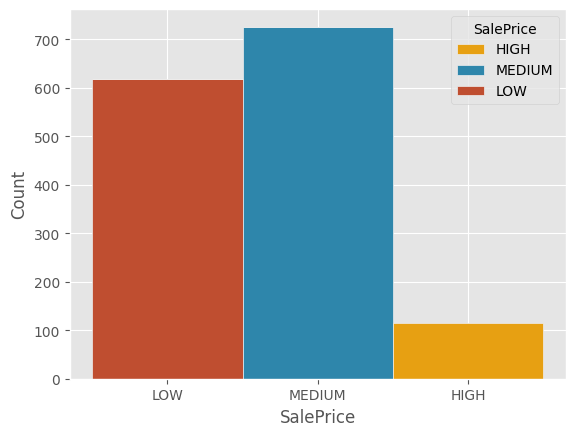

In [425]:
sb.histplot(x = 'SalePrice', multiple='stack', hue = "SalePrice",  data = df, hue_order = hue_order, palette = palette, alpha=1)
df["SalePrice"].value_counts()

SalePrice
MEDIUM    726
HIGH      726
LOW       619
Name: count, dtype: int64

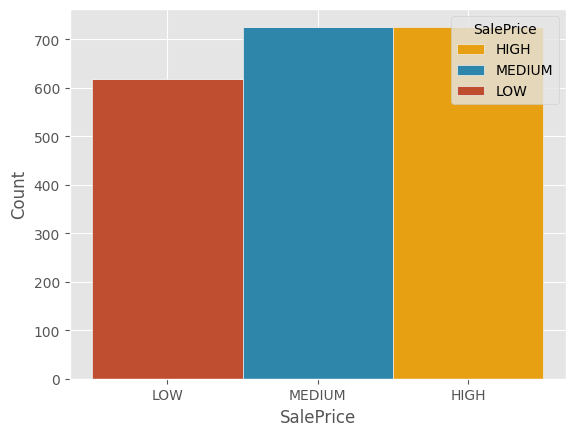

In [426]:
sb.histplot(x = 'SalePrice', multiple='stack', hue = "SalePrice",  data = df_resample, hue_order = hue_order, palette = palette, alpha=1)
df_resample["SalePrice"].value_counts()

### Undestanding the effect of the attributes

##### ID

(array([1., 1., 1., ..., 1., 1., 1.]),
 array([1.00000000e+00, 1.99931507e+00, 2.99863014e+00, ...,
        1.45800137e+03, 1.45900068e+03, 1.46000000e+03]),
 <BarContainer object of 1460 artists>)

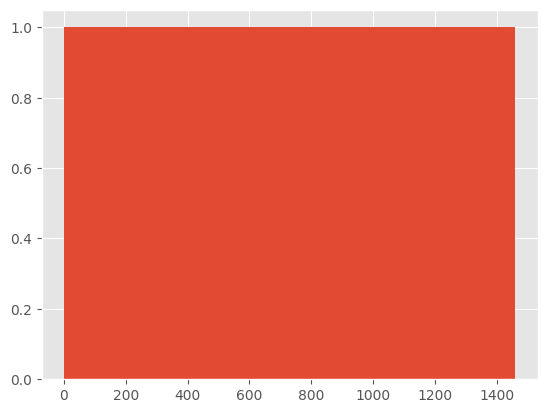

In [427]:
plt.hist(df["Id"], bins= len(df))

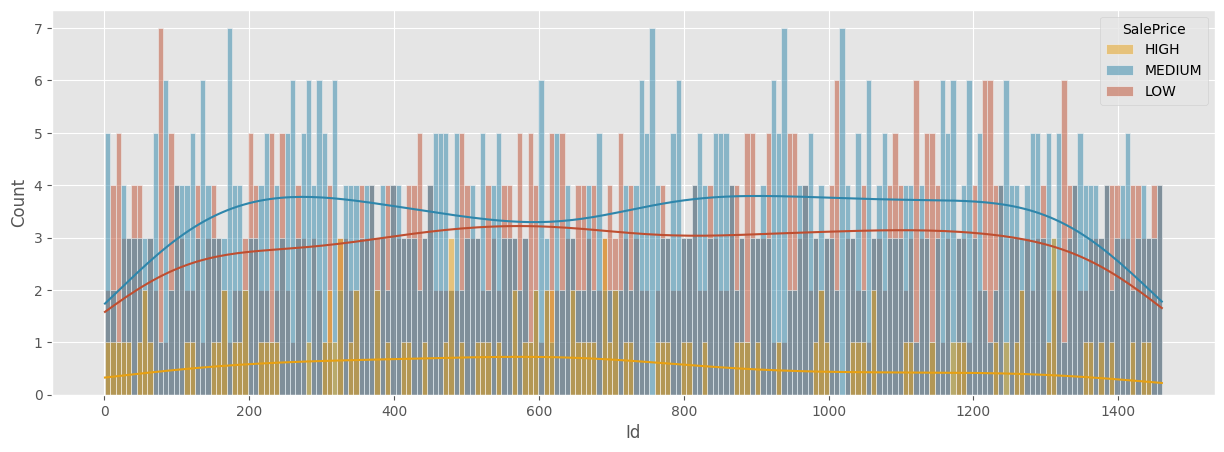

In [428]:
histplot(df,'SalePrice',"Id")

In [429]:
print("Max Entropy ( Log n ) -> " + str(math.log(len(df), 2)))

counts = df['Id'].value_counts()
probs = counts / len(df)
e = -np.sum(probs * np.log2(probs))
print("Entropy -> "+ str(e))

Max Entropy ( Log n ) -> 10.51175265376738
Entropy -> 10.511752653767381


##### MSSubClass

In [430]:
df_copy["MSSubClass"] = df_copy["MSSubClass"].astype("category")

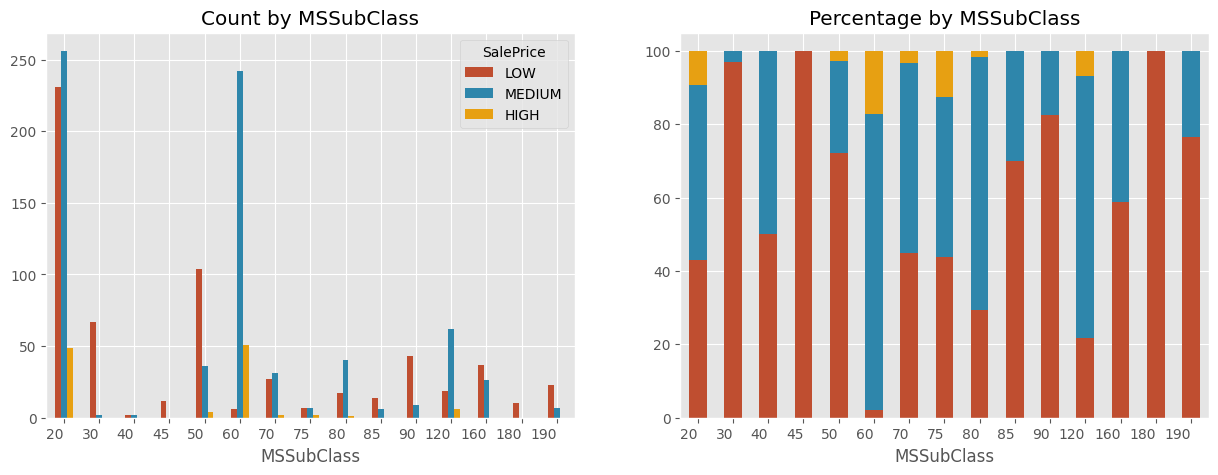

In [431]:
frequencies_and_percentages(df_copy, 'SalePrice', 'MSSubClass')

In [432]:
IG(df,"SalePrice","MSSubClass")

c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python3

0.28611883641757957

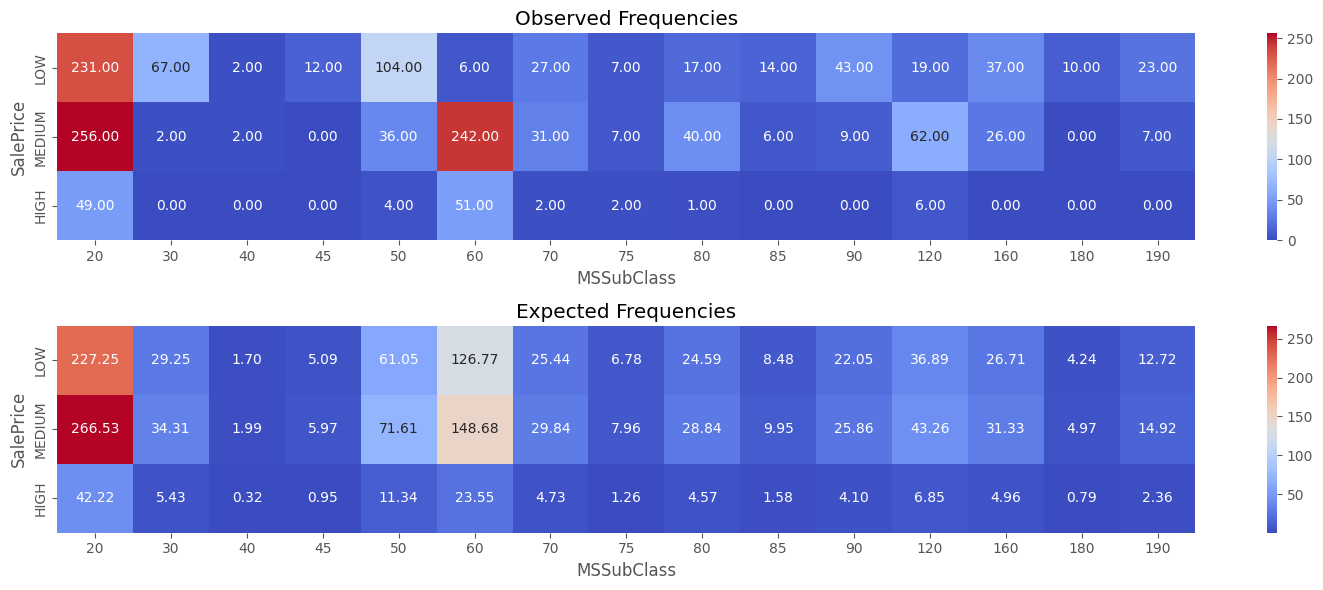

Chi-square Test - Outcome
P-Value: 1.122234664911419e-81 [<0.05]
Cramer's V - Outcome
Coeff: 0.4010822438878207


(1.122234664911419e-81, '[<0.05]')

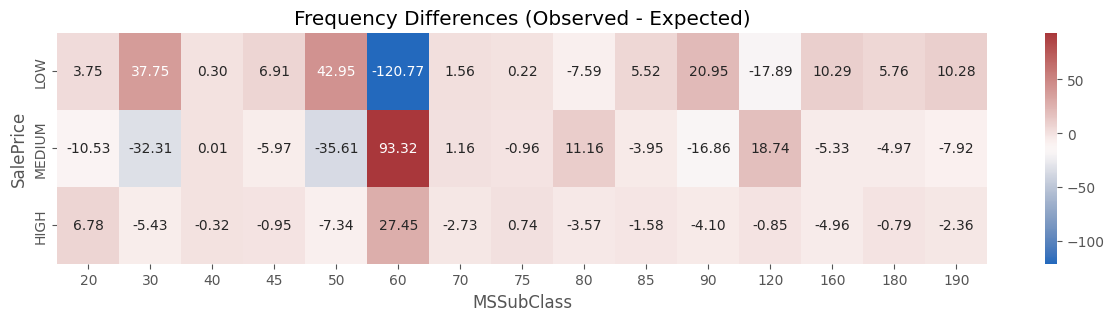

In [433]:
# Indepence test

stattest_quali(df, 'MSSubClass')

##### MSZoning

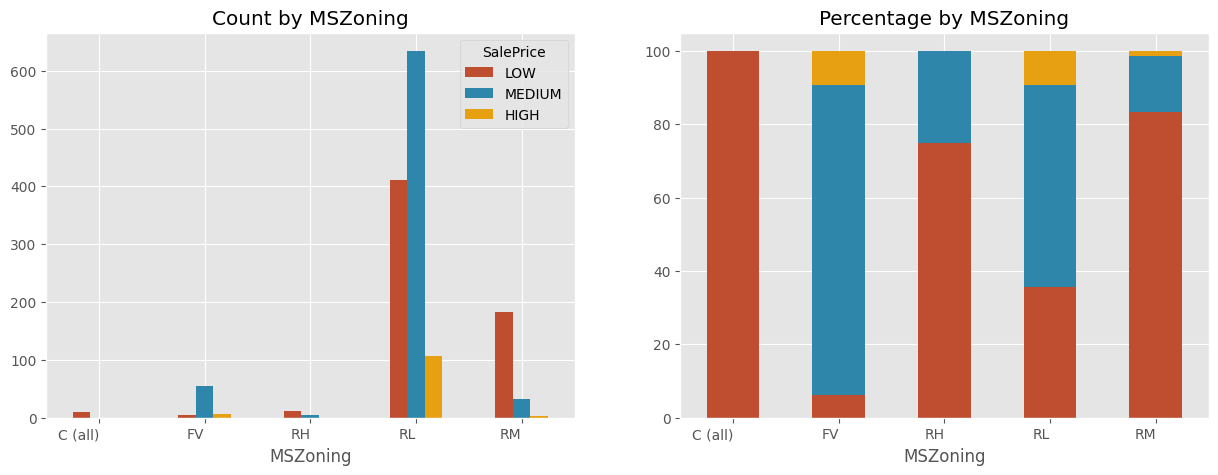

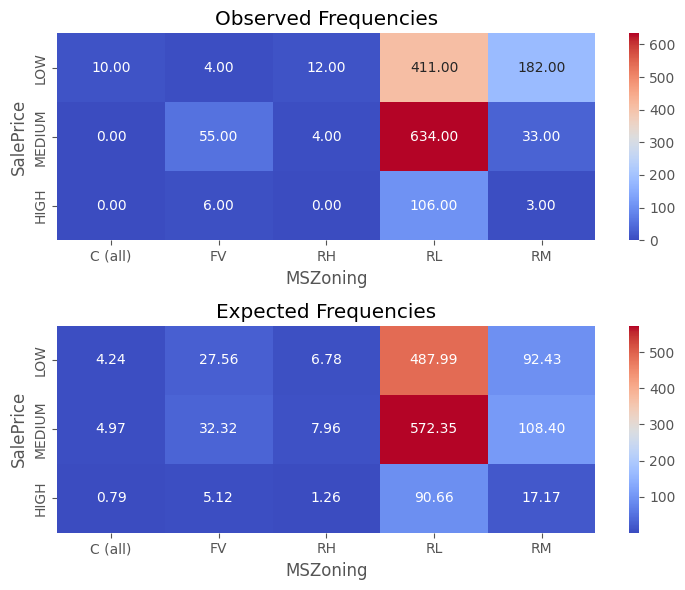

Chi-square Test - Outcome
P-Value: 4.034588700502159e-45 [<0.05]
Cramer's V - Outcome
Coeff: 0.28026704153692883
Understanding MSZoning:
	Missing values: 0
	Independence Test: 4.03e-45[<0.05]
	Information Gain: 0.12
	When the MSZoning is:
		• C (all), then the sale price is LOW (0.68% of the times)
		• FV, then the sale price is 80% likely to be MEDIUM (4.45% of the times)
		• RM, then the sale price is 80% likely to be LOW (14.93% of the times)
		• RH, then the sale price is 75% likely to be LOW (1.10% of the times)
		• RL, then the sale price is 55% likely to be MEDIUM (78.84% of the times)




c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


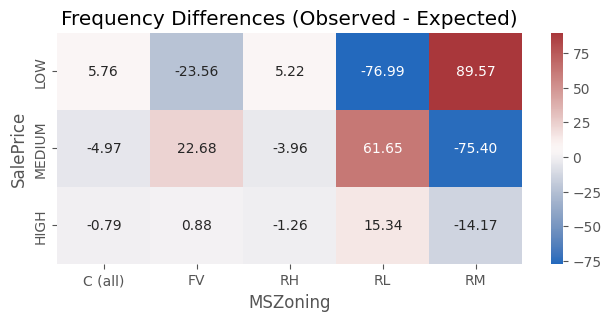

In [434]:
understand(dataf=df_copy, feature_name='MSZoning')   

##### LotFrontage

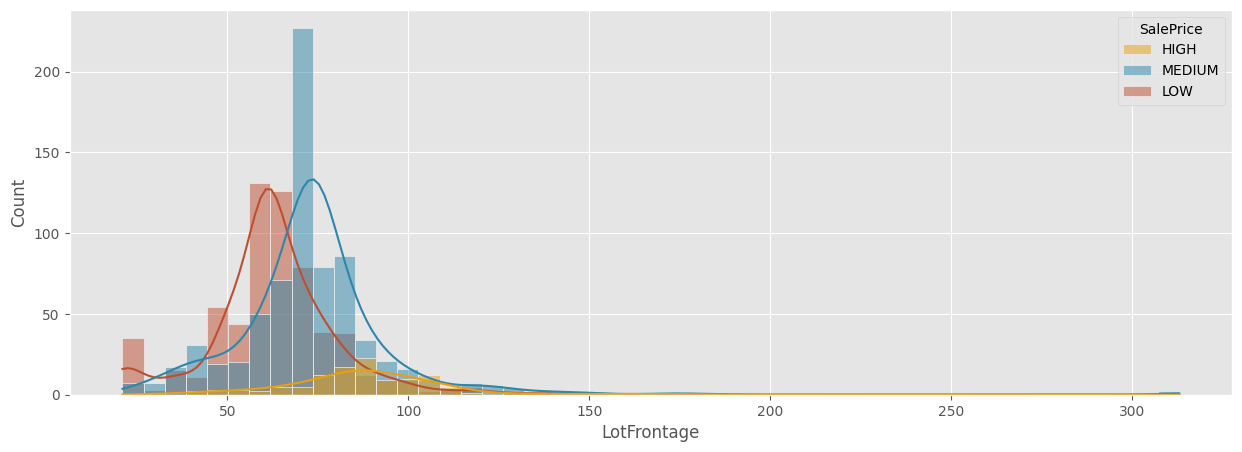

In [435]:
set_means(df_copy,'LotFrontage')
histplot(df_copy,'SalePrice',"LotFrontage", multiple='layer', bins=50, alpha=0.5)


##### LotArea

Understanding LotArea:
	Missing values: 0
	Independence Test: 2.90e-18[<0.05]
	Correlation Index: 0.26
	Correlation p_value: 1.12e-24



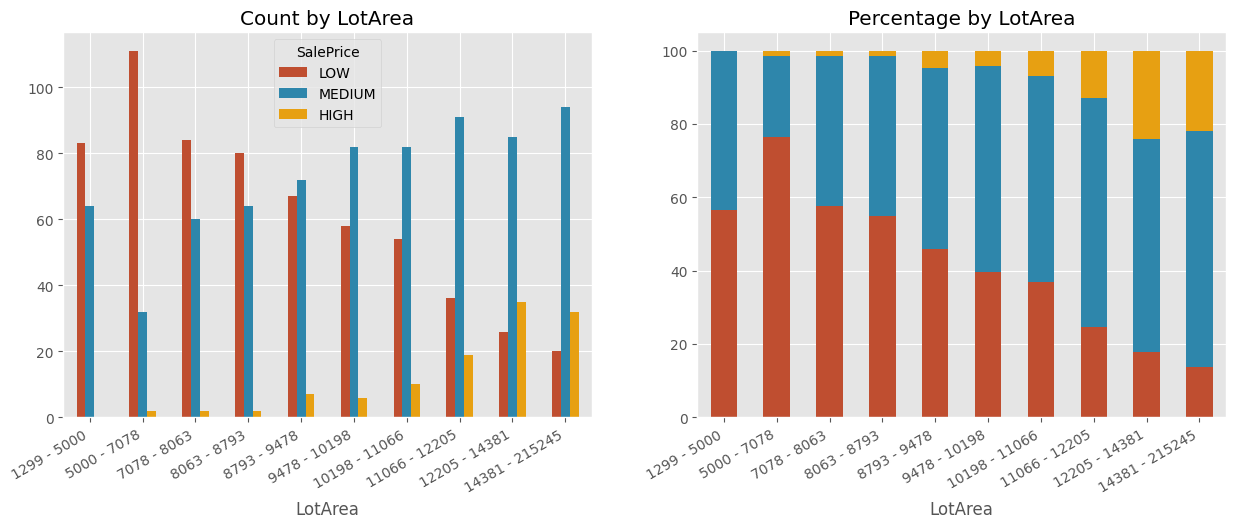

In [436]:
# As we can see from the graphs, the l the lot area the higher the price of the house.
# We think that it is useful to split the values of the attribute into bins.
frequencies_and_percentages_numeric(df, 'SalePrice', 'LotArea', rotation=30, bin = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
understand(dataf=df_copy, feature_name='LotArea', dtype='int',showplots=False, upper_limit=20000)

##### Street

Street
Pave    1454
Grvl       6
Name: count, dtype: int64


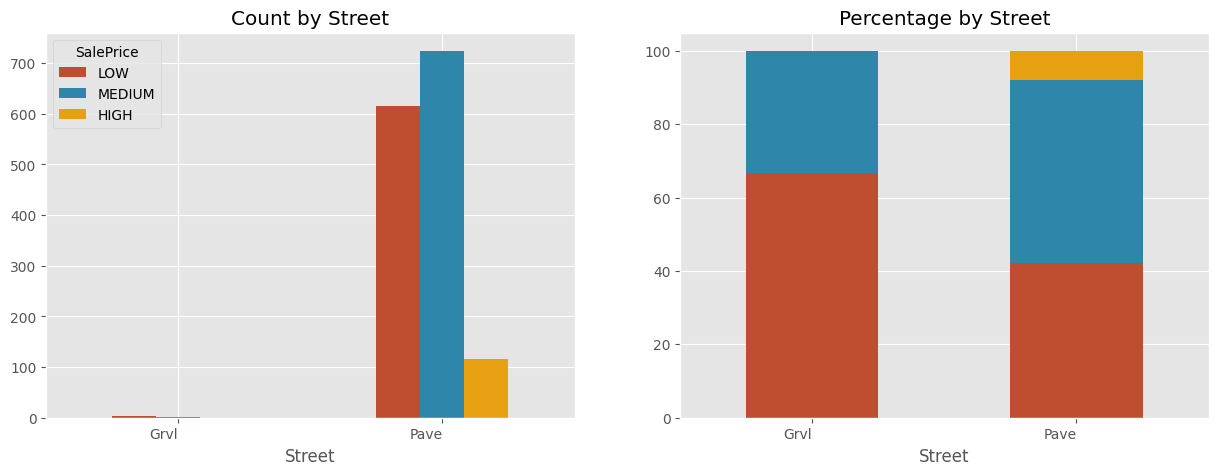

In [437]:
#Given that the training is strongly unbalanced
df_copy['Street'] = df['Street'].astype('category')
category_common_analysis(data=df_copy, x='Street',target='SalePrice',histplot=False, palette=palette)

##### Alley

Alley
NA      1369
Grvl      50
Pave      41
Name: count, dtype: int64


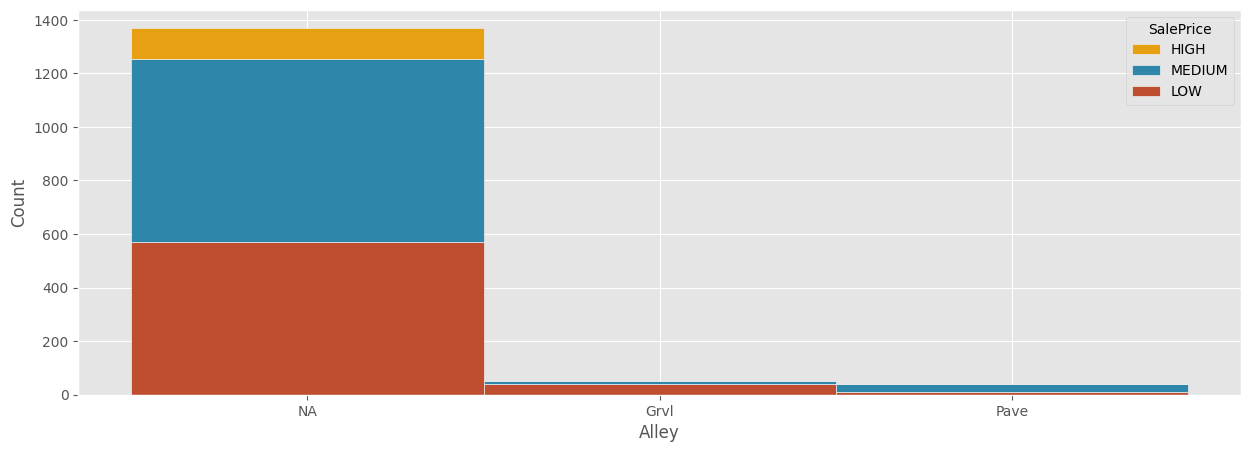

In [438]:
category_common_analysis(data=df, x='Alley',target='SalePrice',percentages=False, palette=palette)

##### LotShape

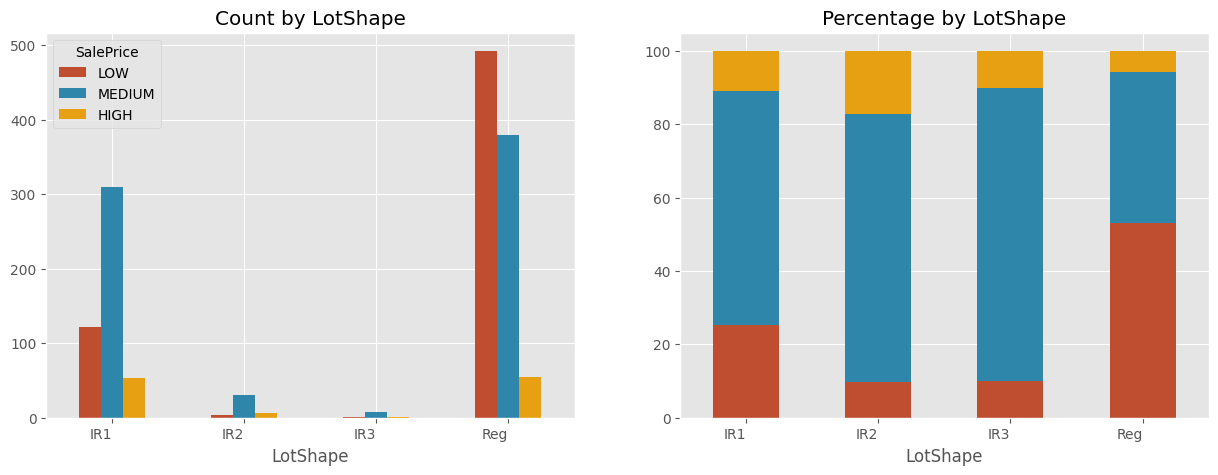

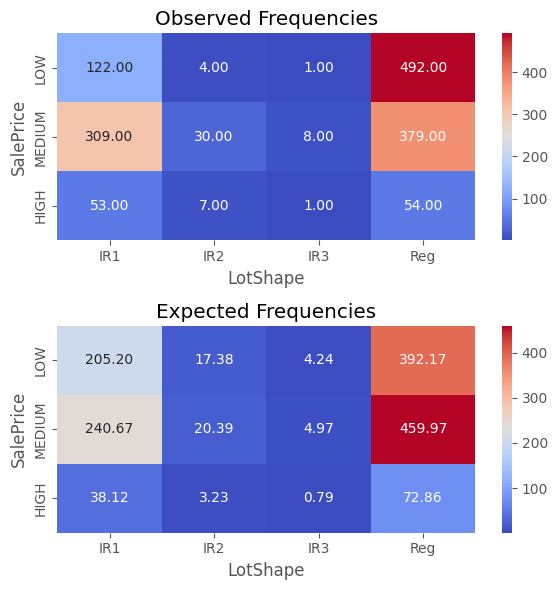

Chi-square Test - Outcome
P-Value: 5.252128283563737e-25 [<0.05]
Cramer's V - Outcome
Coeff: 0.20862876181781315
Understanding LotShape:
	Missing values: 0
	Independence Test: 5.25e-25[<0.05]
	Information Gain: 0.07
	When the LotShape is:
		• IR3, then the sale price is 80% likely to be MEDIUM (0.68% of the times)
		• IR2, then the sale price is 70% likely to be MEDIUM (2.81% of the times)
		• IR1, then the sale price is 60% likely to be MEDIUM (33.15% of the times)
		• Reg, then the sale price is 50% likely to be LOW (63.36% of the times)




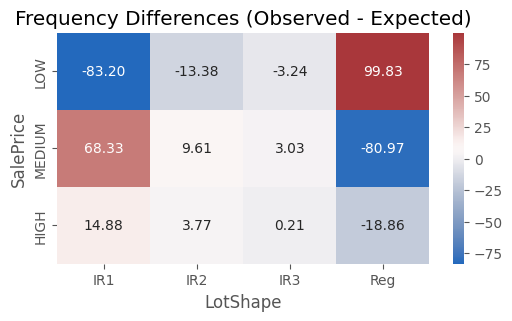

In [439]:

# to be verified with chi-squared test
# IR2 and IR3 can be aggregated in a new category
#we can see that in proportion R1 and Reg can be significantly different
understand(dataf=df_copy,feature_name='LotShape')

##### LandContour

LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64


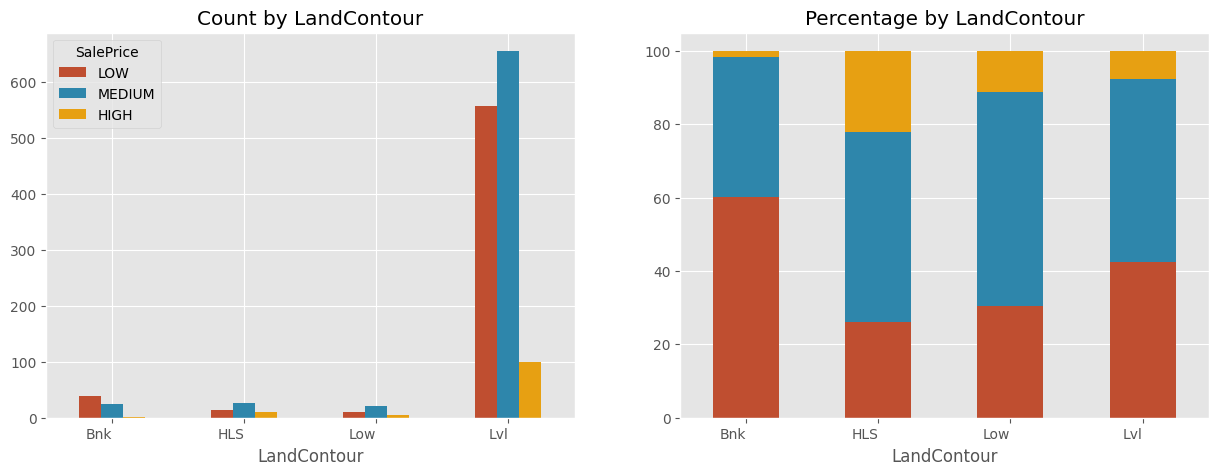

In [440]:
# maybe not enough values for a good model, we do not know if they are significant
category_common_analysis(data=df, x='LandContour',target='SalePrice', palette=palette, histplot=False)

##### Utilities

Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64


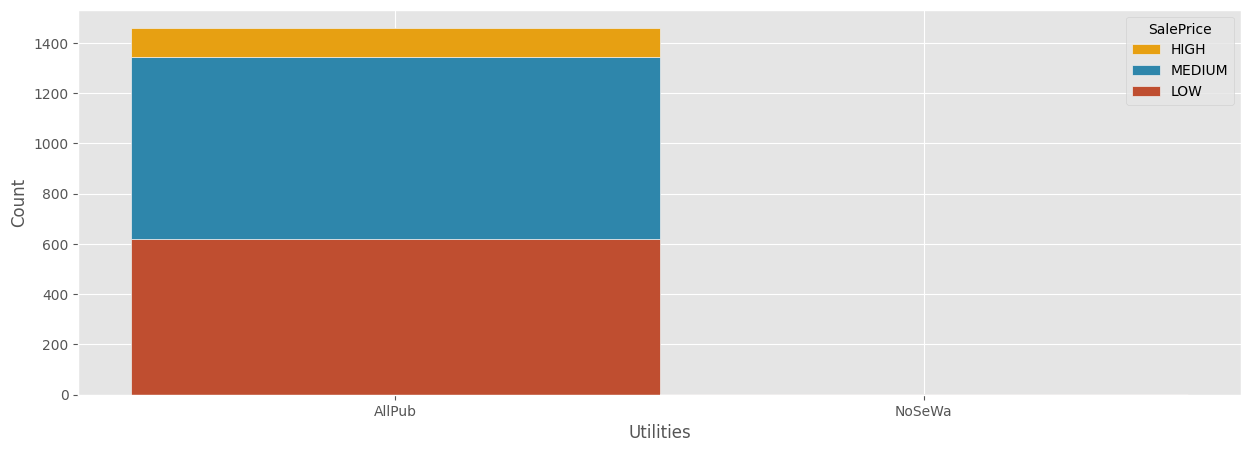

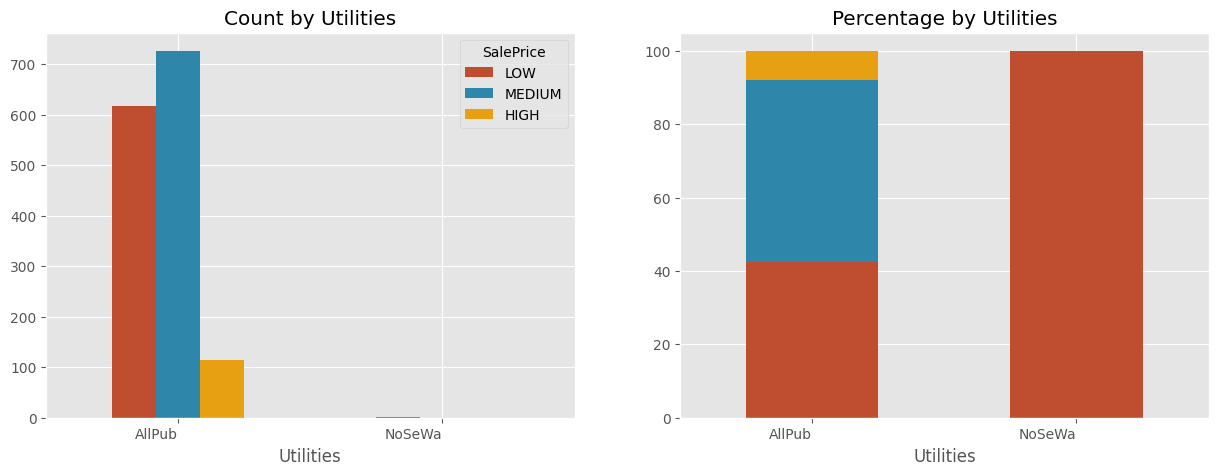

In [441]:
# All the houses (except one) have all the utilies
#Although it is considered to be a useful element, we cannot use this attribute.
category_common_analysis(data=df, x='Utilities',target='SalePrice', palette=palette)

##### LotConfig

LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: count, dtype: int64


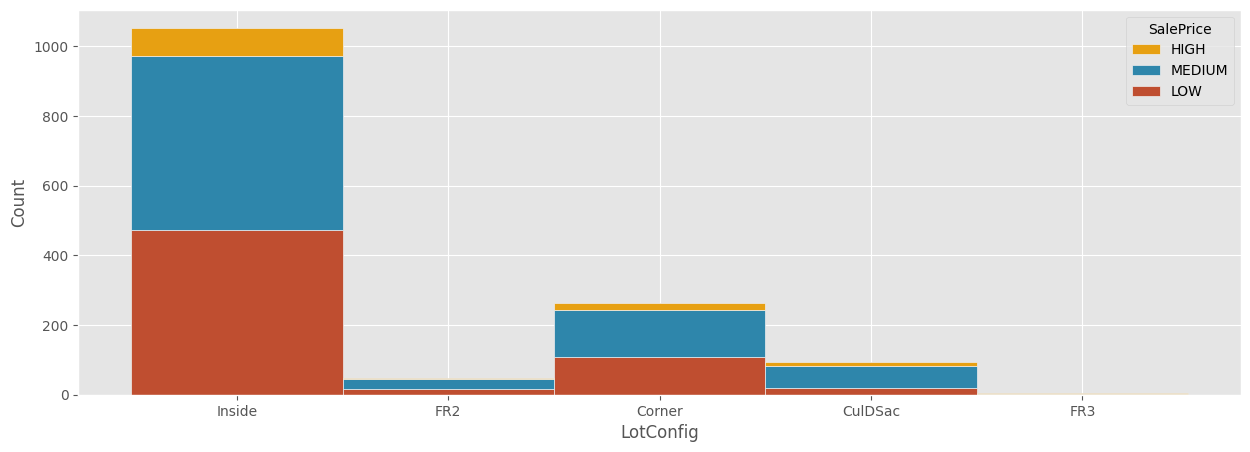

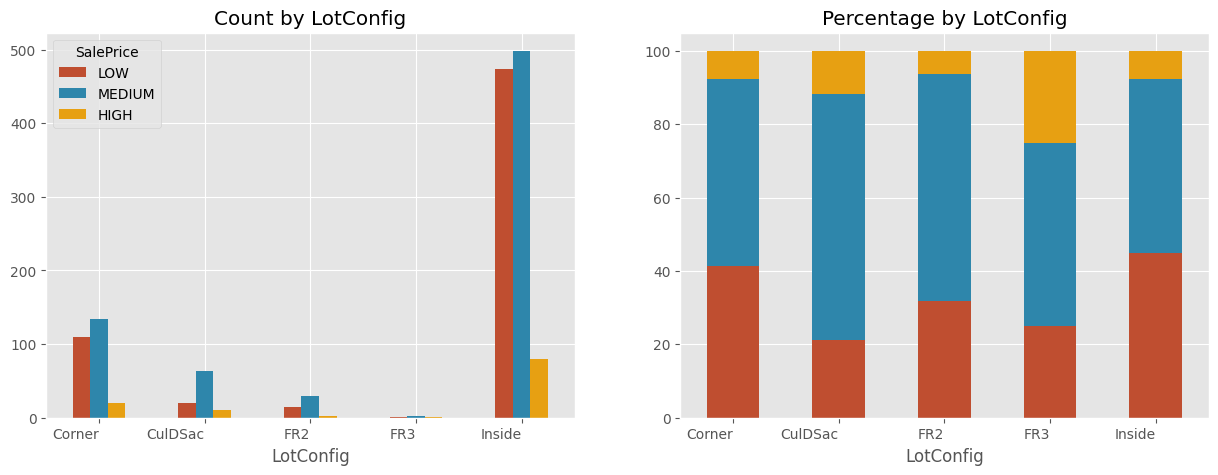

In [442]:
#it can be seen that for some values there are not enough sample, however it seems that the other attributes have a similar distribution
#The attribute can be removed since it would not be useful to the model

category_common_analysis(data=df, x='LotConfig',target='SalePrice', palette=palette)

##### LandSlope

LandSlope
Gtl    1382
Mod      65
Sev      13
Name: count, dtype: int64


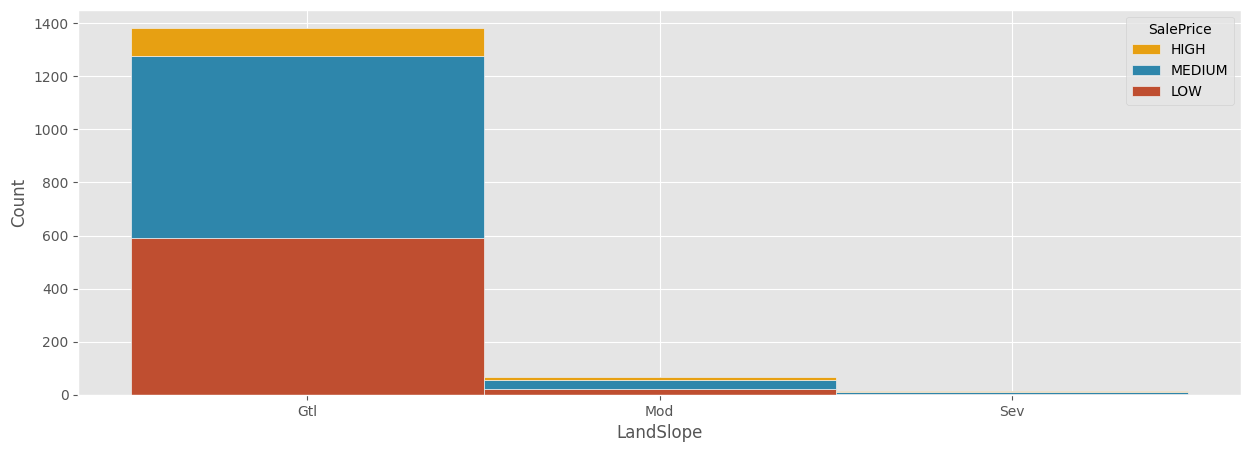

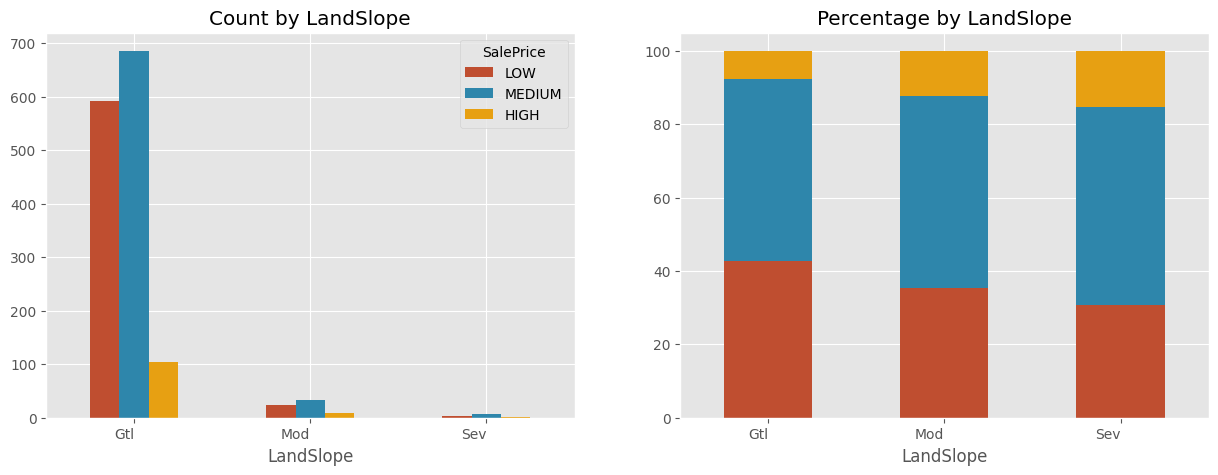

In [443]:
#la pendenza del terreno non dovrebbe influenzare il livello della proprietà
#Troppi pochi campioni
category_common_analysis(data=df, x='LandSlope',target='SalePrice', palette=palette)

##### Neighborhood

Null values: 0
Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
Other       72
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
Name: count, dtype: int64
Understanding Neighborhood:
	Missing values: 0
	Independence Test: 4.65e-182[<0.05]
	Information Gain: 0.46
	When the Neighborhood is:
		• IDOTRR, then the sale price is 90% likely to be LOW (2.53% of the times)
		• Gilbert+NWAmes, then the sale price is 90% likely to be MEDIUM (10.41% of the times)
		• BrkSide+Edwards+OldTown, then the sale price is 80% likely to be LOW (18.56% of the times)
		• ClearCr+Somerst, then the sale price is 80% likely to be MEDIUM (7.81% of the times)
		• Sawyer, then the sale price is 75% likely to be LOW (5.07% of the times)
		• Timber, then the sale price is 75% likely to be MEDIUM (2.60% of the times)
		• 

c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python3

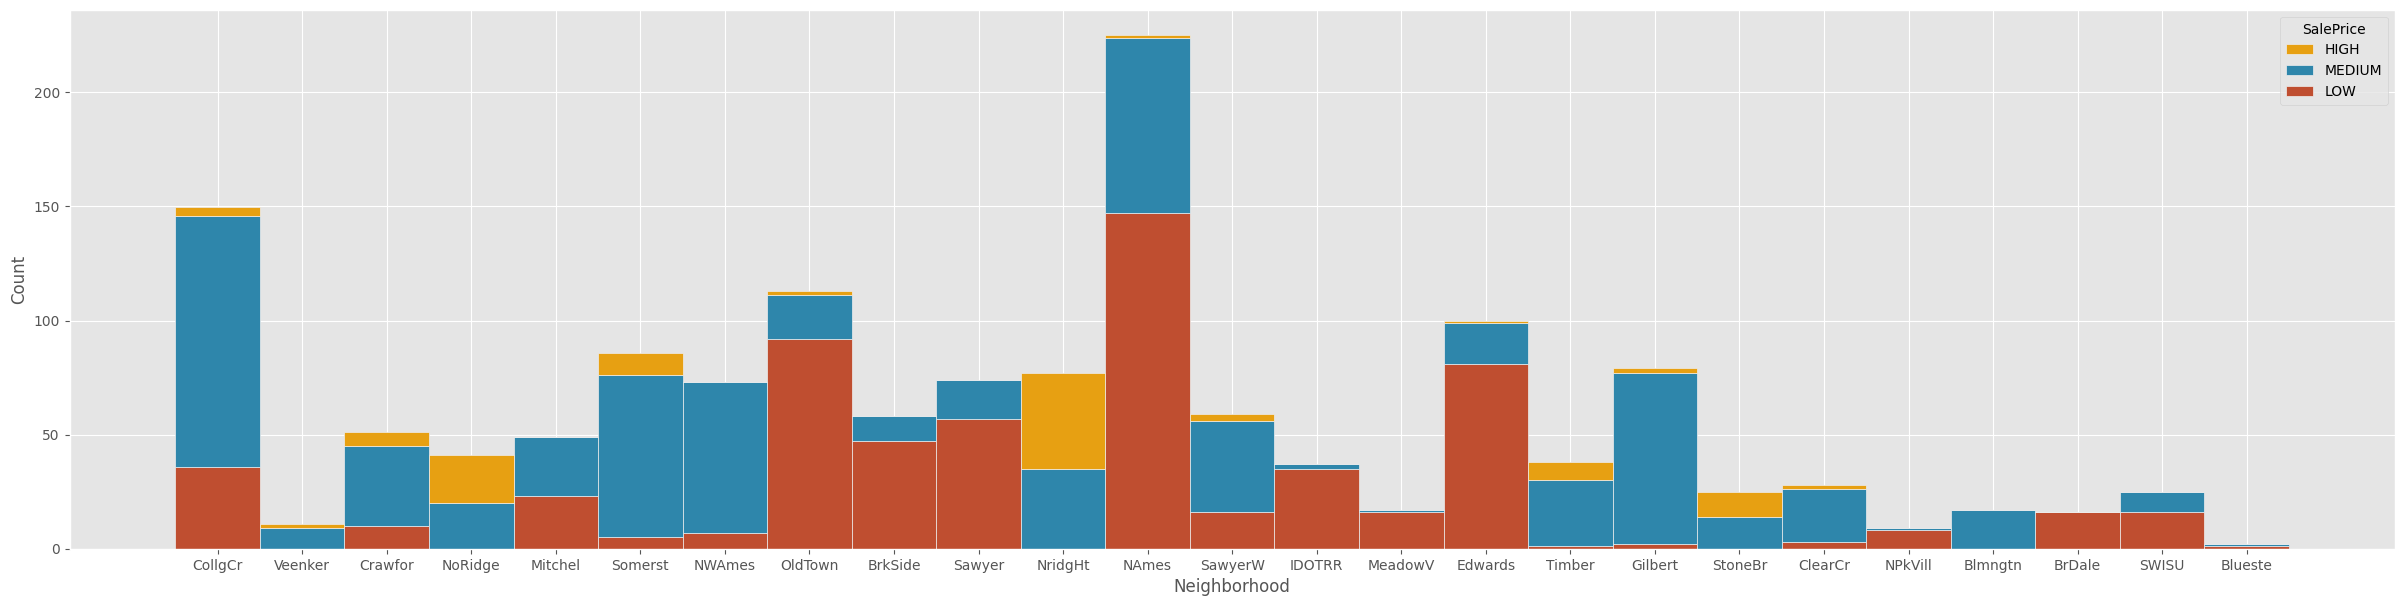

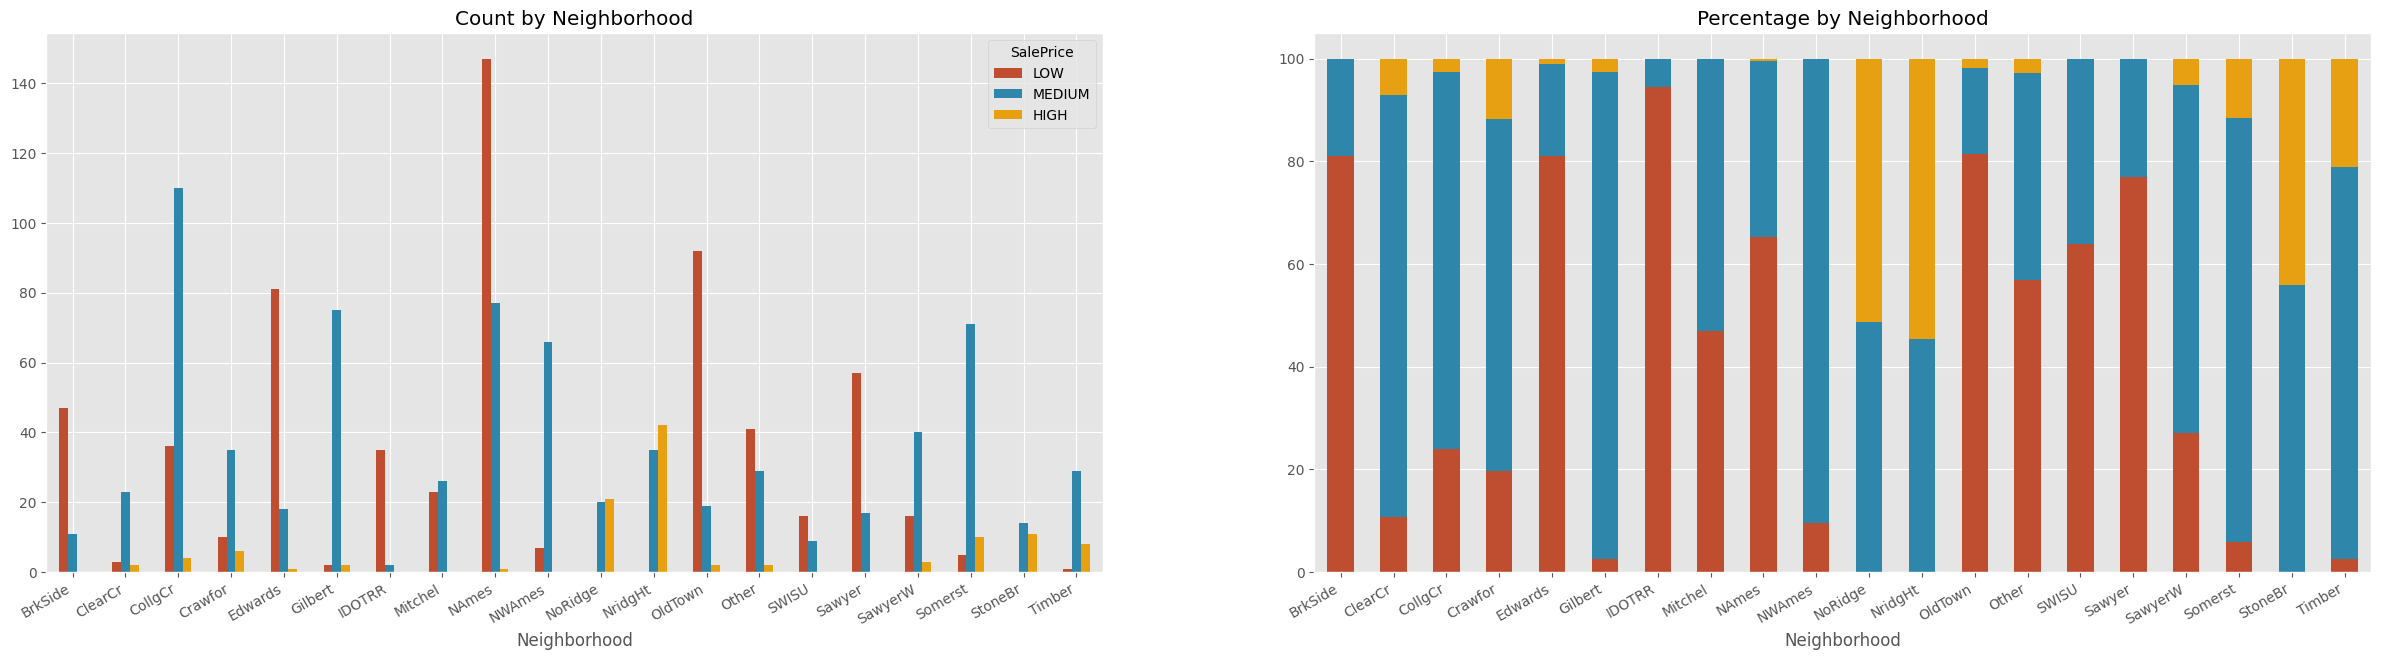

In [444]:
print(f"Null values: {df['Neighborhood'].isna().sum()}")
plt.figure(figsize = (30,7))
df_copy

sb.histplot(x = df['Neighborhood'], multiple='stack', hue = df.SalePrice,  data = df['Neighborhood'], hue_order = hue_order, palette = palette, alpha=1)
df_copy = aggregate(df = df_copy, attribute='Neighborhood', new_name="Other", threshold=20)
category_common_analysis(data=df_copy, x='Neighborhood',target='SalePrice', rotation=30, palette=palette, figsize=(30,7), histplot=False)
understand(dataf=df_copy, feature_name='Neighborhood',showplots=False)

##### Condition1

Condition1
Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: count, dtype: int64


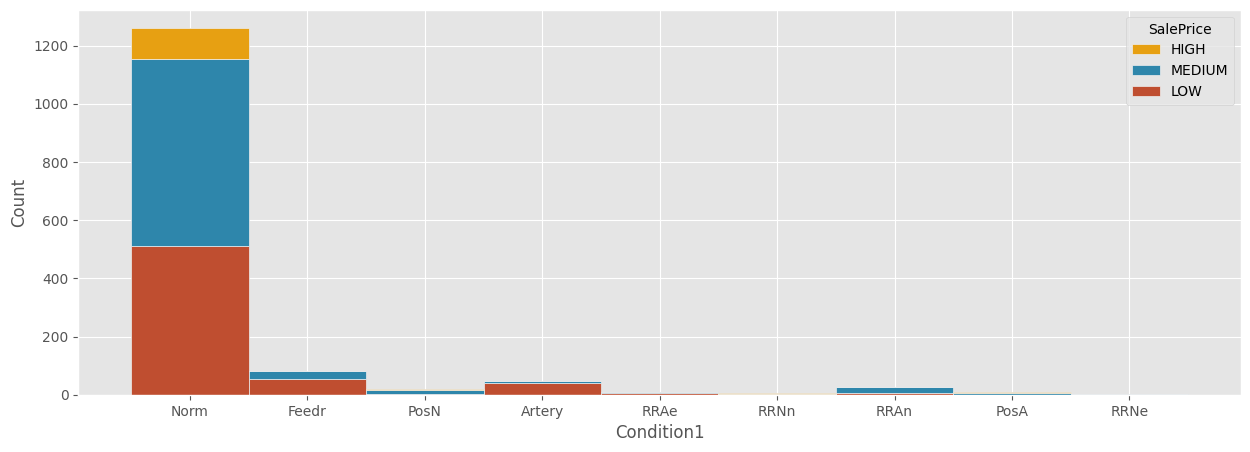

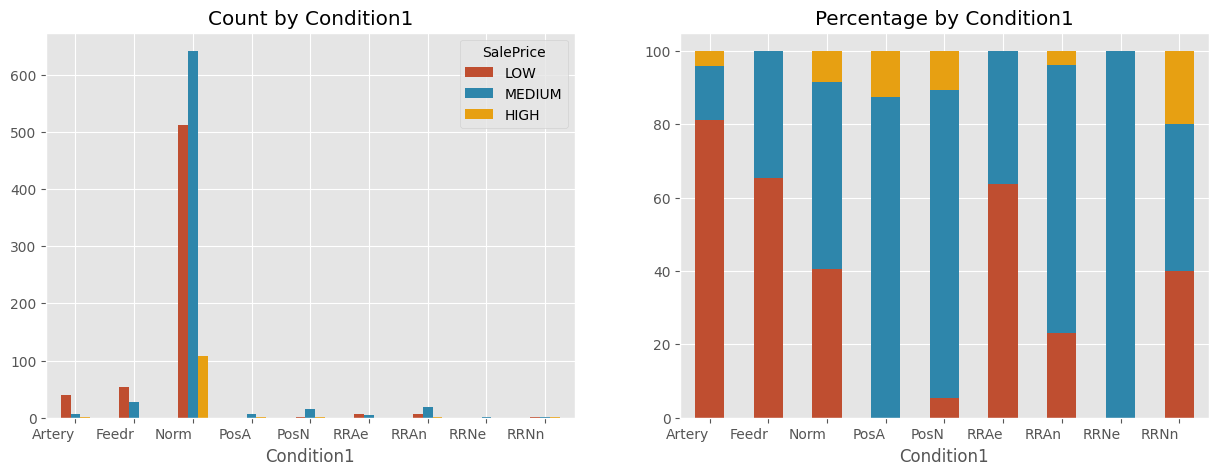

In [445]:
#The values for this attribute are strongly unbalanced among the categories inside the training set.
#As we can see from the barplot with percentages there is not a marked trend.
category_common_analysis(data=df, x='Condition1',target='SalePrice', palette=palette)

##### Condition2

Condition2
Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: count, dtype: int64


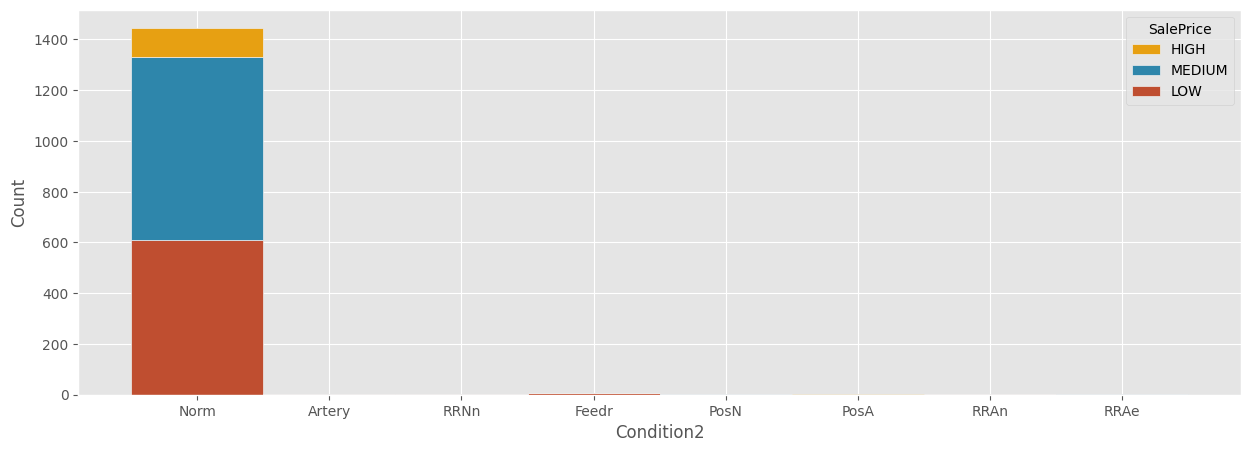

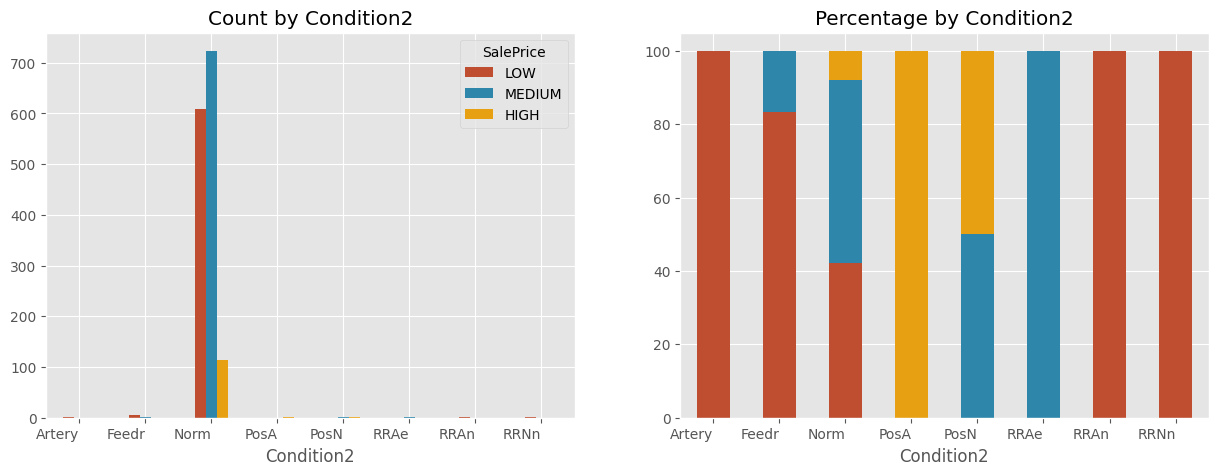

In [446]:
# Same reasoning as for Condition1
category_common_analysis(data=df, x='Condition2',target='SalePrice', palette=palette)

##### BldgType

BldgType
1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: count, dtype: int64


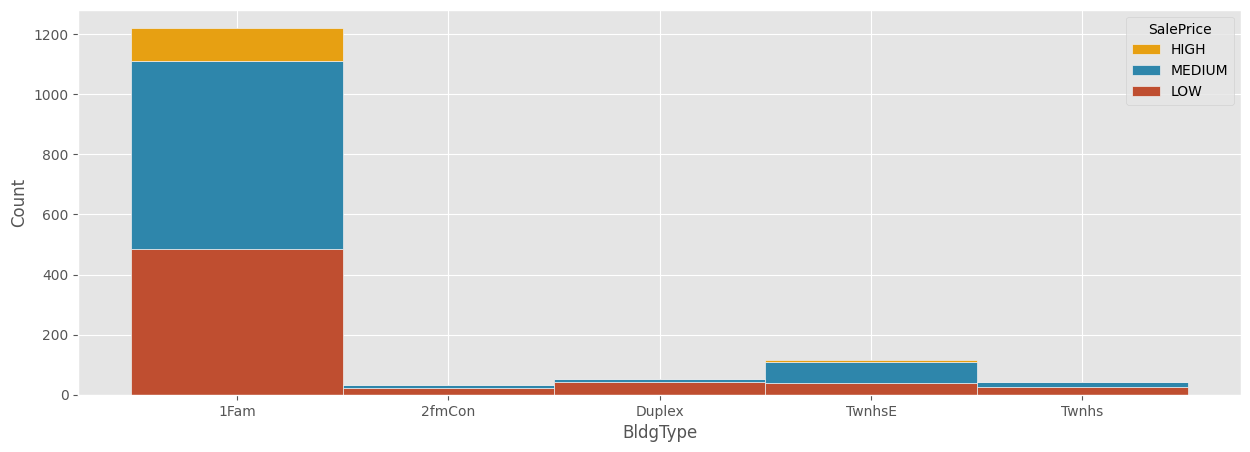

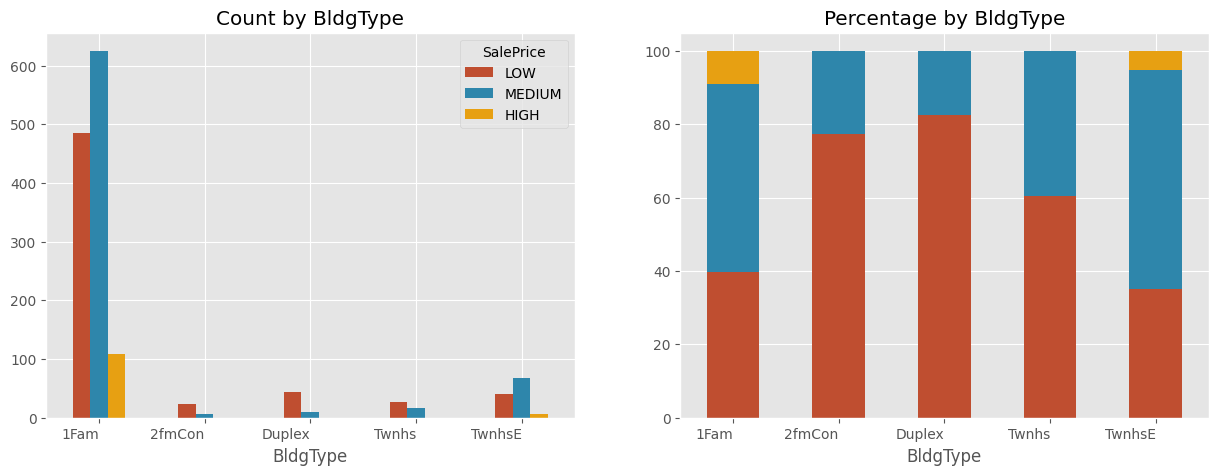

In [447]:
category_common_analysis(data=df, x='BldgType',target='SalePrice', palette=palette)

##### HouseStyle

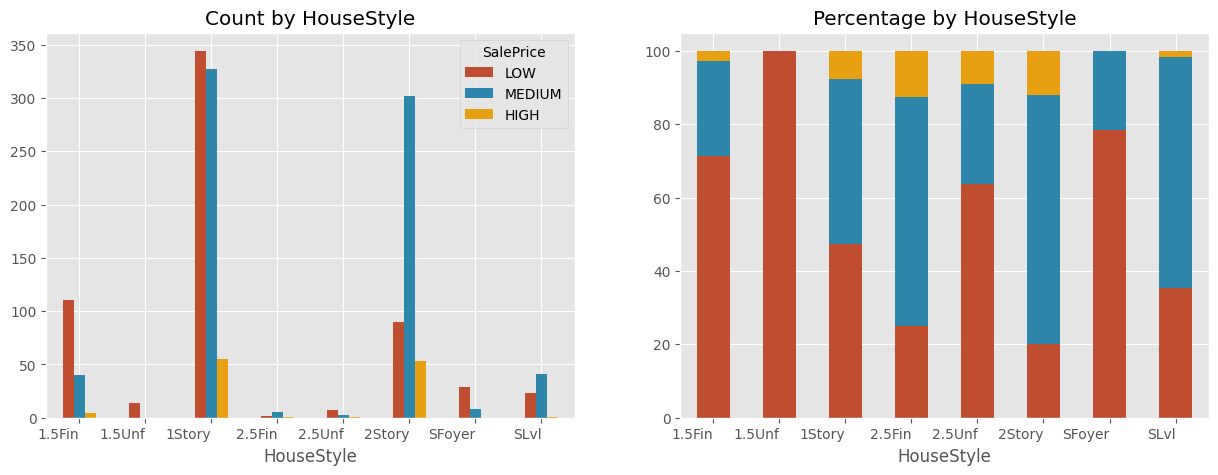

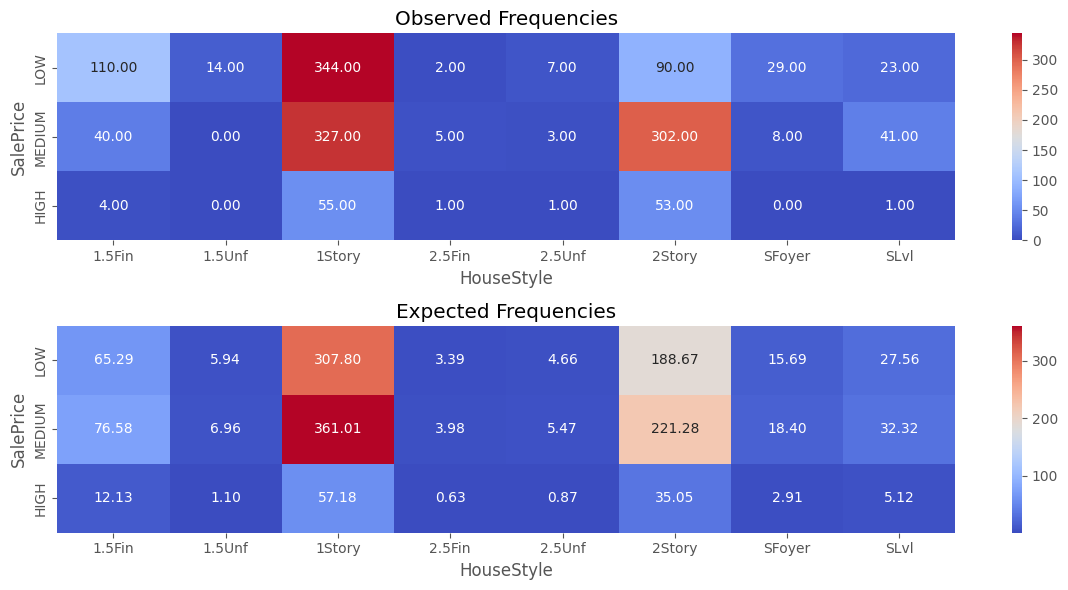

Chi-square Test - Outcome
P-Value: 5.042764923498675e-35 [<0.05]
Cramer's V - Outcome
Coeff: 0.26183088220958667
Understanding HouseStyle:
	Missing values: 0
	Independence Test: 5.04e-35[<0.05]
	Information Gain: 0.11
	When the HouseStyle is:
		• 1.5Unf, then the sale price is LOW (0.96% of the times)
		• SFoyer, then the sale price is 75% likely to be LOW (2.53% of the times)
		• 1.5Fin, then the sale price is 70% likely to be LOW (10.55% of the times)
		• 2Story, then the sale price is 65% likely to be MEDIUM (30.48% of the times)
		• 2.5Unf, then the sale price is 60% likely to be LOW (0.75% of the times)
		• 2.5Fin+SLvl, then the sale price is 60% likely to be MEDIUM (5.00% of the times)
		• 1Story, then the sale price is 45% likely to be LOW (49.73% of the times)




c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


HouseStyle
1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: count, dtype: int64

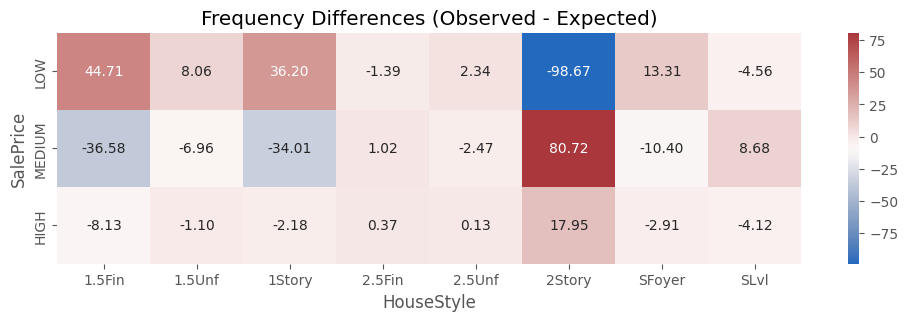

In [448]:
#As we can see from the plots here there is a significant correlation between the style of the house and the price.
#In particular, as the number of floors increases the SalePrice also increases
# category_common_analysis(data=df, x='HouseStyle',target='SalePrice', palette=palette, figsize=(30,7))
understand(dataf=df_copy, feature_name='HouseStyle')
df_copy["HouseStyle"].value_counts()

##### OverallQual

OverallQual
5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: count, dtype: int64


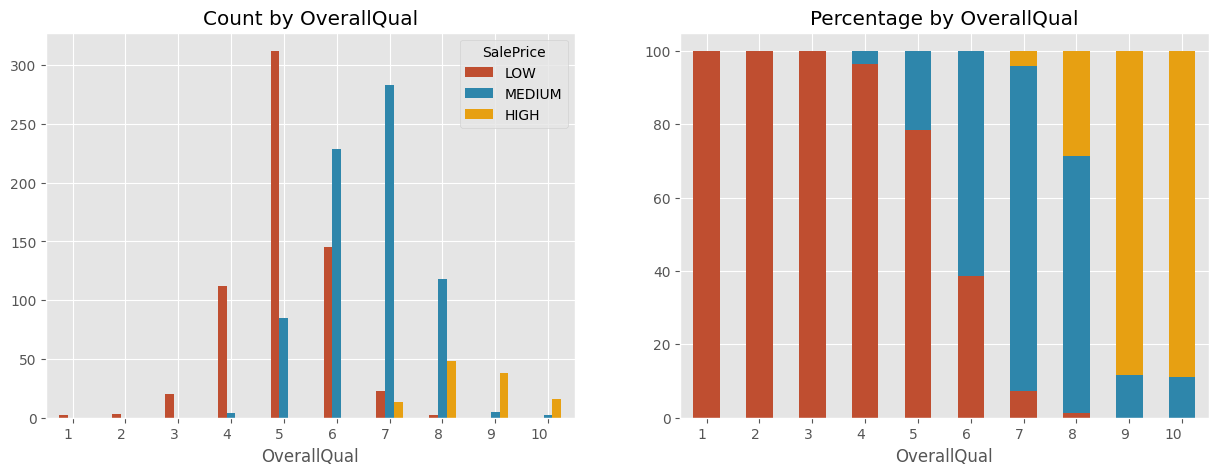

In [449]:
#In this case the trend is evident: the higher the overall quality of the house the higher the sale price
print(df['OverallQual'].value_counts())
frequencies_and_percentages(df, 'SalePrice', 'OverallQual')

##### OverallCond

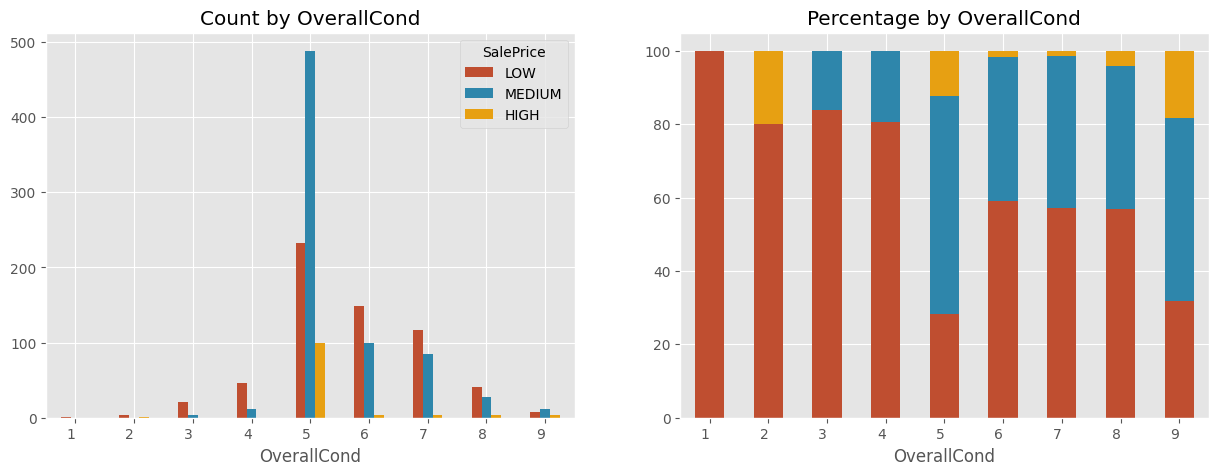

In [450]:
#In this case the trend is not so marked and probably is conditioned by the fact that
#of the houses are spread across only three of the nine possible values for this attribute
frequencies_and_percentages(df, 'SalePrice', 'OverallCond')

##### YearBuilt

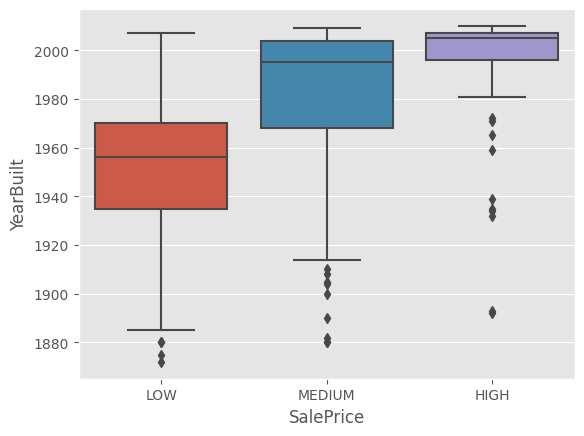

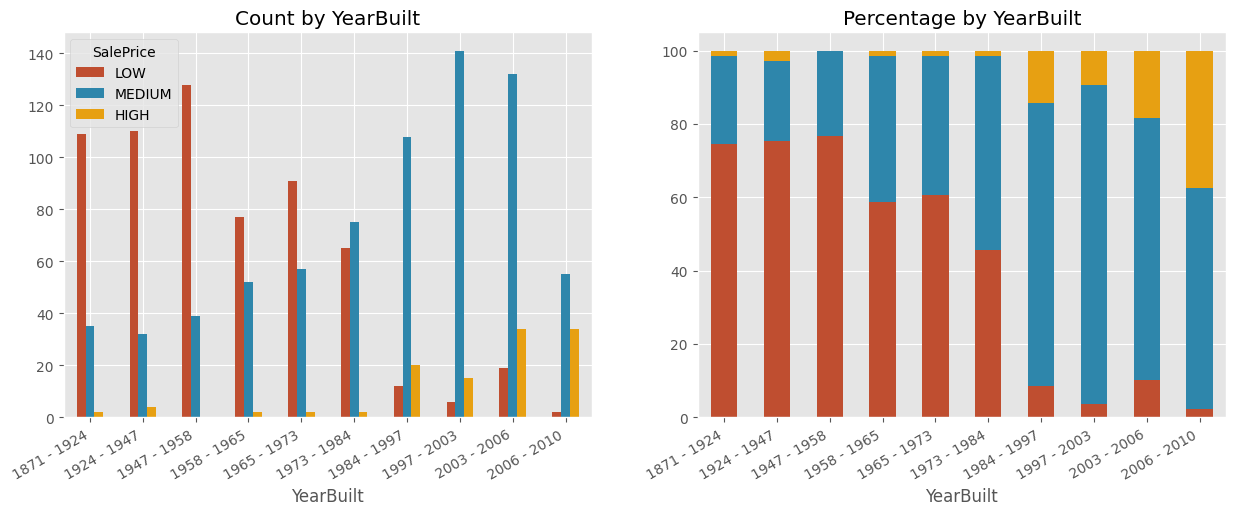

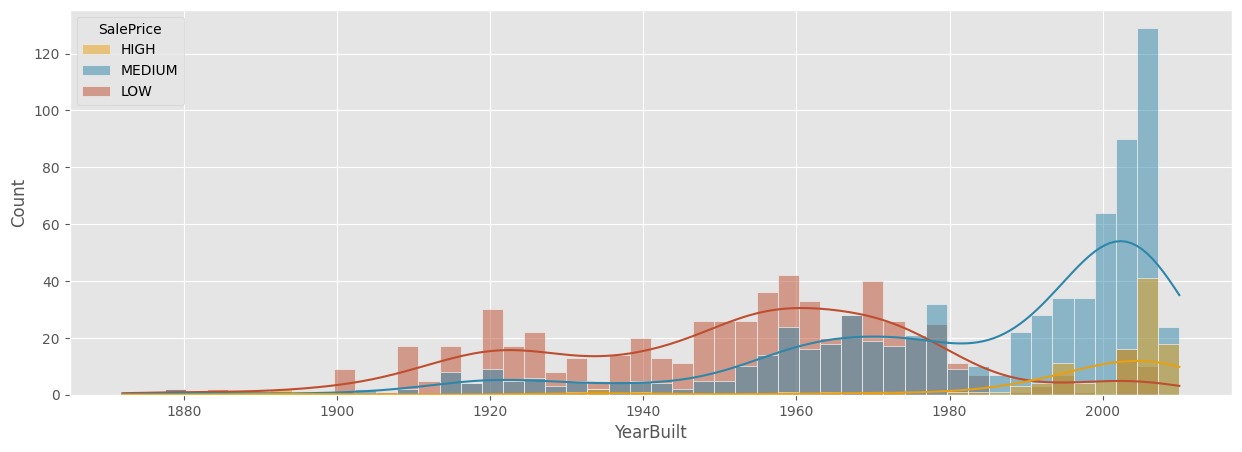

Understanding YearBuilt:
	Missing values: 0
	Independence Test: 3.64e-118[<0.05]
	Correlation Index: 0.52
	Correlation p_value: 2.99e-103



In [451]:
#As we can see, the older the house the lower the associated SalePrice.
#Moreover, for this attribute we do not have higly skewed or non uniform distribution like we had for several other attributes
sb.boxplot(data=df, y="YearBuilt", x="SalePrice")
frequencies_and_percentages_numeric(df, 'SalePrice', 'YearBuilt', rotation=30, bin=10)
understand(dataf=df_copy, feature_name='YearBuilt', dtype='int', low_limit=1900, upper_limit=2023)

##### YearRemodAdd

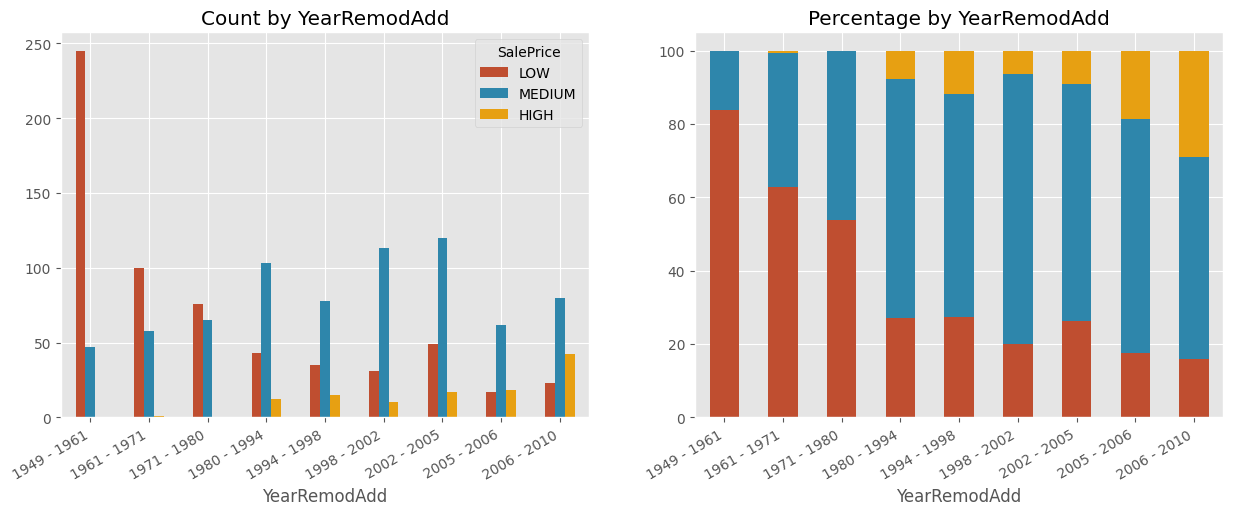

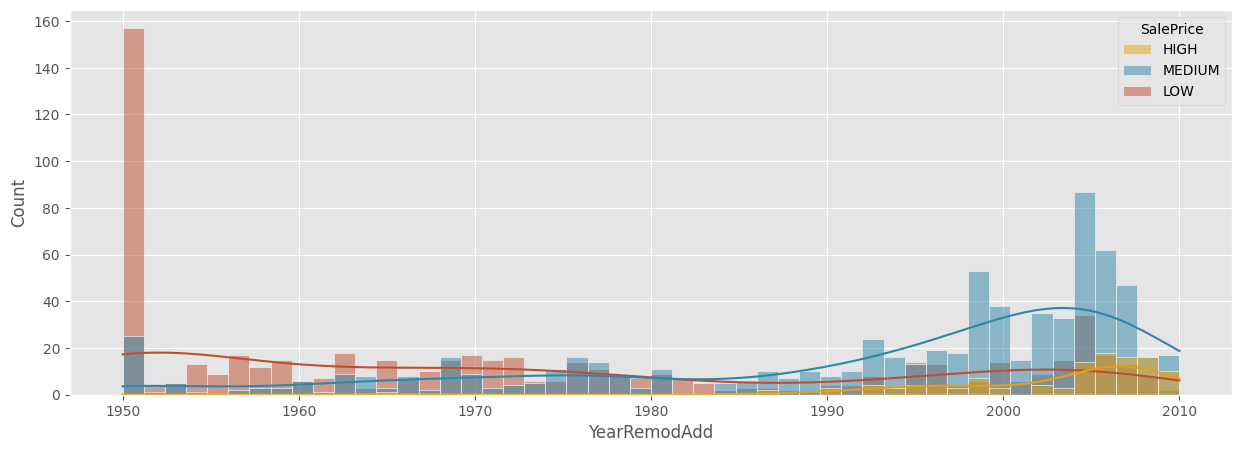

Understanding YearRemodAdd:
	Missing values: 0
	Independence Test: 1.79e-103[<0.05]
	Correlation Index: 0.51
	Correlation p_value: 3.16e-96



In [452]:

frequencies_and_percentages_numeric(df, 'SalePrice', 'YearRemodAdd', rotation=30, bin = [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
understand(dataf=df_copy, feature_name='YearRemodAdd', dtype='int', low_limit=1900, upper_limit=2023)

##### RoofStyle

RoofStyle
Gable    1141
Hip       286
Other      33
Name: count, dtype: int64
Understanding RoofStyle:
	Missing values: 0
	Independence Test: 7.76e-17[<0.05]
	Information Gain: 0.04
	When the RoofStyle is:
		• Shed, then the sale price is MEDIUM (0.14% of the times)
		• Mansard, then the sale price is 70% likely to be MEDIUM (0.48% of the times)
		• Flat, then the sale price is 65% likely to be MEDIUM (0.89% of the times)
		• Gable, then the sale price is 50% likely to be MEDIUM (78.15% of the times)
		• Gambrel, then the sale price is 50% likely to be LOW (0.75% of the times)
		• Hip, then the sale price is 40% likely to be MEDIUM (19.59% of the times)




c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


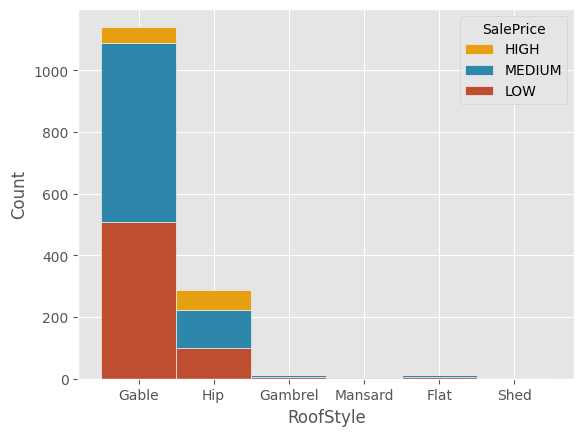

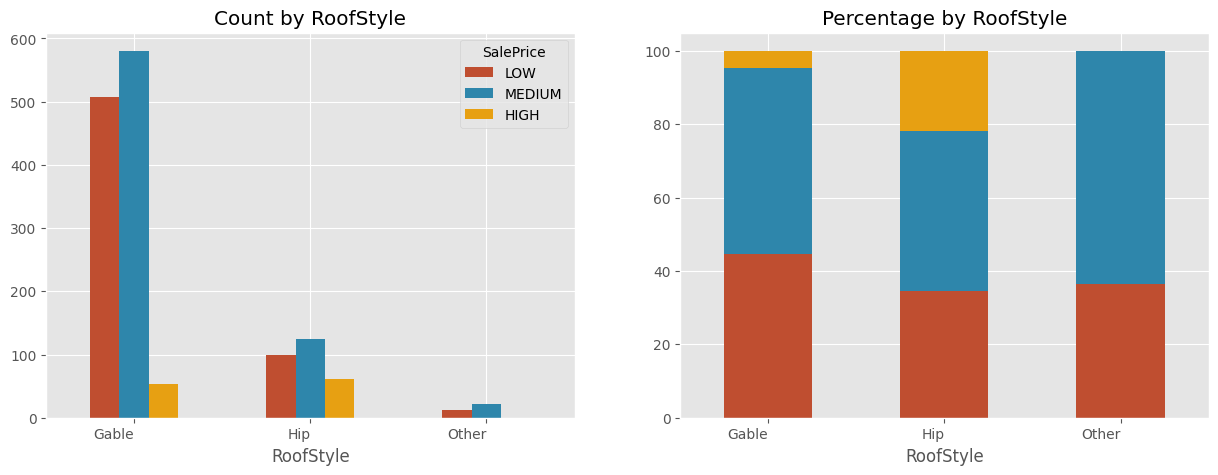

In [453]:
sb.histplot(x = df['RoofStyle'], multiple='stack', hue = df.SalePrice,  data = df['RoofStyle'], hue_order = hue_order, palette = palette, alpha=1)
category_common_analysis(data=aggregate(df = df.copy(), attribute='RoofStyle', new_name="Other", threshold=20), x='RoofStyle', histplot=False,target='SalePrice', palette=palette)
understand(dataf=df_copy, feature_name='RoofStyle', dtype='category', showplots=False)

##### RoofMatl

RoofMatl
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: count, dtype: int64
Understanding RoofMatl:
	Missing values: 0
	Independence Test: 1.93e-02[<0.05]
	Information Gain: 0.01
	When the RoofMatl is:
		• Roll, then the sale price is LOW (0.07% of the times)
		• ClyTile+Membran+Metal+WdShake, then the sale price is MEDIUM (0.55% of the times)
		• Tar&Grv, then the sale price is 60% likely to be MEDIUM (0.75% of the times)
		• WdShngl, then the sale price is 50% likely to be MEDIUM (0.41% of the times)
		• CompShg, then the sale price is 45% likely to be MEDIUM (98.22% of the times)




c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python3

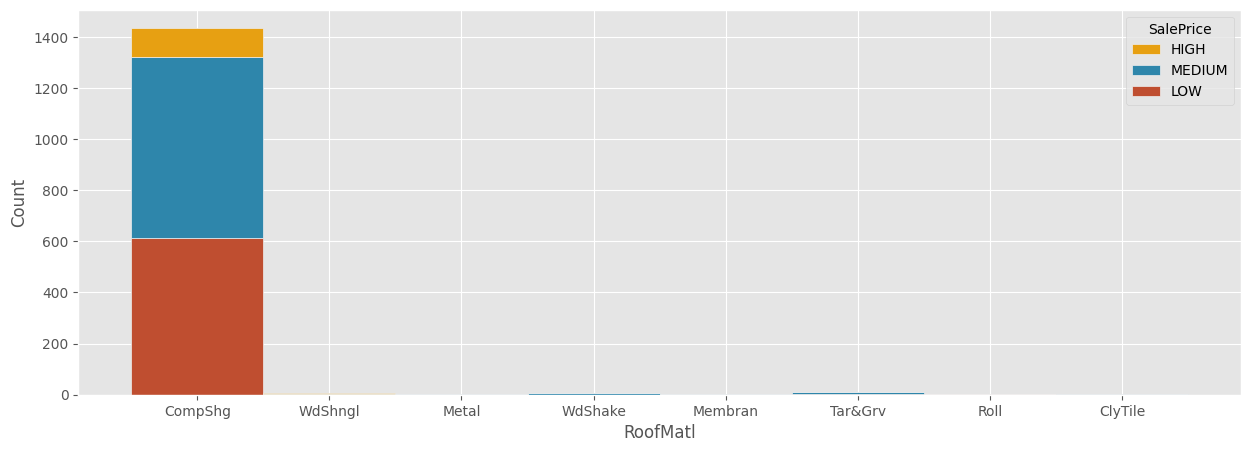

In [454]:
# Not useful
category_common_analysis(data=df, x='RoofMatl',target='SalePrice', percentages=False, palette=palette)
understand(dataf=df_copy, feature_name='RoofMatl', dtype='category', showplots=False)

##### Exterior1st & Exterior2nd

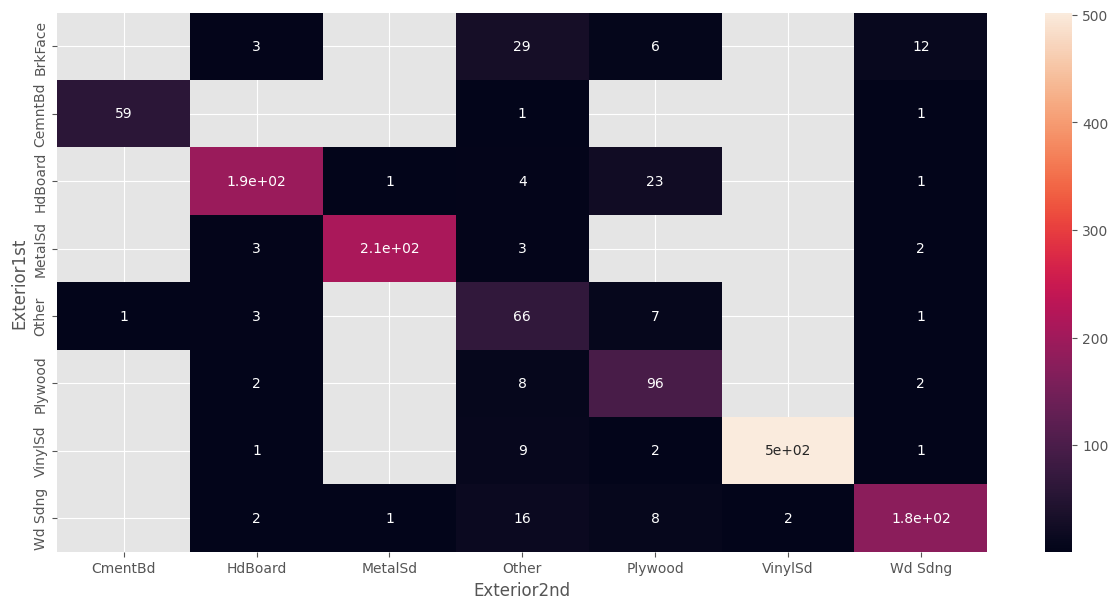

Exterior1st
VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
Other       78
CemntBd     61
BrkFace     50
Name: count, dtype: int64
Exterior2nd
VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
Other      136
CmentBd     60
Name: count, dtype: int64


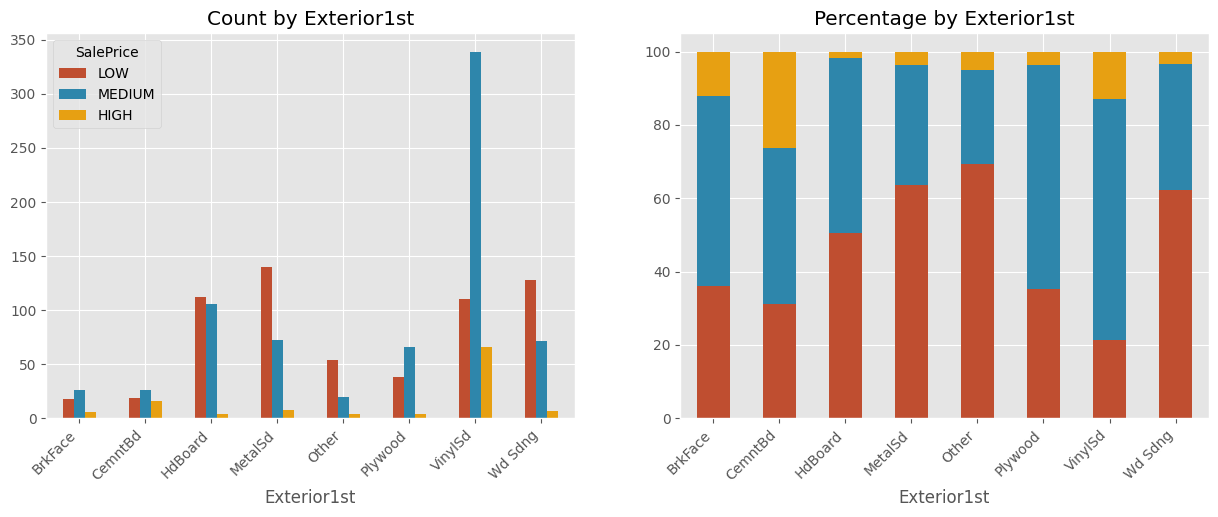

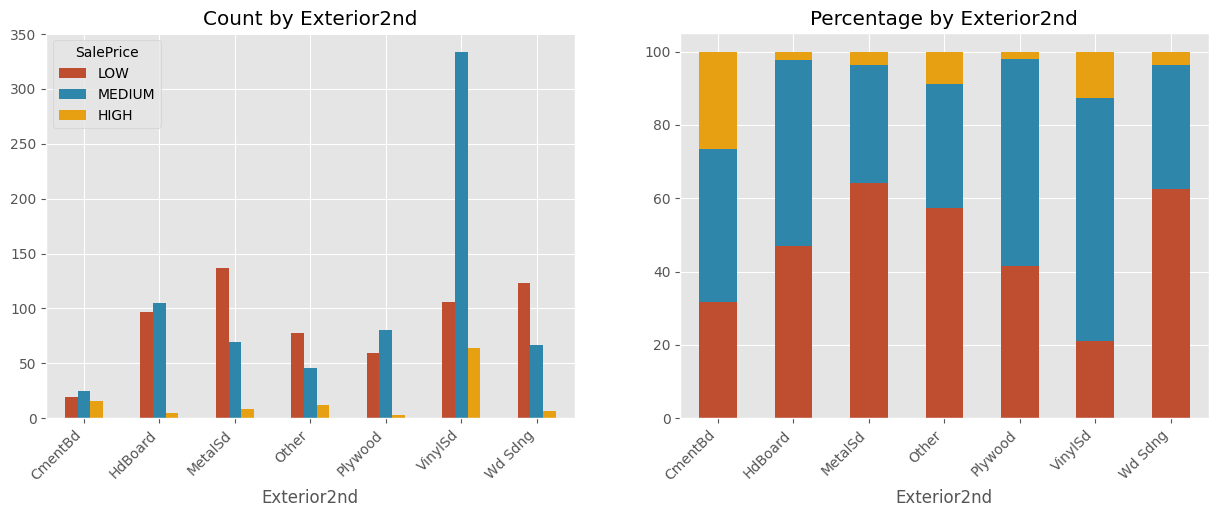

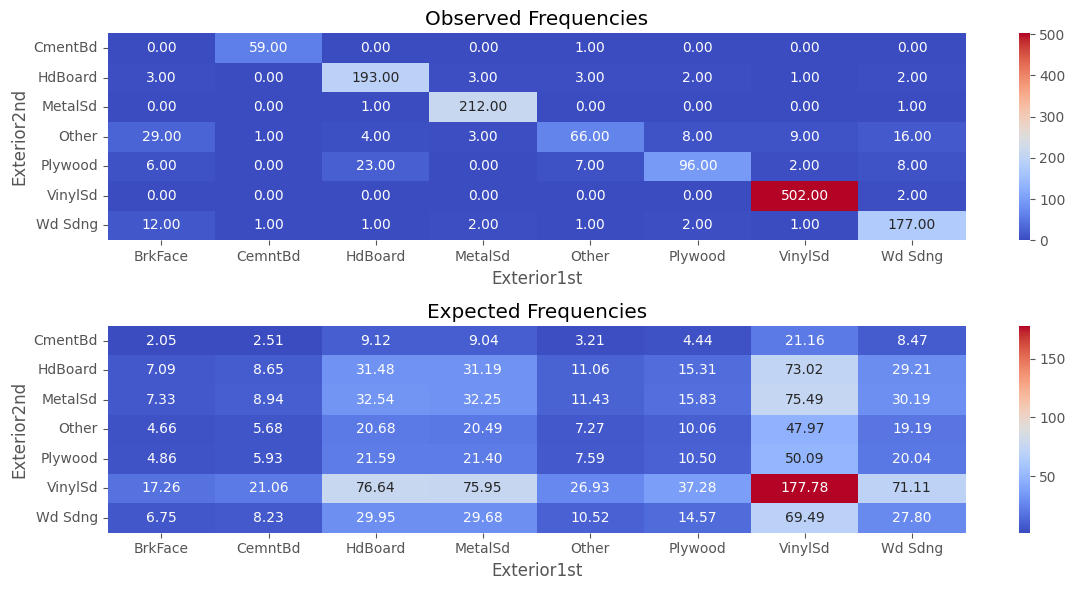

Chi-square Test - Outcome
P-Value: 0.0 [<0.05]
Cramer's V - Outcome
Coeff: 0.8808924627000861


(0.0, '[<0.05]')

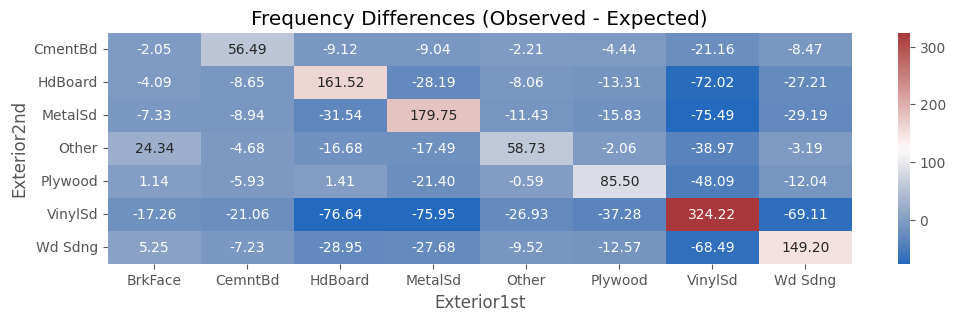

In [455]:
# sb.histplot(x = df["Exterior1st"], multiple='stack', hue = 'SalePrice',  data = df, hue_order = hue_order, palette = palette, alpha=1, ax=ax[0])
# sb.histplot(x = df["Exterior2nd"], multiple='stack', hue = 'SalePrice',  data = df, hue_order = hue_order, palette = palette, alpha=1, ax=ax[1])
# ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right')
# ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right')

#Basically they are too similar to each other
df_copy = aggregate(df_copy, new_name="Other", threshold=40, attribute="Exterior1st")
df_copy = aggregate(df=df_copy , new_name="Other", threshold=40, attribute="Exterior2nd")
plt.figure(figsize = (15,7))
df_heatmap =  df_copy[['Exterior1st','Exterior2nd']].pivot_table(index='Exterior1st',columns='Exterior2nd',aggfunc=len)
sb.heatmap(df_heatmap,annot=True)
plt.show()
category_common_analysis(data=df_copy, x='Exterior1st',target='SalePrice', histplot=False, palette=palette,rotation=45, figsize=(15, 5))
category_common_analysis(data=df_copy, x='Exterior2nd',target='SalePrice', histplot=False, palette=palette,rotation=45, figsize=(15, 5))
stattest_quali(df=df_copy, target='Exterior2nd', feature_name='Exterior1st')

##### MasVnrType

MasVnrType
None       864
BrkFace    445
Stone      128
BrkCmn      15
NA           8
Name: count, dtype: int64


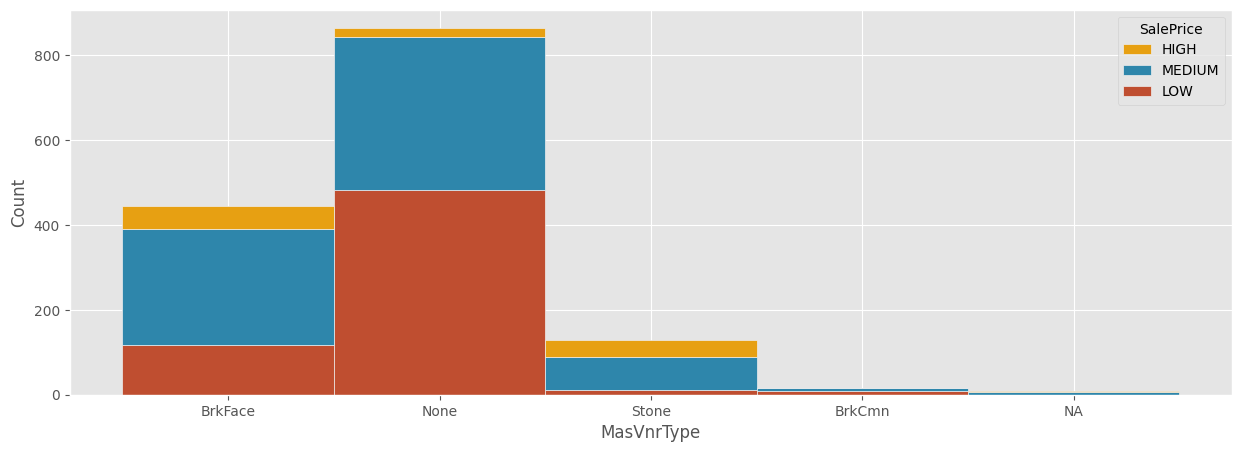

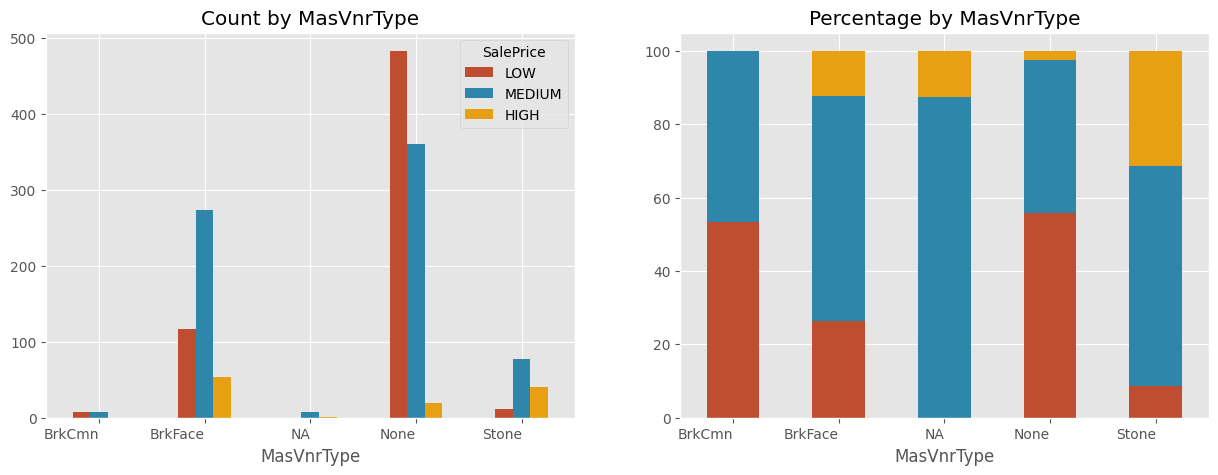

In [456]:
# Na are only 8 elements and they correspond to unknown
# Stone and None are significant respectively to High and Low
#We suggest to change the 8 elements with None, since they are very few
category_common_analysis(data=df, x='MasVnrType',target='SalePrice', percentages=True, palette=palette)

##### MasVnrArea

        Id MasVnrArea MasVnrType
234    235         NA         NA
529    530         NA         NA
650    651         NA         NA
936    937         NA         NA
973    974         NA         NA
977    978         NA         NA
1243  1244         NA         NA
1278  1279         NA         NA
Empty DataFrame
Columns: [Id, MasVnrArea, MasVnrType]
Index: []
Empty DataFrame
Columns: [Id, MasVnrArea, MasVnrType]
Index: []


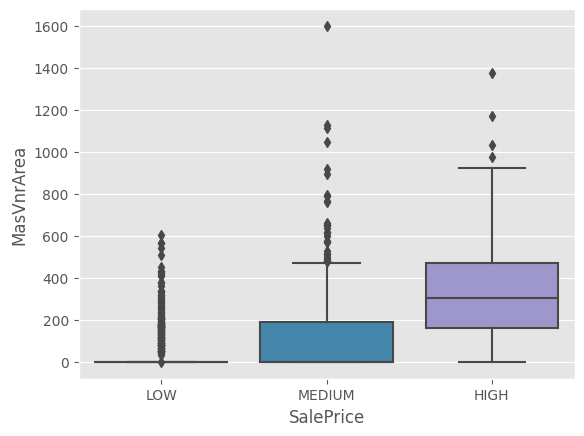

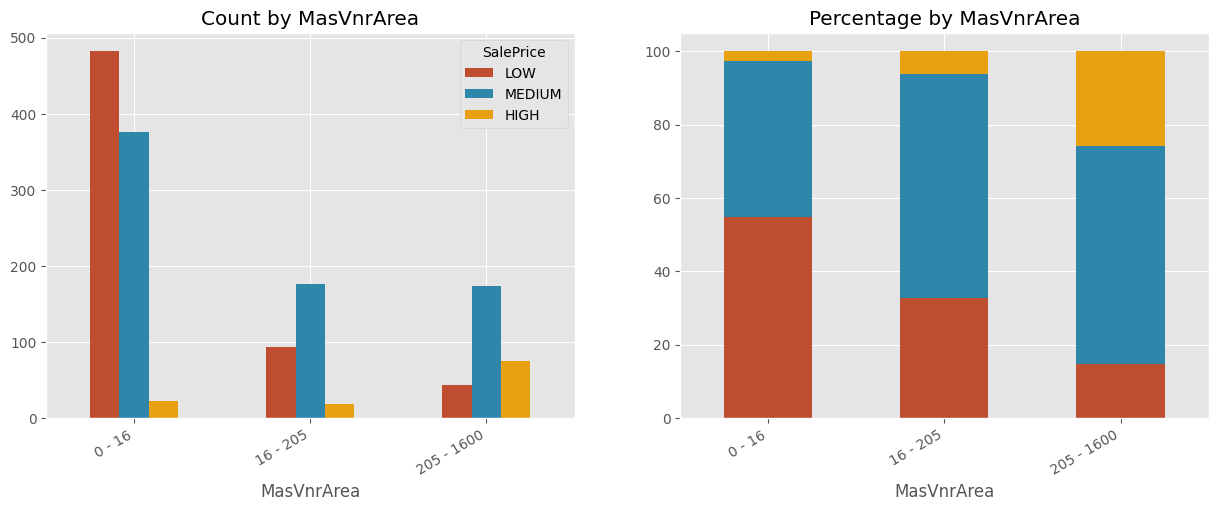

In [457]:
#The 8 NA values of MasVnrType have no Mas, then also this is Na, we can insert 0 (without changing the original data frame)
#by default in order to understand better the data
#We thing that the interaction between MasVnrType and MasVnrArea could be relevant
#We change the type to numeric
print(df_copy[df_copy["MasVnrArea"]  == "NA"][["Id","MasVnrArea","MasVnrType"]])
for i,e in df_copy.iterrows():
    if e["MasVnrArea"]=="NA":
        df_copy.at[i, "MasVnrArea"] = 0
print(df_copy[df_copy["MasVnrArea"]  == "NA"][["Id","MasVnrArea","MasVnrType"]])
df_copy["MasVnrArea"] = df_copy["MasVnrArea"].astype("int64")
print(df_copy[df_copy["MasVnrArea"]  < 0][["Id","MasVnrArea","MasVnrType"]])
sb.boxplot(data=df_copy, y="MasVnrArea", x="SalePrice")
frequencies_and_percentages_numeric(df_copy, 'SalePrice', 'MasVnrArea', rotation=30, bin=[0, 0.6, 0.8, 1])

##### ExterQual & ExterCond

ExterQual
TA    906
Gd    488
Ex     52
Fa     14
Name: count, dtype: int64
ExterCond
TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: count, dtype: int64
Understanding ExterQual:
	Missing values: 0
	Independence Test: 4.53e-164[<0.05]
	Information Gain: 0.34
	When the ExterQual is:
		• Fa, then the sale price is 90% likely to be LOW (0.96% of the times)
		• Ex, then the sale price is 75% likely to be HIGH (3.56% of the times)
		• Gd, then the sale price is 75% likely to be MEDIUM (33.42% of the times)
		• TA, then the sale price is 60% likely to be LOW (62.05% of the times)




c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


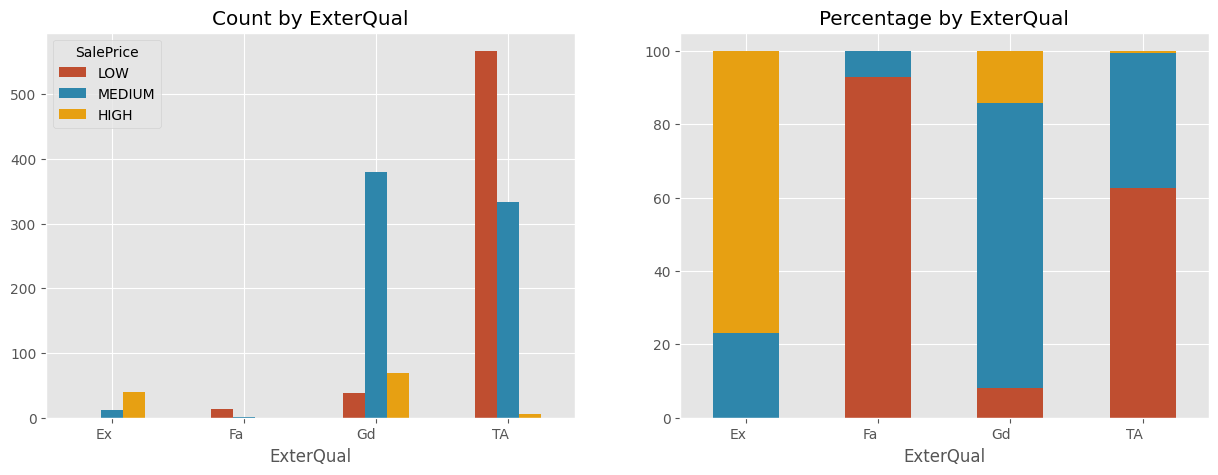

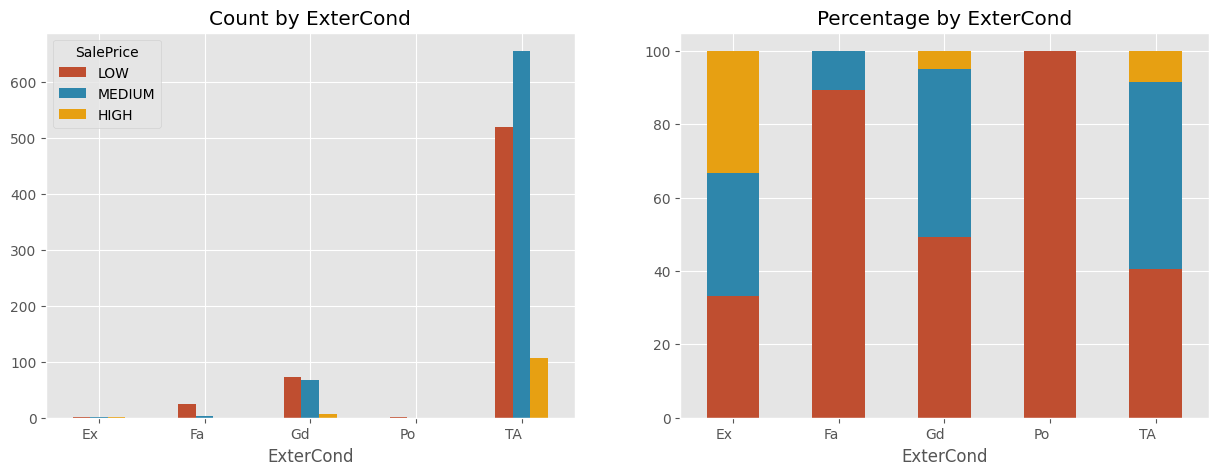

In [458]:
category_common_analysis(data=df, x='ExterQual',target='SalePrice', histplot=False, palette=palette)
category_common_analysis(data=df, x='ExterCond',target='SalePrice', histplot=False, palette=palette)
understand(dataf=df_copy, feature_name='ExterQual', showplots=False)

##### Foundation

Foundation
PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: count, dtype: int64
Understanding Foundation:
	Missing values: 0
	Independence Test: 2.20e-81[<0.05]
	Information Gain: 0.22
	When the Foundation is:
		• Slab, then the sale price is 90% likely to be LOW (1.64% of the times)
		• BrkTil, then the sale price is 70% likely to be LOW (10.00% of the times)
		• Stone, then the sale price is 65% likely to be LOW (0.41% of the times)
		• PConc+Wood, then the sale price is 65% likely to be MEDIUM (44.52% of the times)
		• CBlock, then the sale price is 60% likely to be LOW (43.42% of the times)




c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


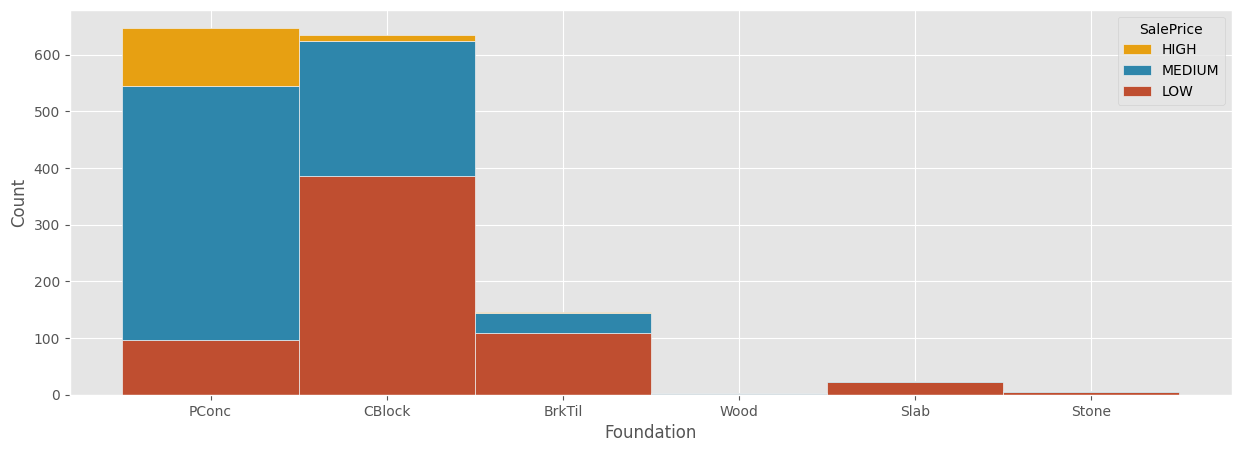

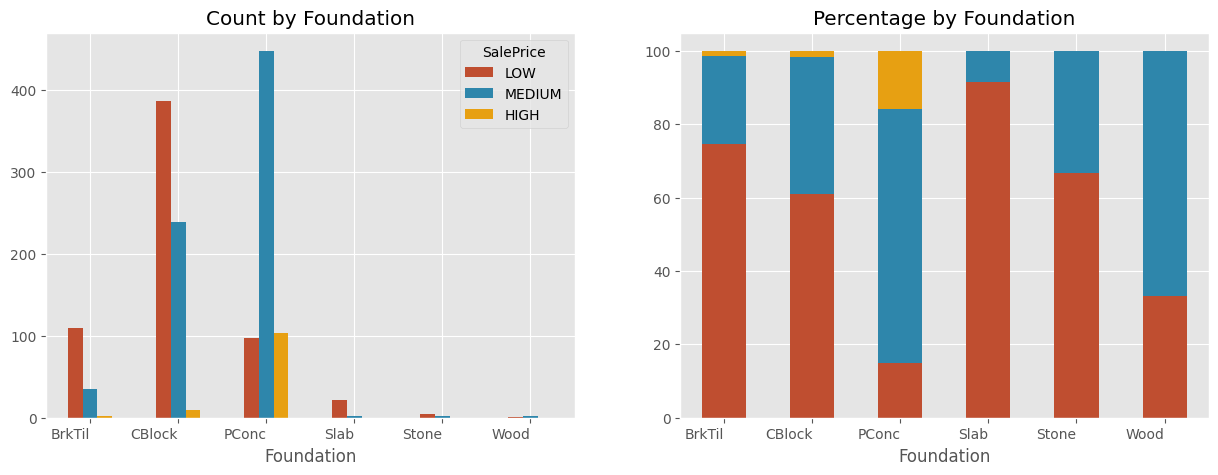

In [459]:
#insert other for wood, slab and stone
category_common_analysis(data=df, x='Foundation',target='SalePrice', percentages=True, palette=palette)
understand(dataf=df_copy, feature_name='Foundation', showplots=False)

##### BsmtQual

BsmtQual
TA    649
Gd    618
Ex    121
NA     37
Fa     35
Name: count, dtype: int64
Understanding BsmtQual:
	Missing values: 37
	Independence Test: 1.70e-200[<0.05]
	Information Gain: 0.38
	When the BsmtQual is:
		• NA, then the sale price is 90% likely to be LOW (2.53% of the times)
		• Fa, then the sale price is 85% likely to be LOW (2.40% of the times)
		• Gd, then the sale price is 75% likely to be MEDIUM (42.33% of the times)
		• TA, then the sale price is 65% likely to be LOW (44.45% of the times)
		• Ex, then the sale price is 60% likely to be HIGH (8.29% of the times)




c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


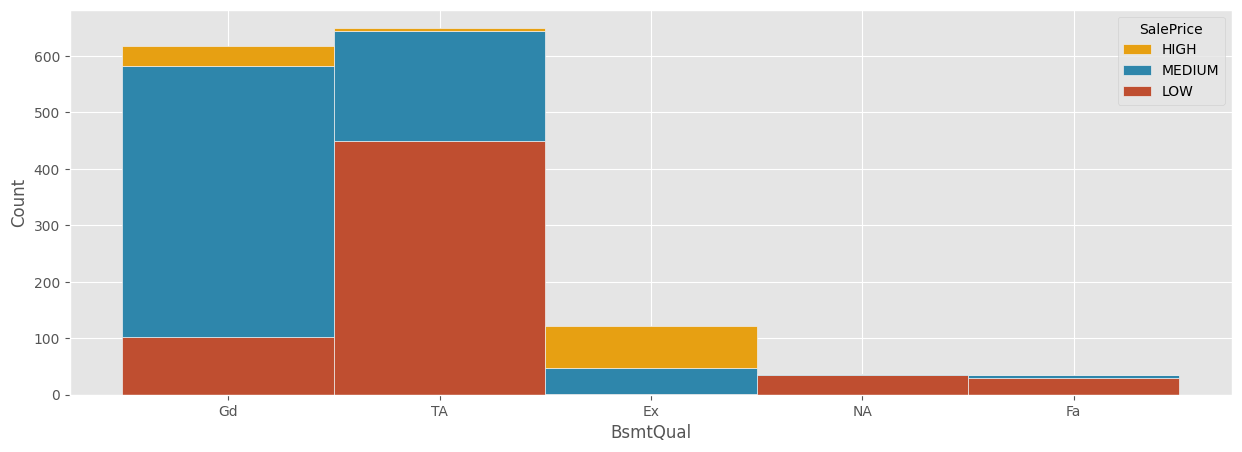

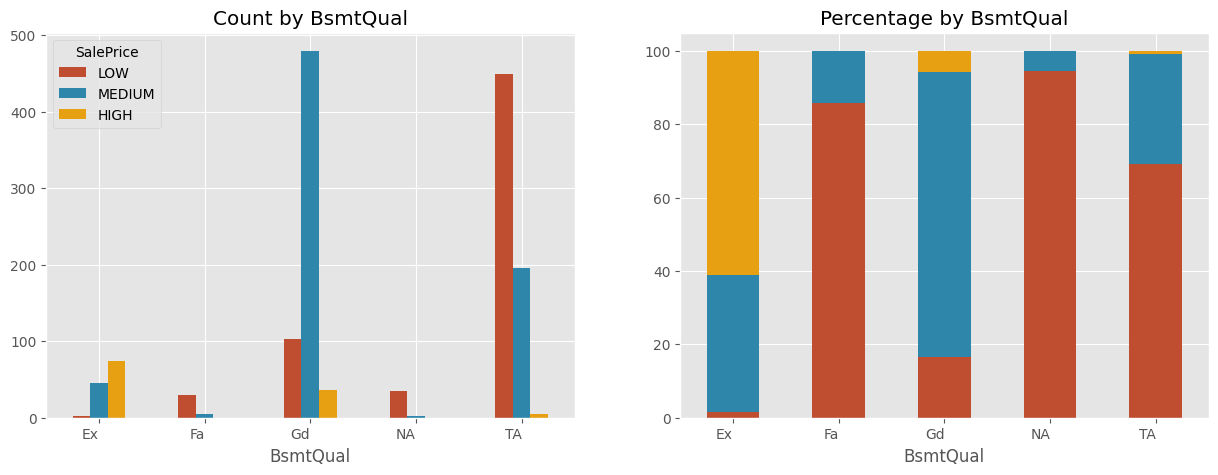

In [460]:
#insert other for wood, slab and stone
category_common_analysis(data=df, x='BsmtQual',target='SalePrice', percentages=True, palette=palette)
df[ (df["SalePrice"]=="HIGH")]["BsmtQual"].value_counts()
understand(dataf=df_copy, feature_name='BsmtQual', showplots=False)

##### BsmtCond

BsmtCond
TA    1311
Gd      65
Fa      45
NA      37
Po       2
Name: count, dtype: int64


BsmtCond
TA    107
Gd      8
Name: count, dtype: int64

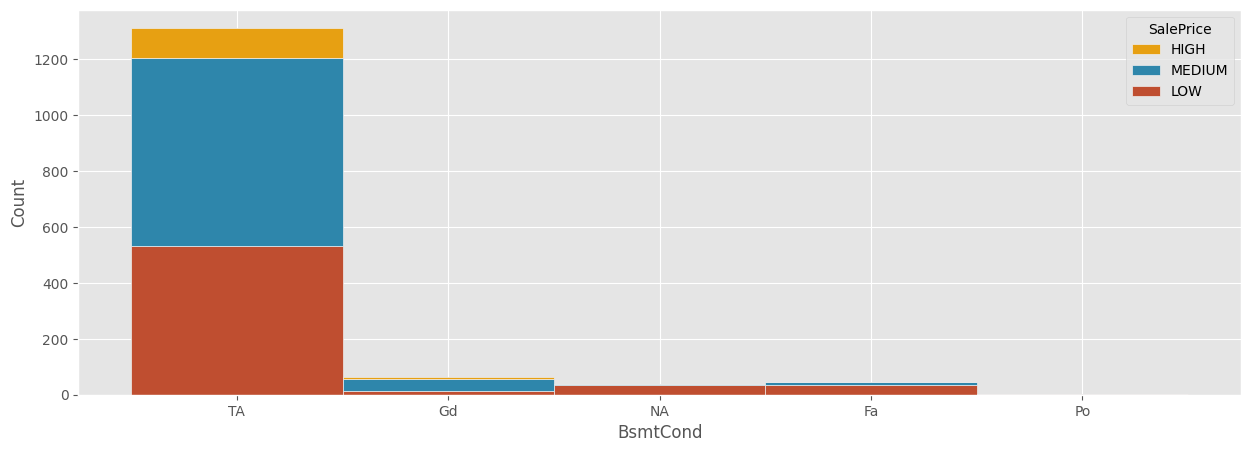

In [461]:
#Not useful, one element gather all the informations, too few elements for the other classes
category_common_analysis(data=df, x='BsmtCond',target='SalePrice', percentages=False, palette=palette)
df[ (df["SalePrice"]=="HIGH")]["BsmtCond"].value_counts()

##### BsmtExposure

SalePrice     LOW  MEDIUM  HIGH
BsmtExposure                   
Av             66     126    29
Gd             23      71    40
Mn             36      67    11
NA             35       3     0
No            459     459    35


Understanding BsmtExposure:
	Missing values: 38
	Independence Test: 1.10e-37[<0.05]
	Information Gain: 0.09
	When the BsmtExposure is:
		• NA, then the sale price is 90% likely to be LOW (2.60% of the times)
		• Av+Mn, then the sale price is 55% likely to be MEDIUM (22.95% of the times)
		• Gd, then the sale price is 50% likely to be MEDIUM (9.18% of the times)
		• No, then the sale price is 45% likely to be LOW (65.27% of the times)




c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


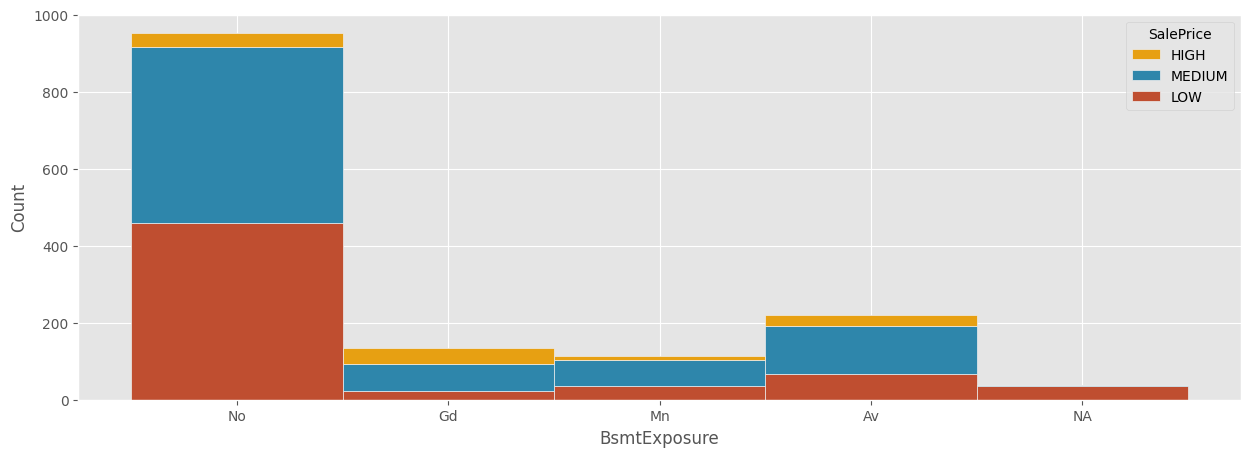

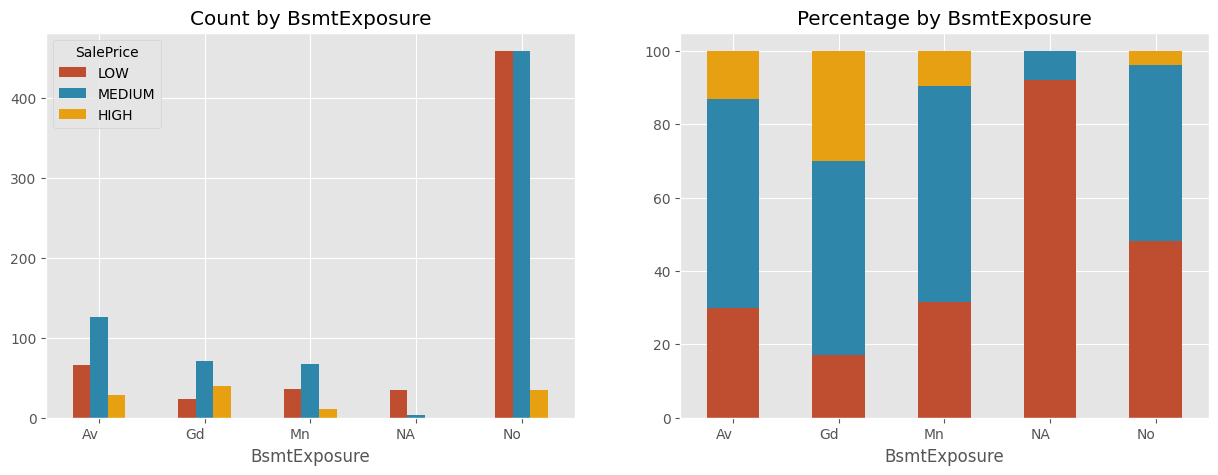

In [462]:

print(df[["BsmtExposure","SalePrice"]].pivot_table(index = "BsmtExposure" , columns=["SalePrice"],  aggfunc=len, fill_value=0))
category_common_analysis(data=df,x='BsmtExposure', display= False, target='SalePrice', percentages=True, palette=palette)
understand(dataf=df_copy, feature_name='BsmtExposure', showplots=False)

##### BsmtFinType1

c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Understanding BsmtFinType1:
	Missing values: 37
	Independence Test: 3.52e-57[<0.05]
	Information Gain: 0.16
	When the BsmtFinType1 is:
		• NA, then the sale price is 90% likely to be LOW (2.53% of the times)
		• GLQ, then the sale price is 60% likely to be MEDIUM (28.63% of the times)
		• BLQ+LwQ, then the sale price is 60% likely to be LOW (15.21% of the times)
		• Rec, then the sale price is 55% likely to be LOW (9.11% of the times)
		• ALQ, then the sale price is 50% likely to be LOW (15.07% of the times)
		• Unf, then the sale price is 50% likely to be MEDIUM (29.45% of the times)




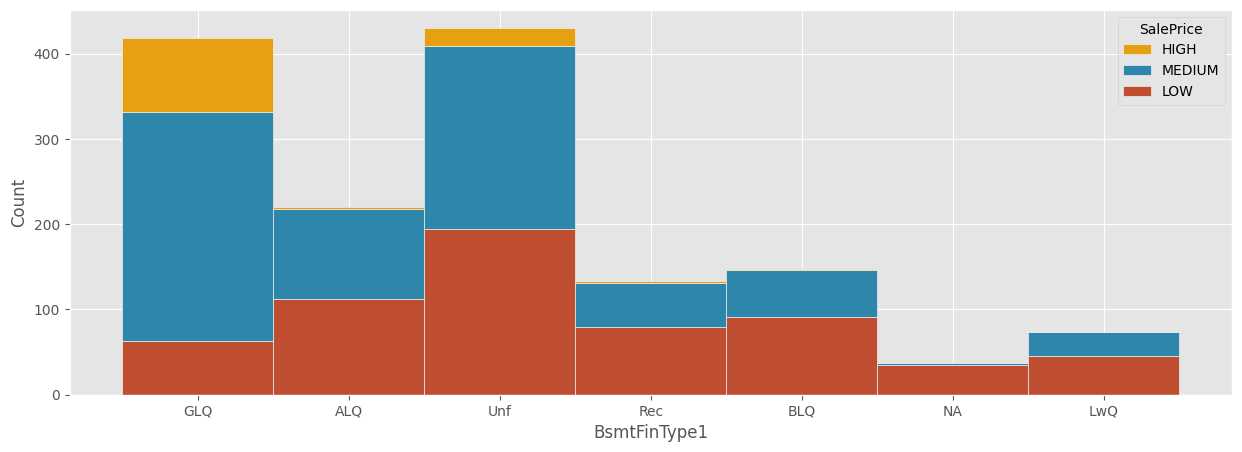

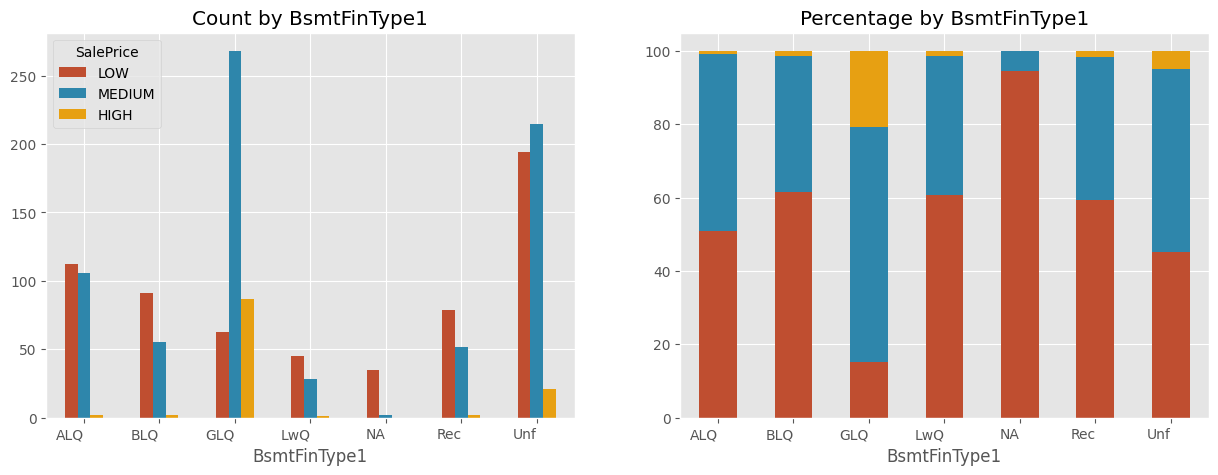

In [463]:

category_common_analysis(data=df,x='BsmtFinType1', display= False, target='SalePrice', percentages=True, palette=palette)
understand(dataf=df_copy, feature_name='BsmtFinType1', showplots=False)

##### BsmtFinSF1

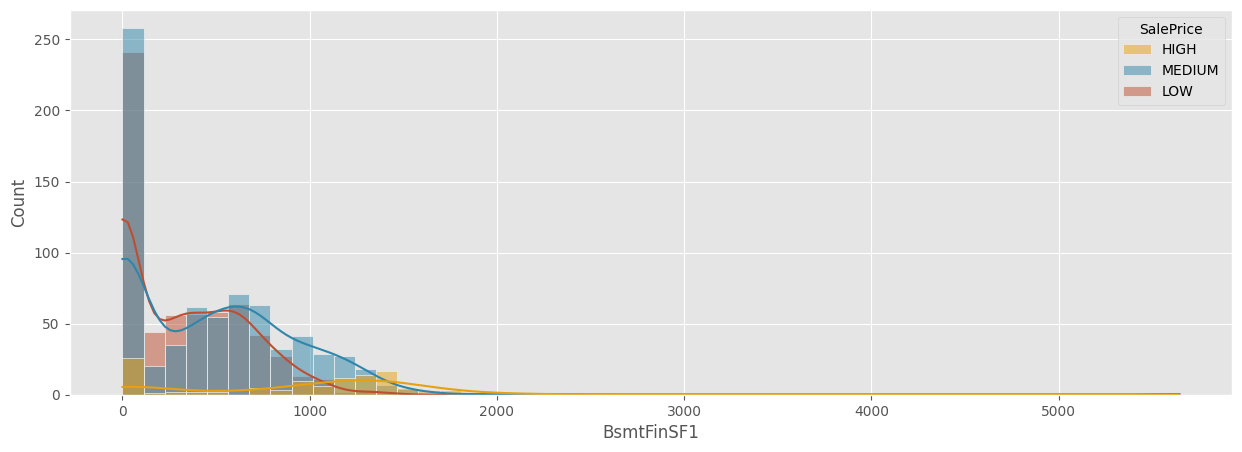

Understanding BsmtFinSF1:
	Missing values: 0
	Independence Test: 1.54e-41[<0.05]
	Correlation Index: 0.39
	Correlation p_value: 3.39e-53



In [464]:
understand(dataf=df_copy, feature_name='BsmtFinSF1', dtype='int', upper_limit=2000)

##### BsmtFinType2

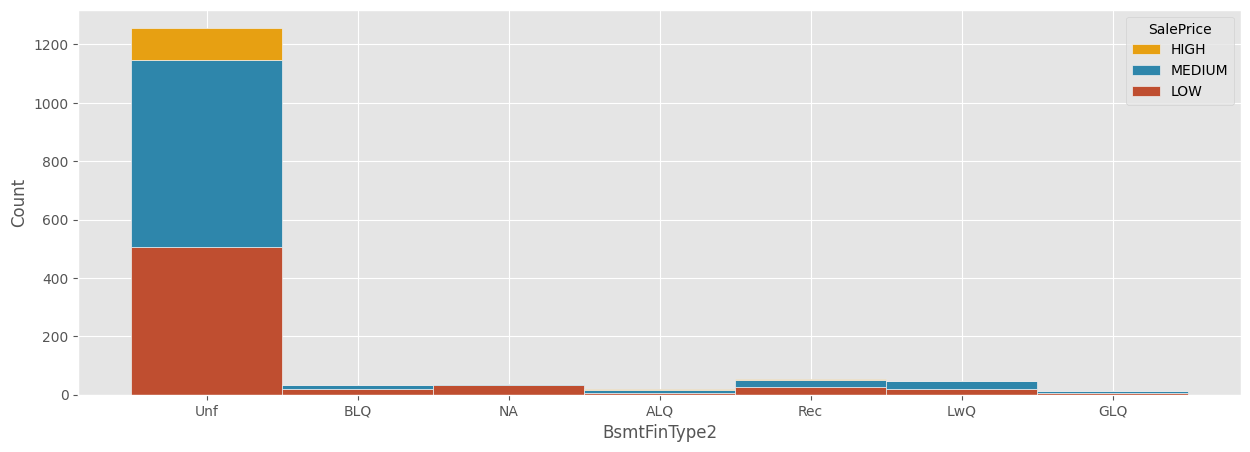

In [465]:
category_common_analysis(data=df,x='BsmtFinType2', display= False, target='SalePrice', percentages=False, palette=palette)

##### BsmtFinSF2

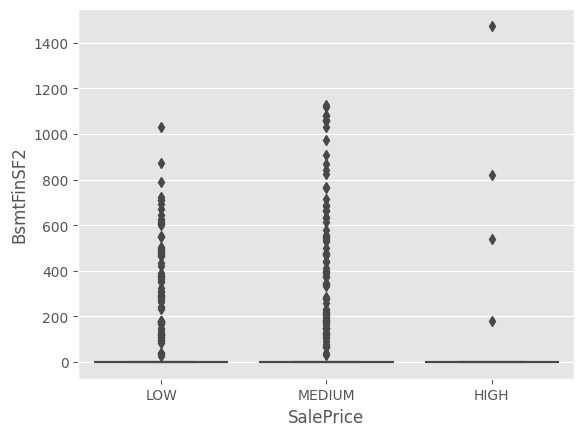

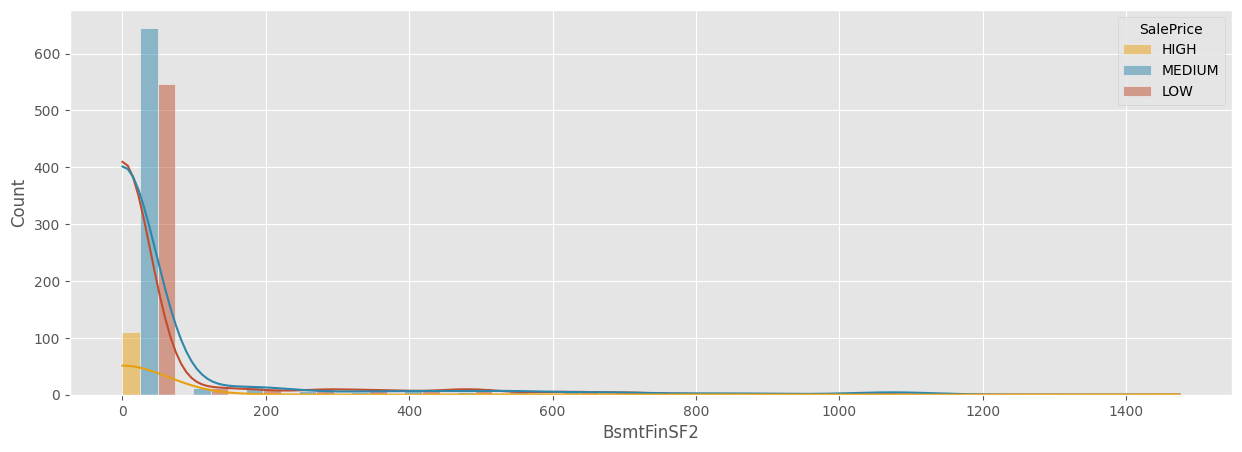

In [466]:
# as we can see from the boxplot all the means are approximately zero and also within the narrow range of plausible values
# no trend emerges
sb.boxplot(data=df, y="BsmtFinSF2", x="SalePrice")
histplot(df,'SalePrice',"BsmtFinSF2",multiple='dodge',alpha=0.5, bins=20)

##### BsmtUnfSF

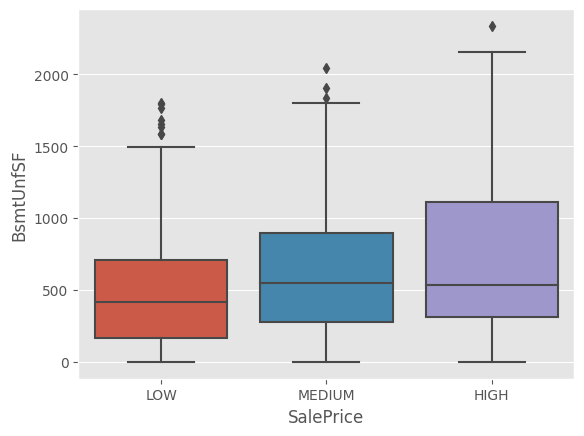

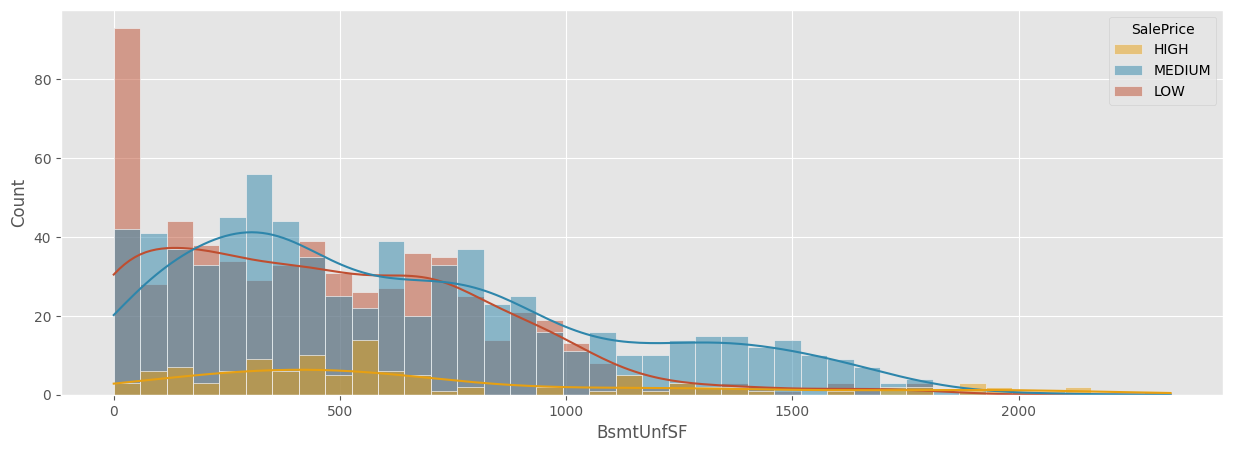

In [467]:
# The mean of the attribute is approximately equal for the MEDIUM and HIGH class, while for LOW it is smaller.
# However, the distributions of the three lables have almost the same peak
sb.boxplot(data=df, y="BsmtUnfSF", x="SalePrice")
histplot(df,'SalePrice',"BsmtUnfSF",multiple='layer',alpha=0.5, bins = 40)
#frequencies_and_percentages_numeric(df, 'SalePrice', 'BsmtUnfSF', rotation=30, bin = [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

##### TotalBsmtSF

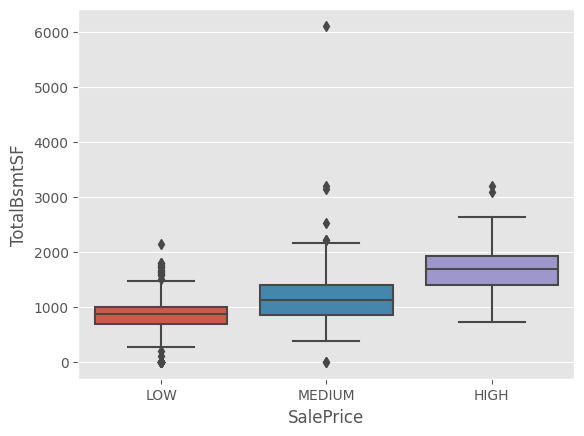

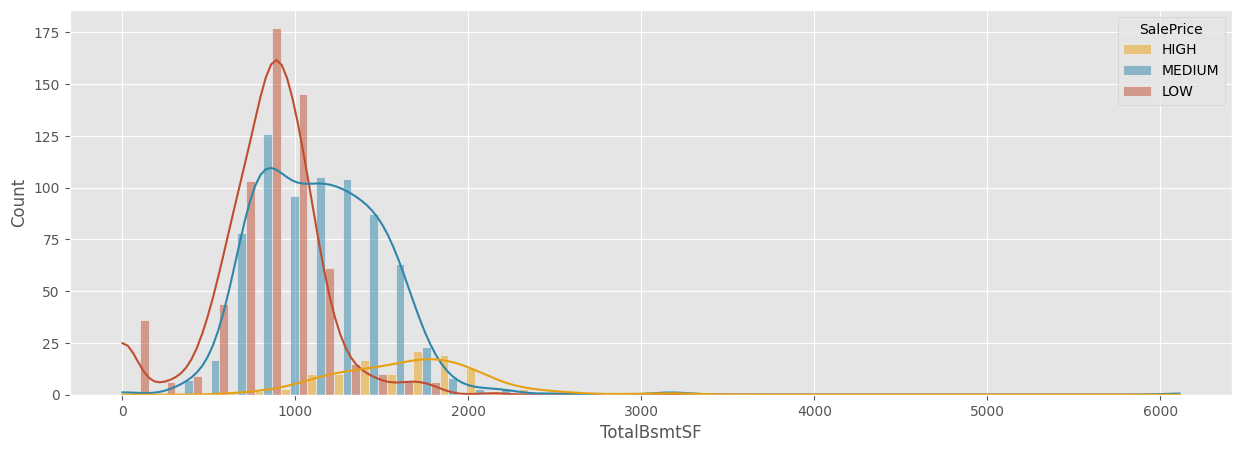

Understanding TotalBsmtSF:
	Missing values: 0
	Independence Test: 1.41e-106[<0.05]
	Correlation Index: 0.61
	Correlation p_value: 9.48e-152



In [468]:
# The mean is different for all the three labels and the distributions of the labels
# look enough distant one from the other, so we keep the attribute
sb.boxplot(data=df, y="TotalBsmtSF", x="SalePrice")
histplot(df,'SalePrice',"TotalBsmtSF",multiple='dodge',alpha=0.5, bins = 40)
understand(dataf=df_copy, feature_name='TotalBsmtSF', dtype='int', showplots=False, low_limit=0, upper_limit= 3000)


##### Heating

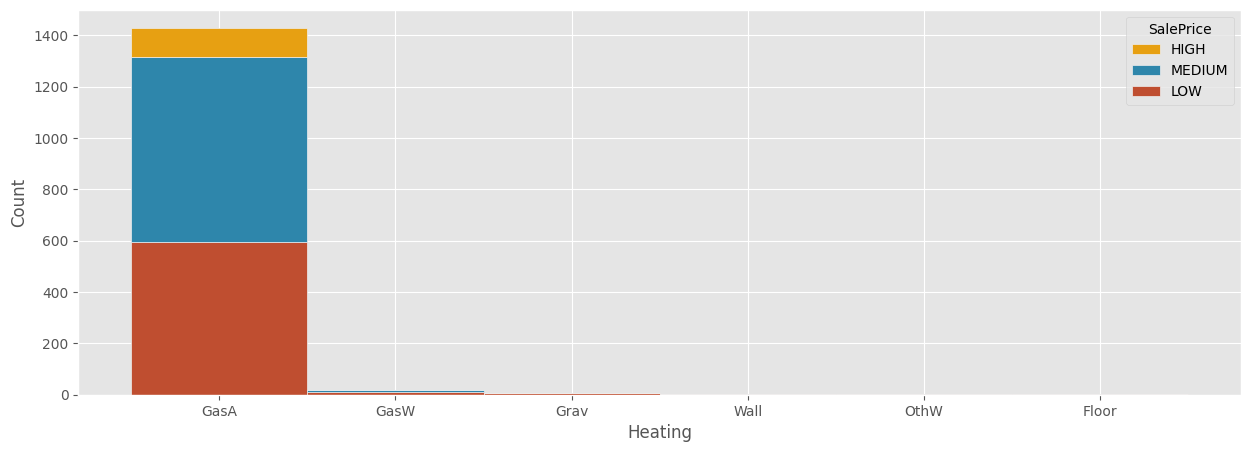

In [469]:
# Almost all the examples have the same attribute value, there is no use in keeping it 
category_common_analysis(data=df,x='Heating', display= False, target='SalePrice', percentages=False, palette=palette)

##### HeatingQC

c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Understanding HeatingQC:
	Missing values: 0
	Independence Test: 1.71e-56[<0.05]
	Information Gain: 0.15
	When the HeatingQC is:
		• Po, then the sale price is LOW (0.07% of the times)
		• Fa, then the sale price is 70% likely to be LOW (3.36% of the times)
		• TA, then the sale price is 65% likely to be LOW (29.32% of the times)
		• Ex, then the sale price is 60% likely to be MEDIUM (50.75% of the times)
		• Gd, then the sale price is 45% likely to be LOW (16.51% of the times)




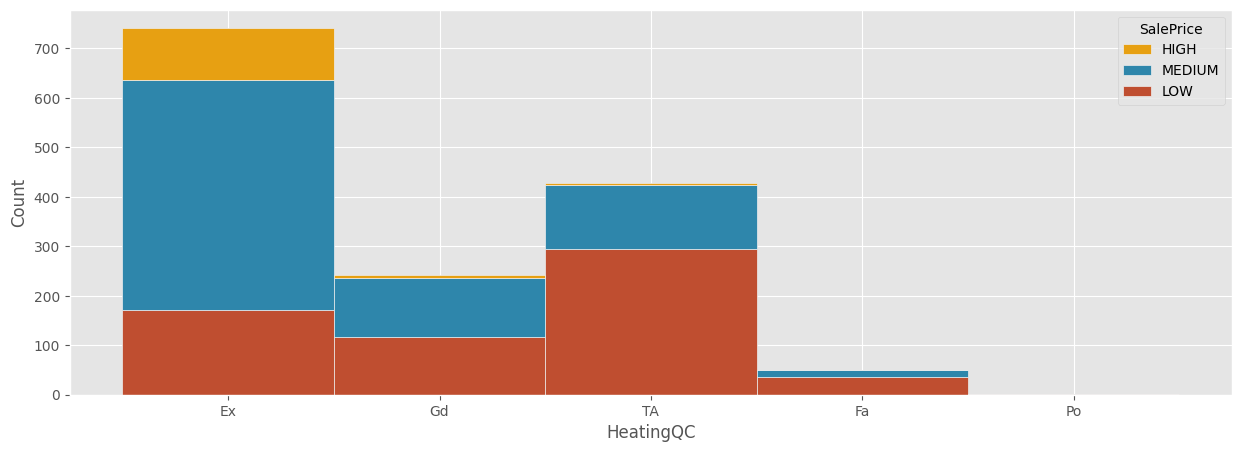

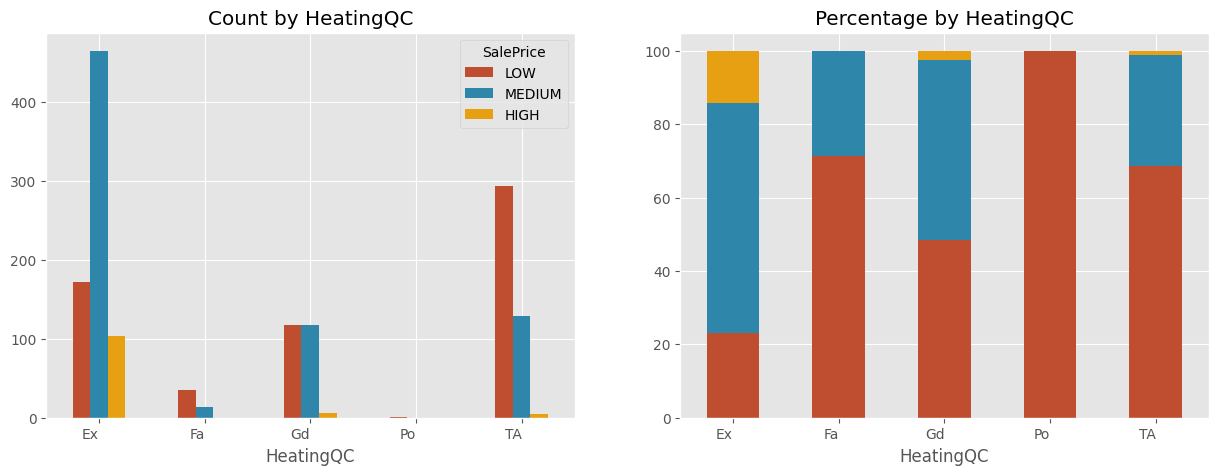

In [470]:

category_common_analysis(data=df,x='HeatingQC', display= False, target='SalePrice', percentages=True, palette=palette)
understand(dataf=df_copy, feature_name='HeatingQC', showplots=False)

##### CentralAir

In [471]:
IG(df,'SalePrice','CentralAir')

c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.05543545701641376

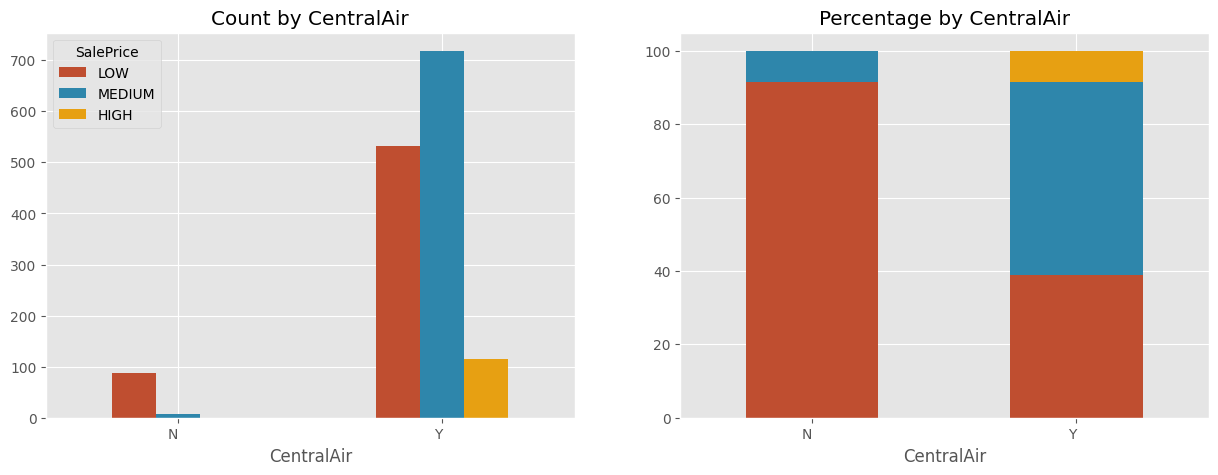

In [472]:
frequencies_and_percentages(df,'SalePrice','CentralAir')

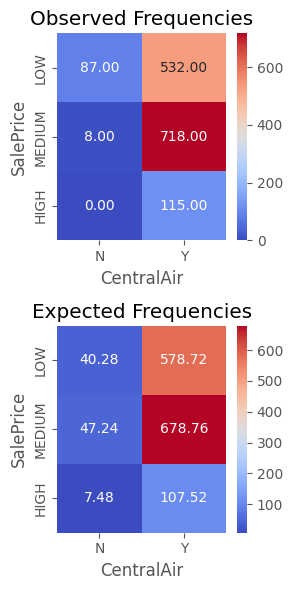

Chi-square Test - Outcome
P-Value: 1.268584851703206e-22 [<0.05]
Cramer's V - Outcome
Coeff: 0.2628061686289399


(1.268584851703206e-22, '[<0.05]')

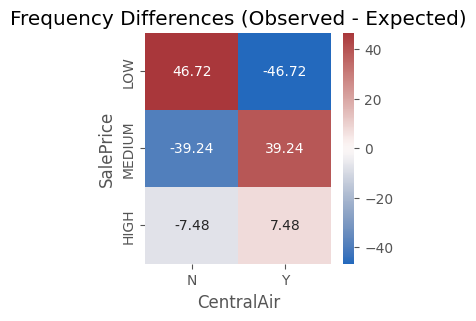

In [473]:
stattest_quali(df,'CentralAir', typeplot='heatmap', fig_width=10)

ANOVA Test - Outcome
P-Value: 7.00278021431306e-52 [<0.05]


(7.00278021431306e-52, '[<0.05]')

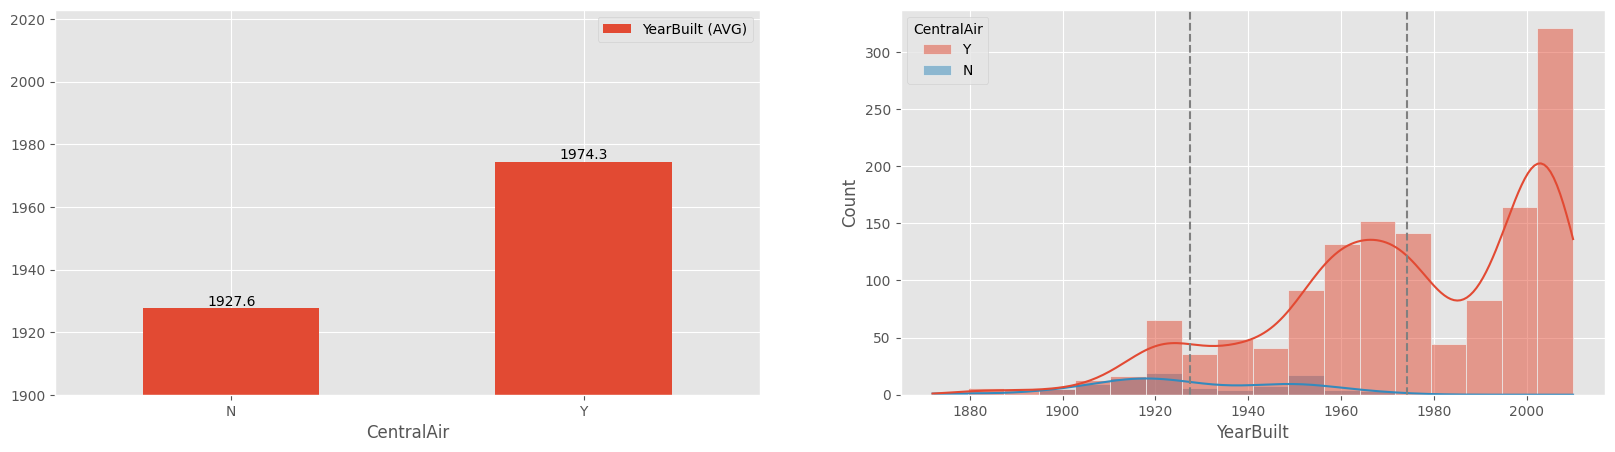

In [474]:
stattest_quanti(df,'YearBuilt', 'CentralAir' , low_limit=1900, upper_limit=2023)

##### Electrical

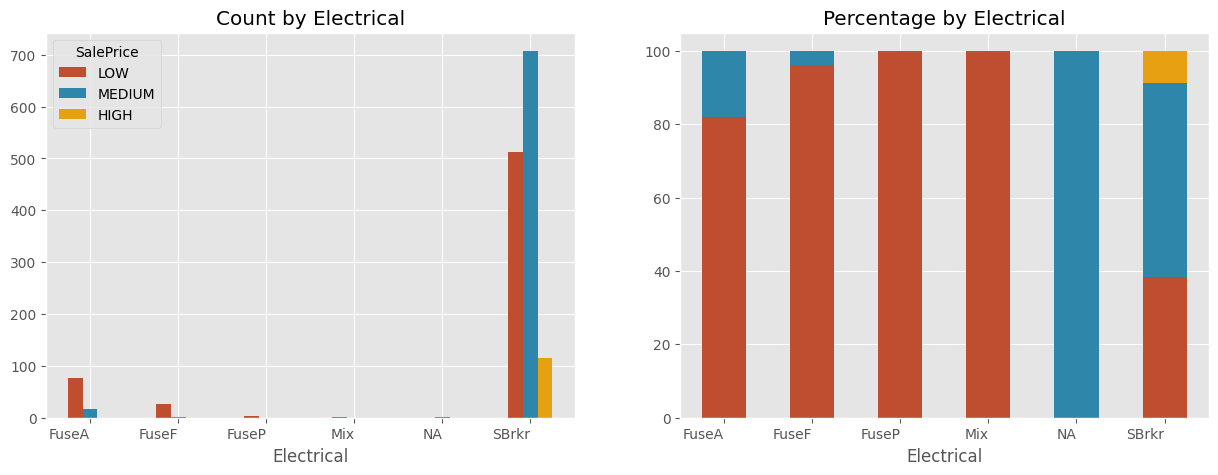

In [475]:
frequencies_and_percentages(df,'SalePrice','Electrical')

In [476]:
IG(df,'SalePrice','Electrical')

c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.060141516515176664

In [477]:
len(df[df['Electrical'] == 'NA'])

1

##### 1stFlrSF

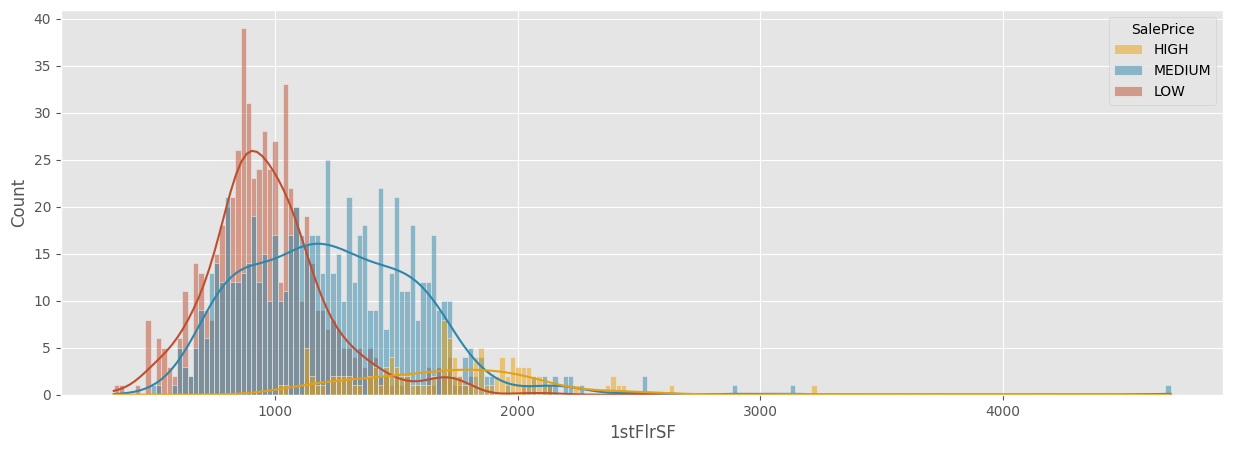

In [478]:
histplot(df,'SalePrice','1stFlrSF',bins=200)

ANOVA Test - Outcome
P-Value: 2.555821024618768e-104 [<0.05]


(2.555821024618768e-104, '[<0.05]')

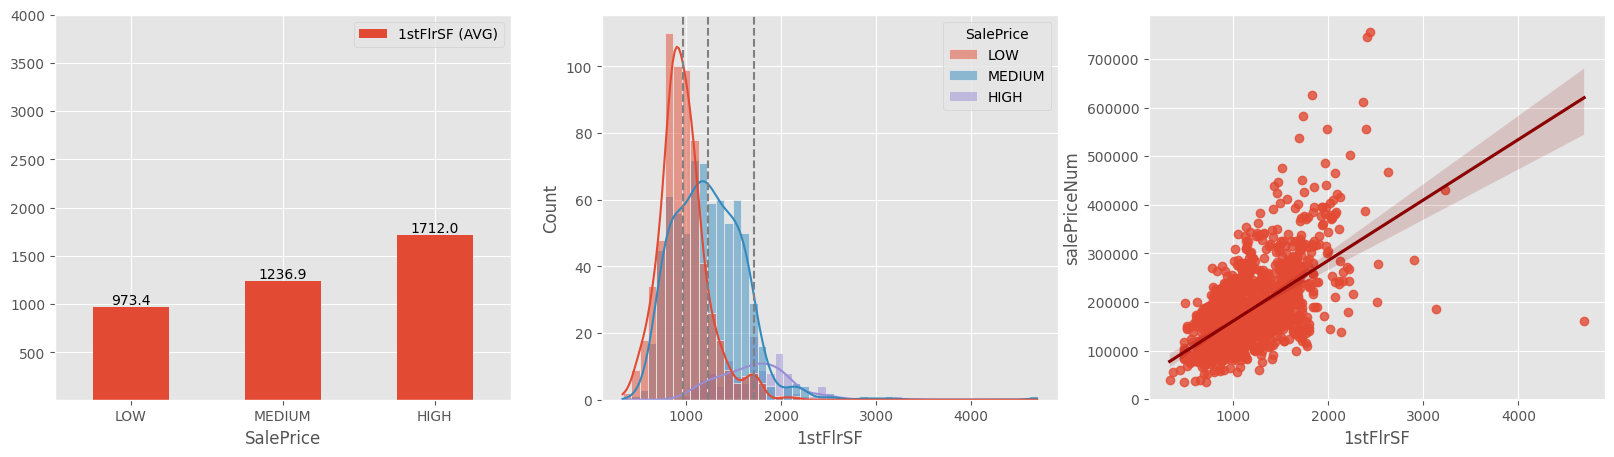

In [479]:
stattest_quanti(df,'1stFlrSF',low_limit=10, upper_limit=4000)

##### 2ndFlrSF


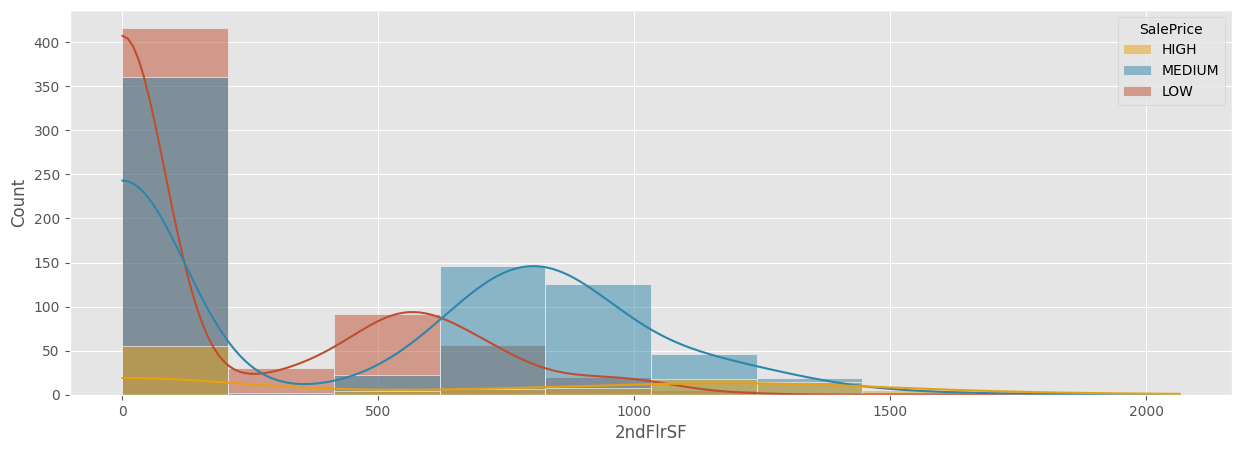

ANOVA Test - Outcome
P-Value: 1.7788644017519046e-32 [<0.05]


(1.7788644017519046e-32, '[<0.05]')

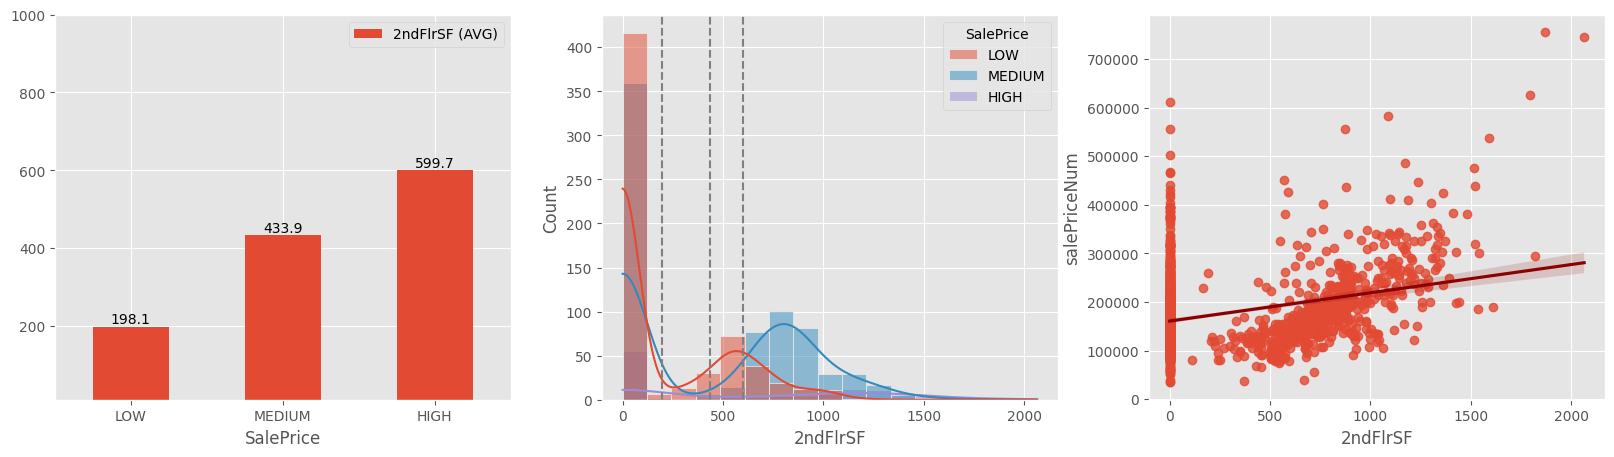

In [480]:
histplot(df,'SalePrice','2ndFlrSF',bins=10)
stattest_quanti(df,'2ndFlrSF',low_limit=10, upper_limit=1000)

##### LowQualFinSF

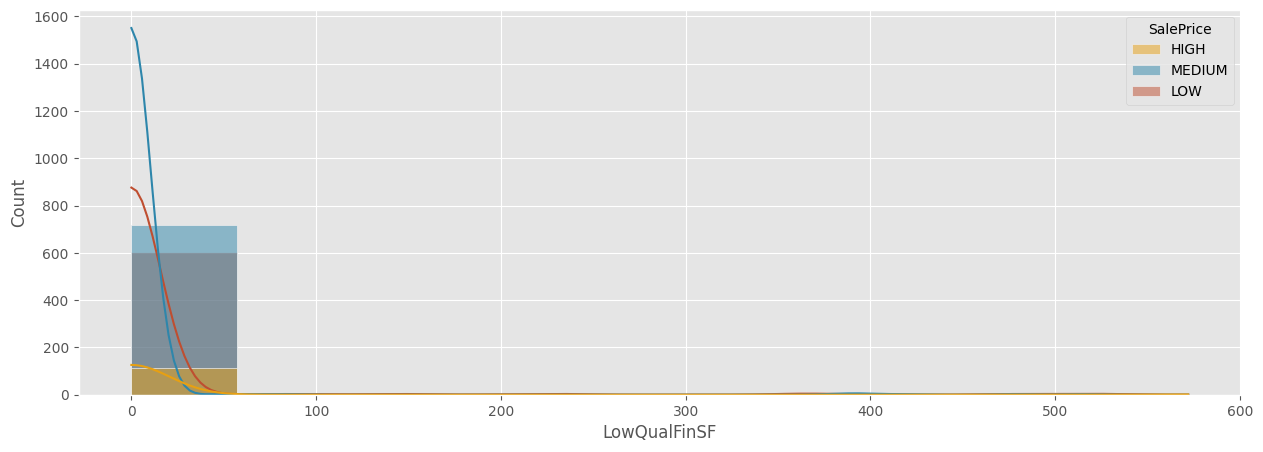

ANOVA Test - Outcome
P-Value: 0.20310425163833182 


(0.20310425163833182, '')

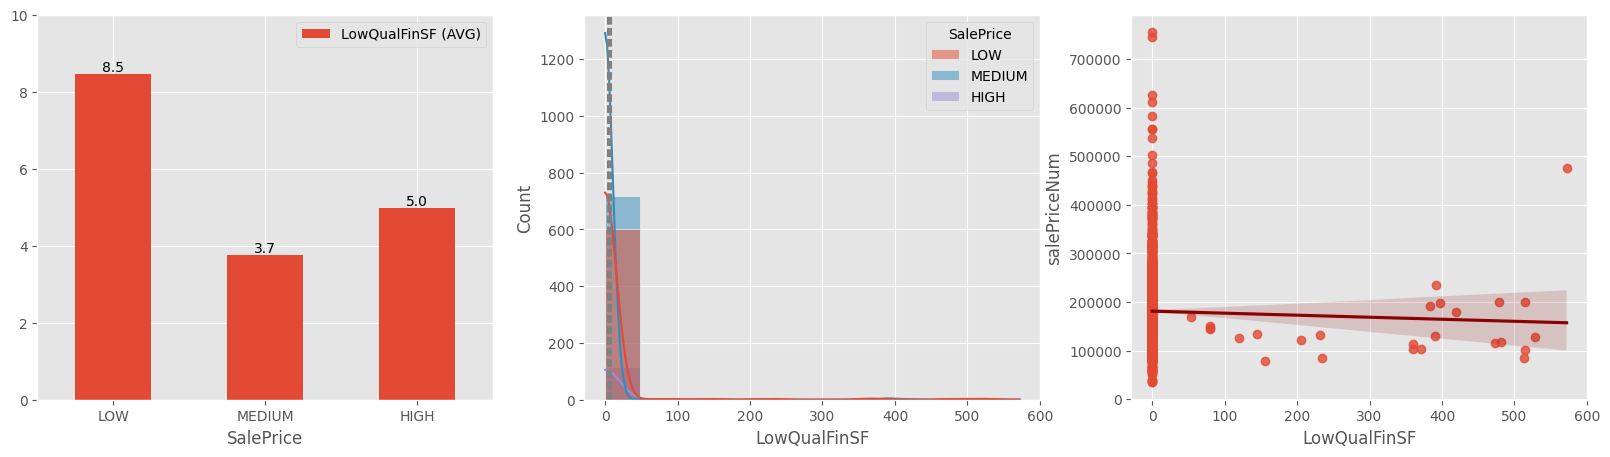

In [481]:
histplot(df,'SalePrice','LowQualFinSF',bins=10)
stattest_quanti(df,'LowQualFinSF',low_limit=0, upper_limit=10)

##### GrLivArea

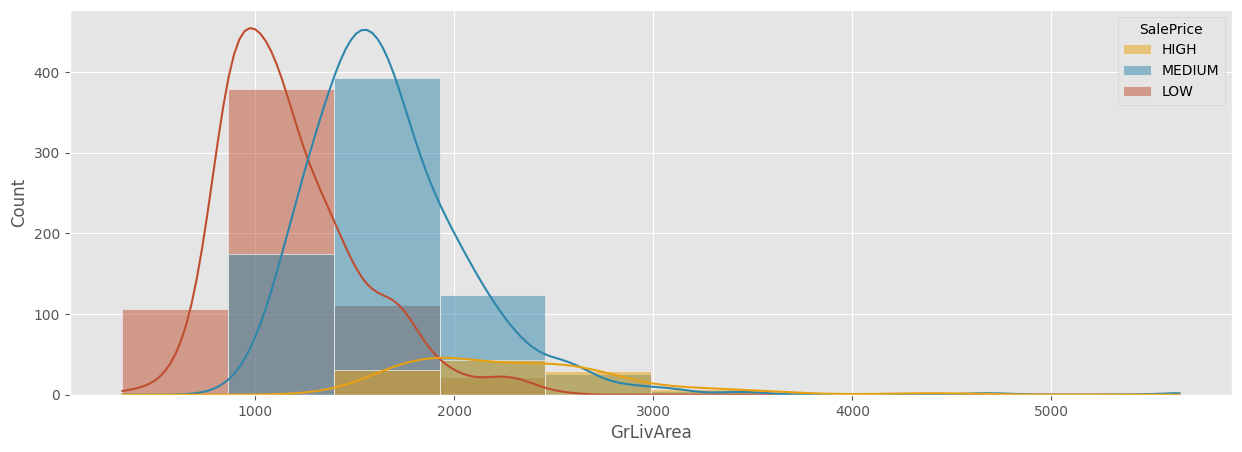

ANOVA Test - Outcome
P-Value: 2.727682408446856e-163 [<0.05]


(2.727682408446856e-163, '[<0.05]')

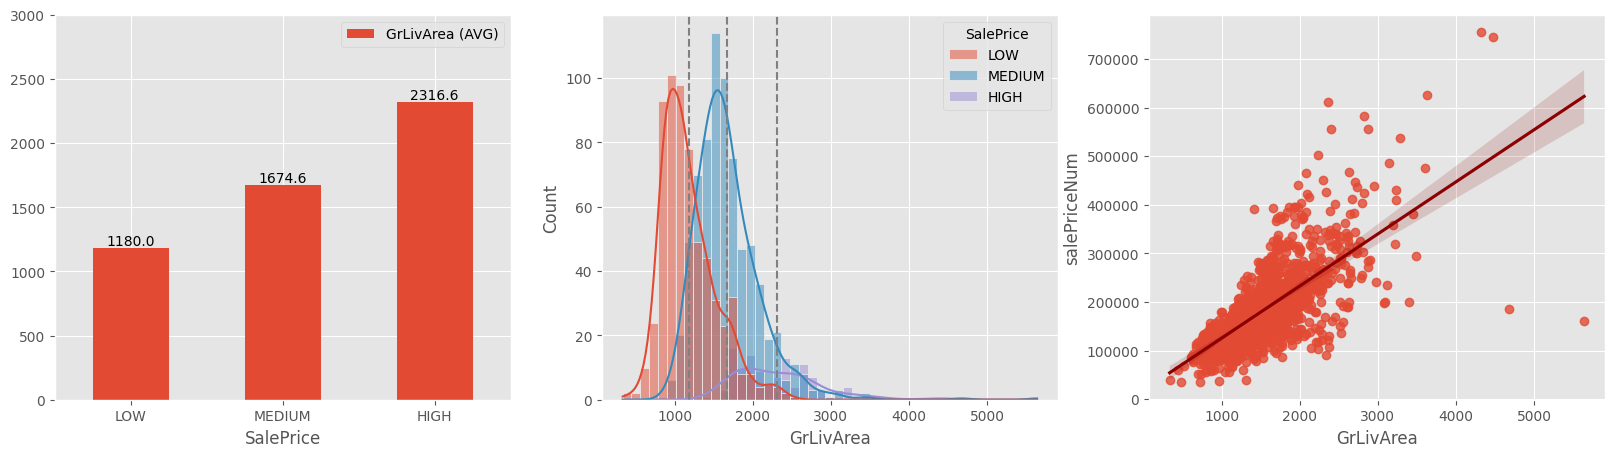

In [482]:
histplot(df,'SalePrice','GrLivArea',bins=10)
stattest_quanti(df,'GrLivArea',low_limit=0, upper_limit=3000)

##### BsmtFullBath

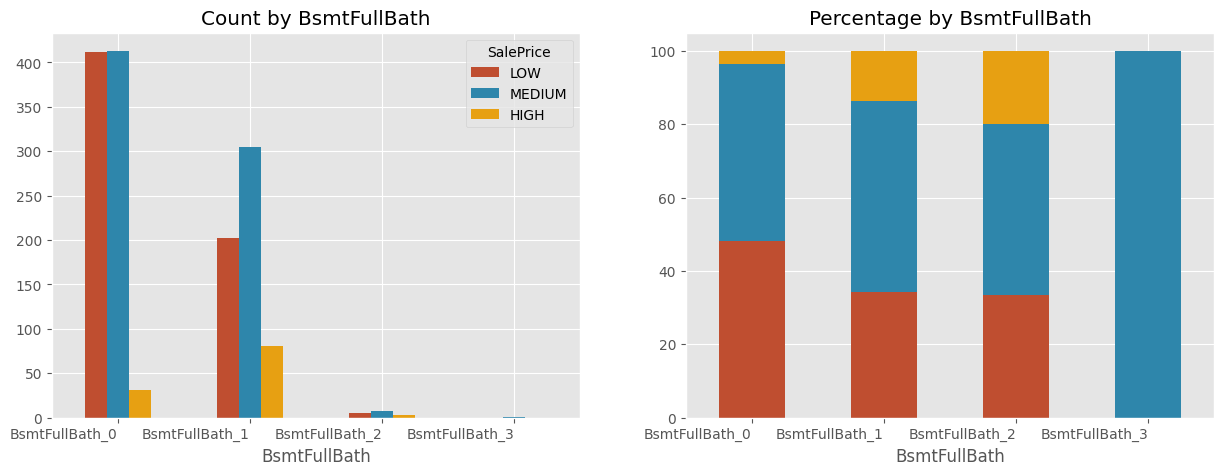

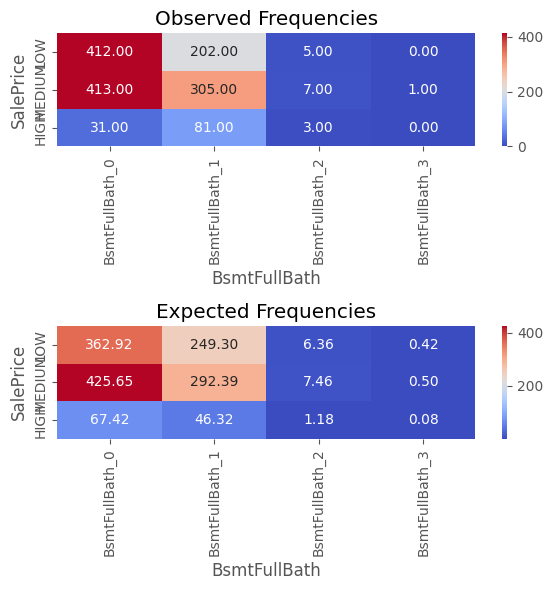

Chi-square Test - Outcome
P-Value: 2.3271572182731895e-12 [<0.05]
Cramer's V - Outcome
Coeff: 0.15069691374777708
0.032819947247596126


c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


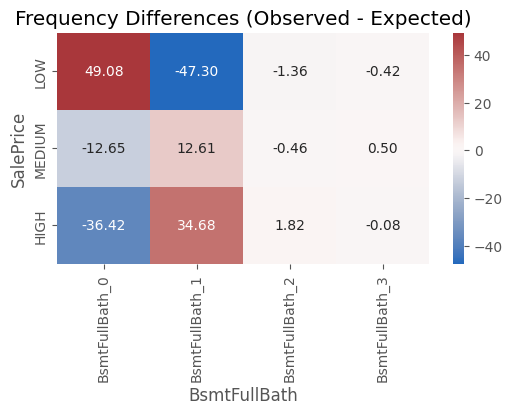

In [483]:
categoric_ordinal_plot(df_copy, 'BsmtFullBath')

##### BsmtHalfBath

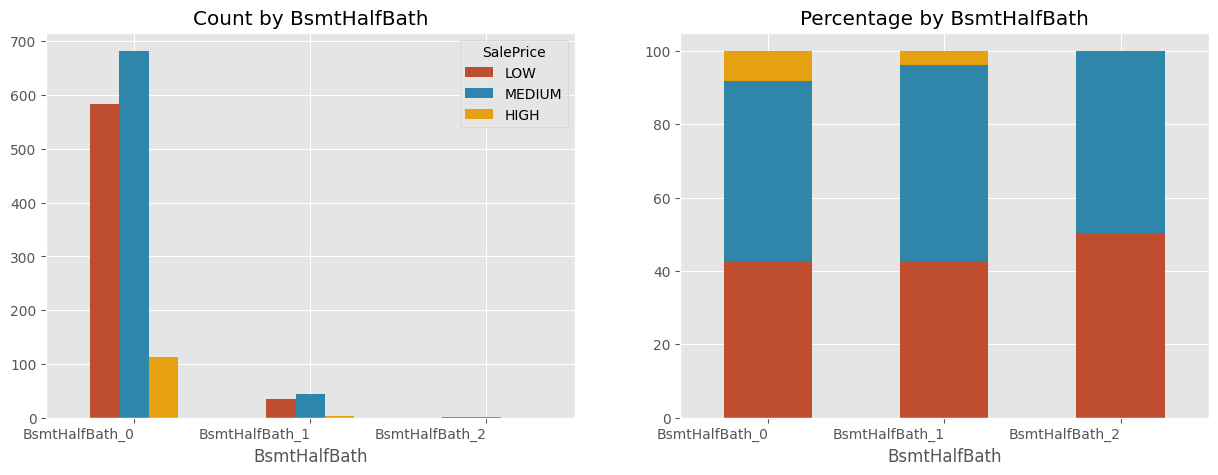

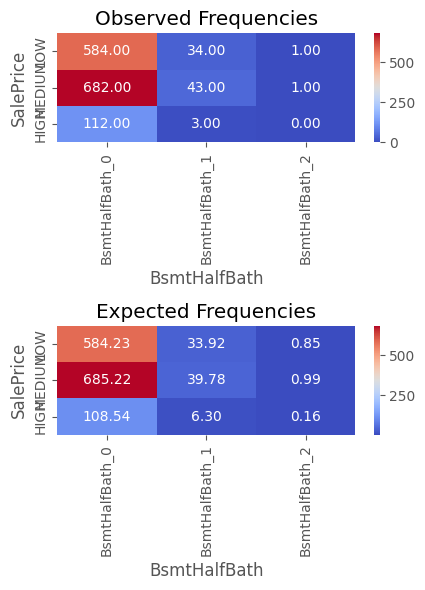

Chi-square Test - Outcome
P-Value: 0.6806487194877051 
Cramer's V - Outcome
Coeff: 0.02806951347725422
0.0014174939544221248


c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


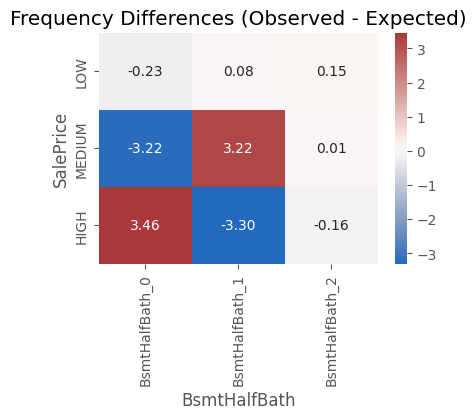

In [484]:
categoric_ordinal_plot(df_copy, 'BsmtHalfBath')

##### FullBath

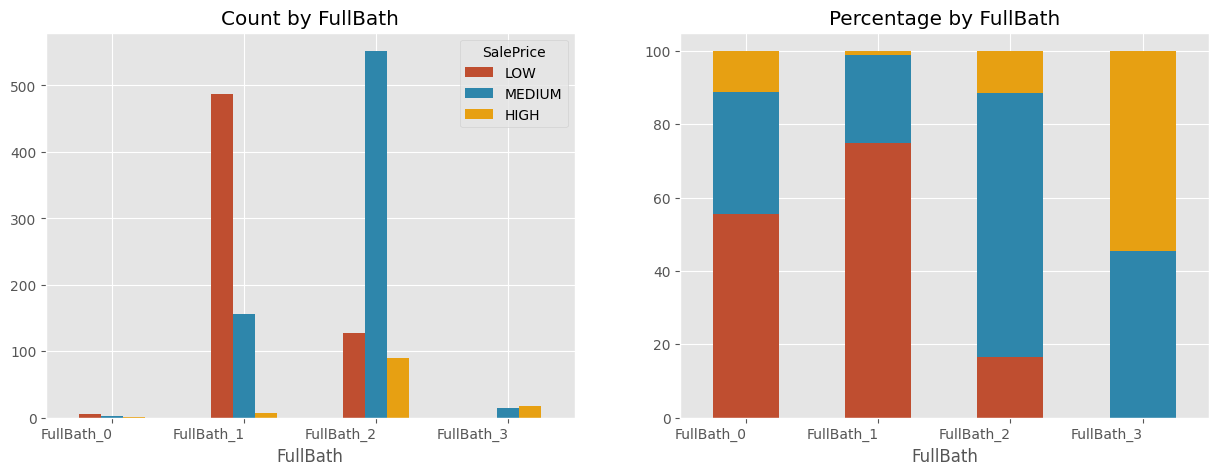

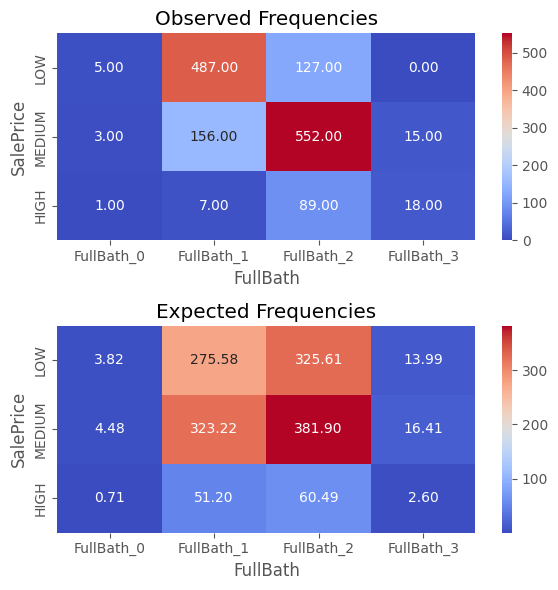

Chi-square Test - Outcome
P-Value: 4.018443251096999e-127 [<0.05]
Cramer's V - Outcome
Coeff: 0.45463384659527495
0.29826715827233946
Understanding FullBath:
	Missing values: 0
	Independence Test: 4.02e-127[<0.05]
	Information Gain: 0.30
	When the FullBath is:
		• FullBath_1, then the sale price is 70% likely to be LOW (44.52% of the times)
		• FullBath_2, then the sale price is 70% likely to be MEDIUM (52.60% of the times)
		• FullBath_0, then the sale price is 55% likely to be LOW (0.62% of the times)
		• FullBath_3, then the sale price is 50% likely to be HIGH (2.26% of the times)




c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


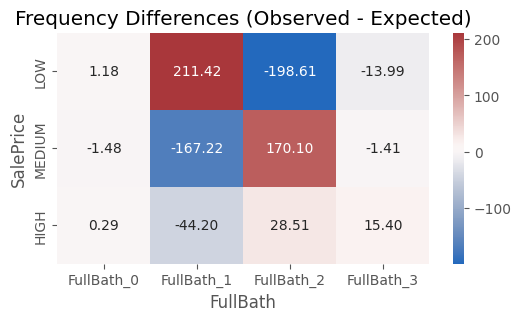

In [485]:
categoric_ordinal_plot(df_copy, 'FullBath')
IG(df, TARGET_FEATURE, 'FullBath')
understand(df_copy, feature_name="FullBath", showplots=False)

##### HalfBath

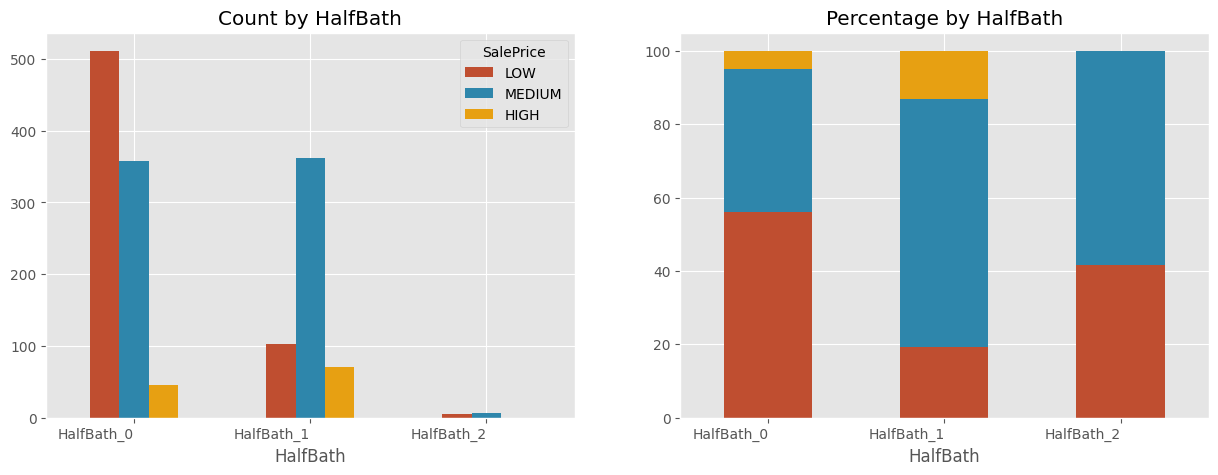

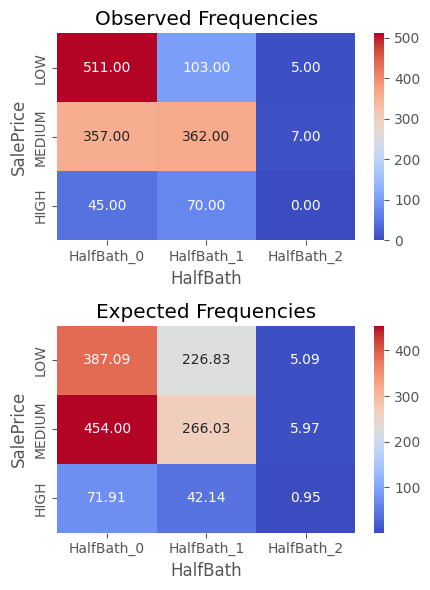

Chi-square Test - Outcome
P-Value: 1.765237242530037e-40 [<0.05]
Cramer's V - Outcome
Coeff: 0.256572472337345
0.10054858198695393


c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


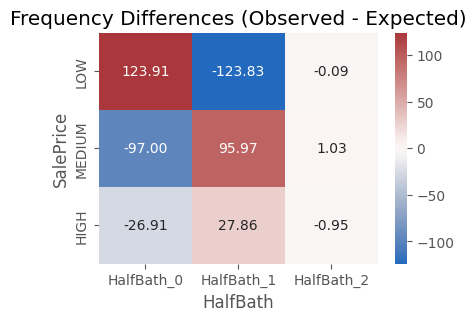

In [486]:
categoric_ordinal_plot(df_copy, 'HalfBath')

##### BedroomAbvGr

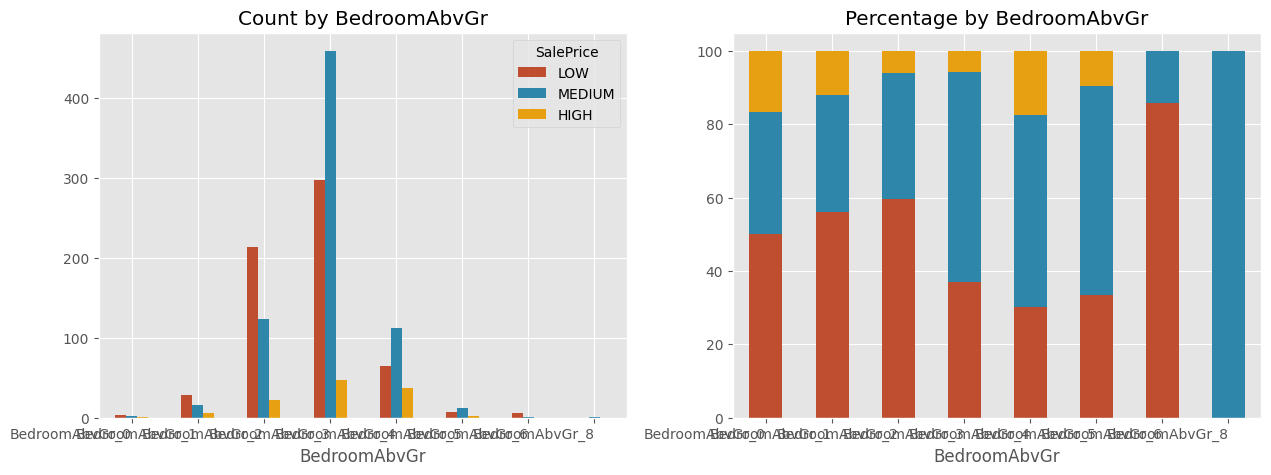

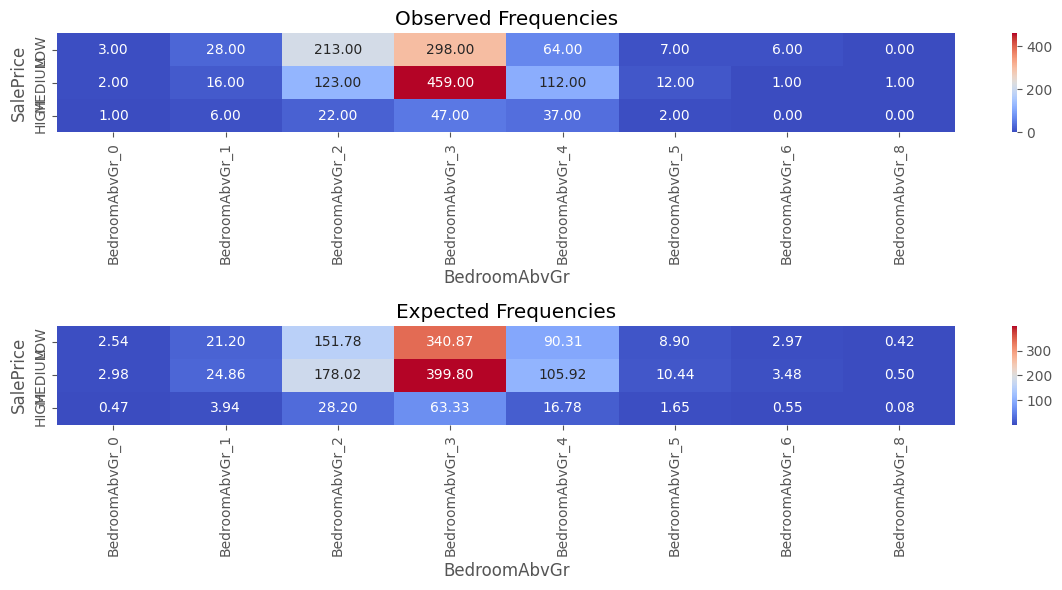

Chi-square Test - Outcome
P-Value: 1.1574262089106492e-16 [<0.05]
Cramer's V - Outcome
Coeff: 0.19264782804260805
0.05116755634206285


c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


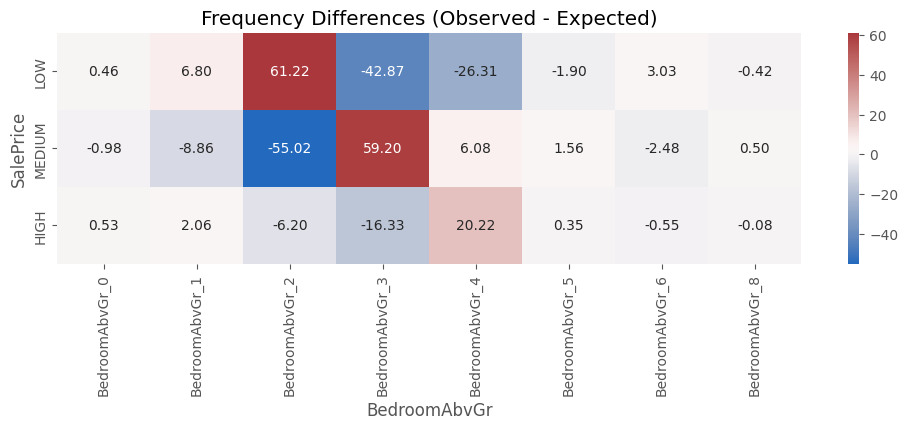

In [487]:
categoric_ordinal_plot(df_copy, 'BedroomAbvGr')

##### KitchenAbvGr

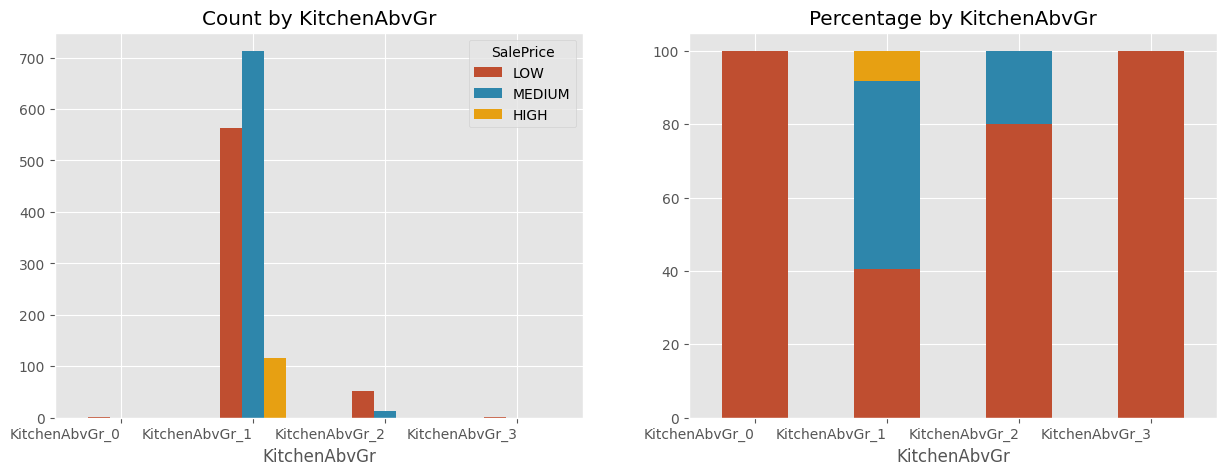

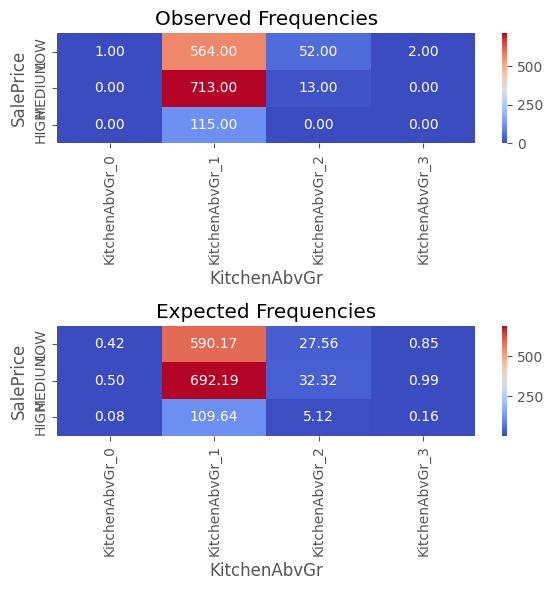

Chi-square Test - Outcome
P-Value: 5.958096086434347e-08 [<0.05]
Cramer's V - Outcome
Coeff: 0.1234105584113776
0.024484826808309997


c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


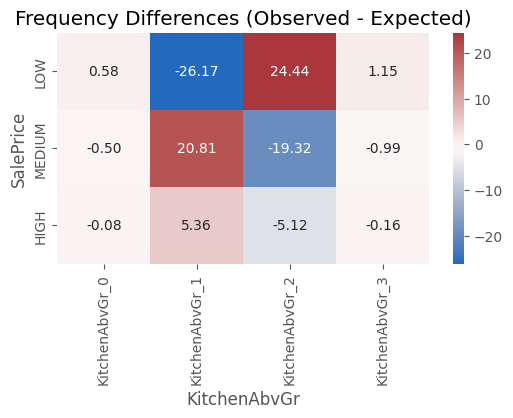

In [488]:
categoric_ordinal_plot(df_copy, 'KitchenAbvGr')

##### KitchenQual

c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.3341239388726758

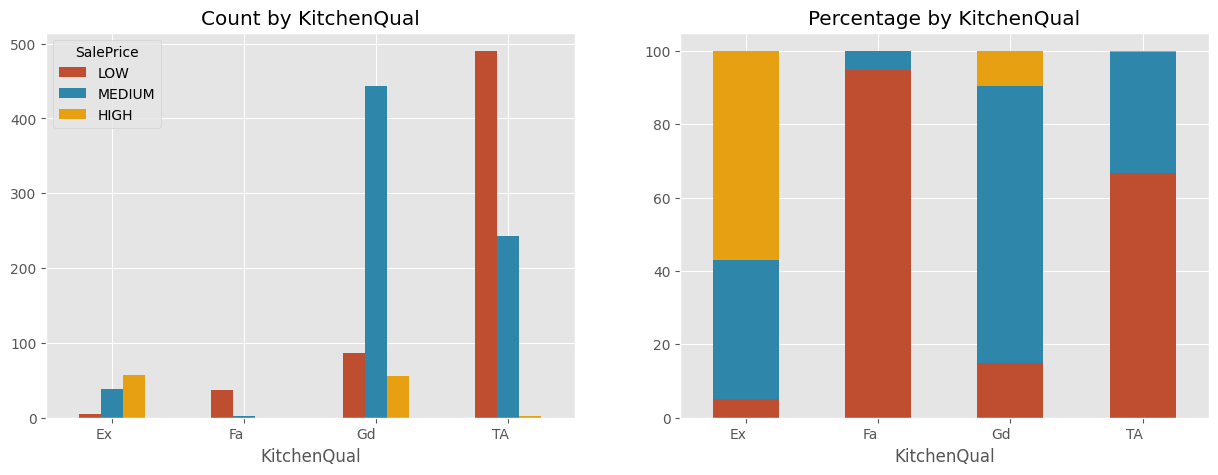

In [489]:
frequencies_and_percentages(df, TARGET_FEATURE, 'KitchenQual')
IG(df, TARGET_FEATURE, 'KitchenQual')

##### TotRmsAbvGrd

c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


ANOVA Test - Outcome
P-Value: 4.972682537673768e-83 [<0.05]


(4.972682537673768e-83, '[<0.05]')

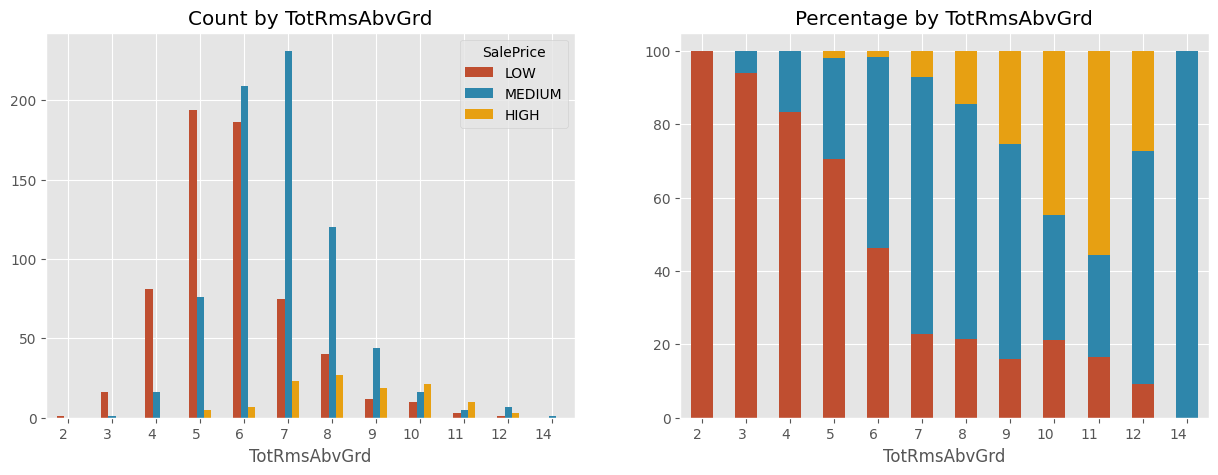

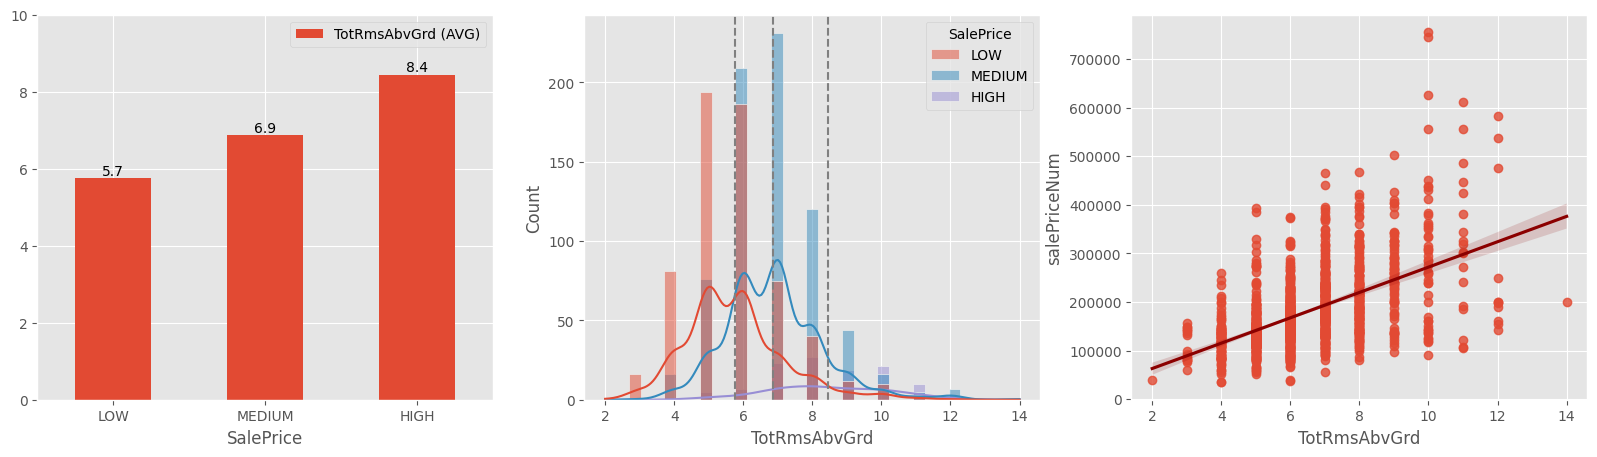

In [490]:
frequencies_and_percentages(df, TARGET_FEATURE, 'TotRmsAbvGrd')
IG(df, TARGET_FEATURE, 'TotRmsAbvGrd')
stattest_quanti(df, 'TotRmsAbvGrd', upper_limit=10)

##### Functional

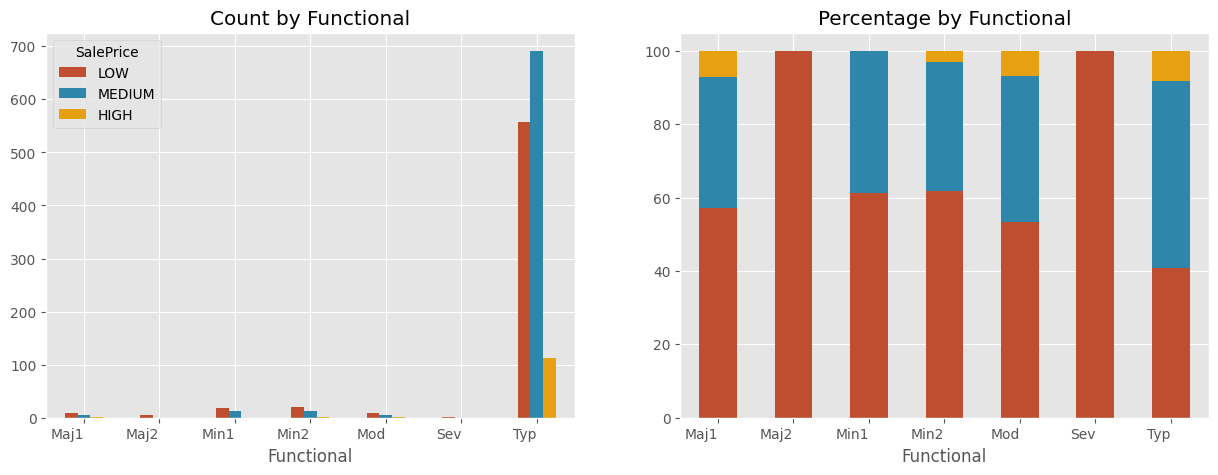

In [491]:
df_copy['Functional'] = df_copy['Functional'].astype('category')
#df_copy['Functional'].unique()
frequencies_and_percentages(df_copy, TARGET_FEATURE, 'Functional')
#stattest_quali(df_copy, 'Functional')

##### Fireplaces

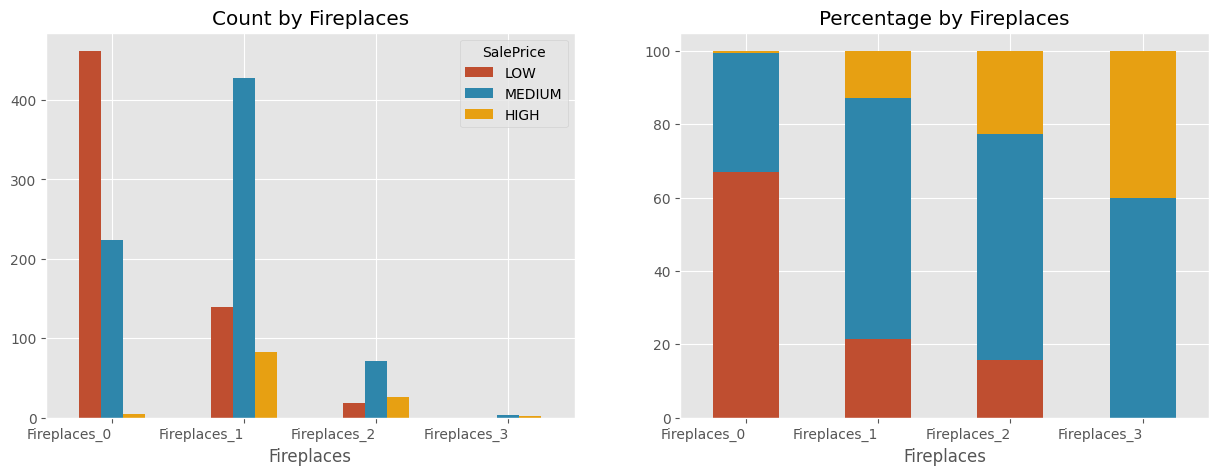

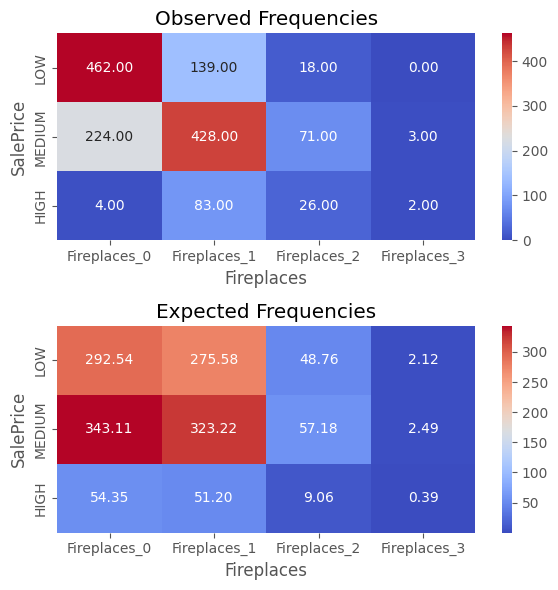

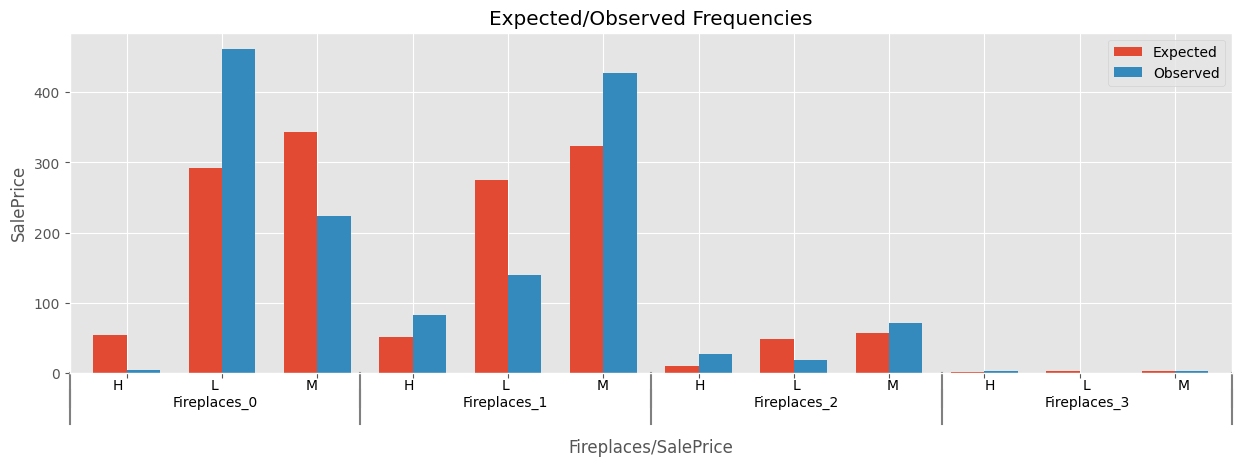

Chi-square Test - Outcome
P-Value: 5.349369497530157e-77 [<0.05]
Cramer's V - Outcome
Coeff: 0.3563365534395304
0.1966071830585545


c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [492]:
categoric_ordinal_plot(df_copy, 'Fireplaces', test_typeplot='barplot')

##### FireplaceQu

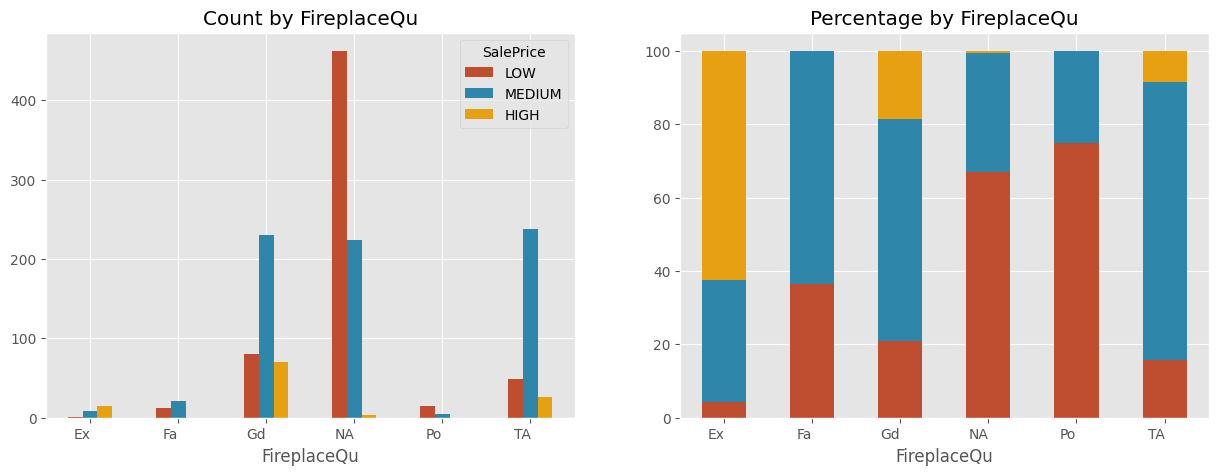

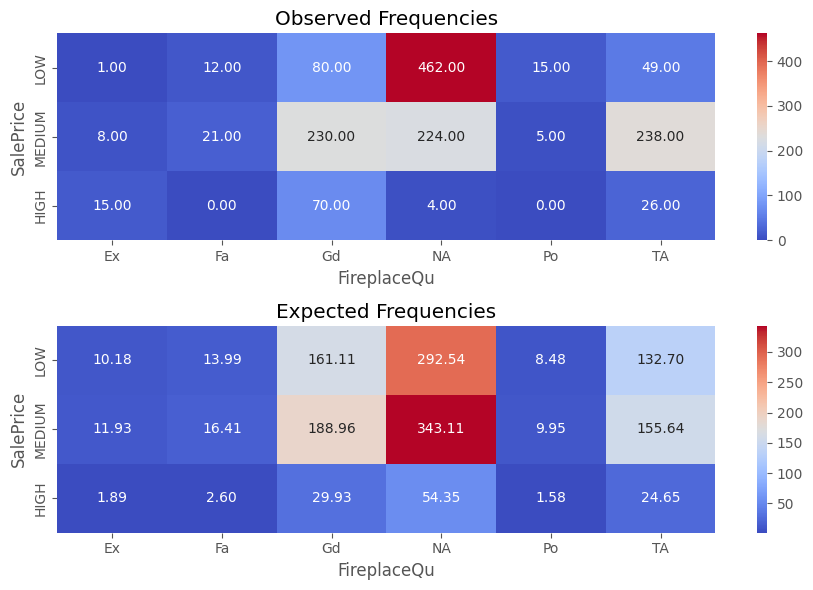

Chi-square Test - Outcome
P-Value: 5.148137174516188e-101 [<0.05]
Cramer's V - Outcome
Coeff: 0.41367367160139384


c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.2386235241672774

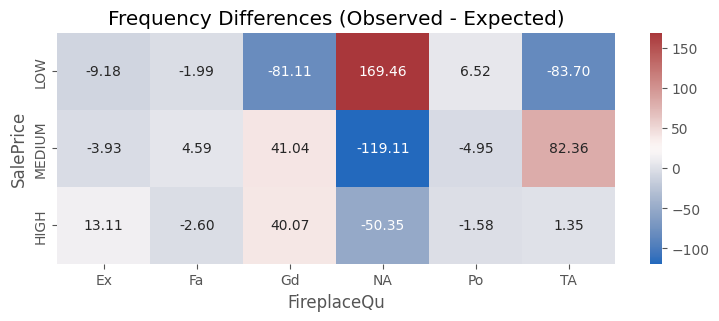

In [493]:
df_copy['FireplaceQu'] = df_copy['FireplaceQu'].astype('category')
frequencies_and_percentages(df_copy, TARGET_FEATURE, 'FireplaceQu')
stattest_quali(df_copy, 'FireplaceQu')
IG(df_copy, TARGET_FEATURE, 'FireplaceQu')

##### GarageType

c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Understanding GarageType:
	Missing values: 81
	Independence Test: 9.58e-90[<0.05]
	Information Gain: 0.24
	When the GarageType is:
		• NA, then the sale price is 95% likely to be LOW (5.55% of the times)
		• CarPort, then the sale price is 85% likely to be LOW (0.62% of the times)
		• Detchd, then the sale price is 75% likely to be LOW (26.51% of the times)
		• BuiltIn, then the sale price is 65% likely to be MEDIUM (6.03% of the times)
		• Attchd, then the sale price is 60% likely to be MEDIUM (59.59% of the times)
		• 2Types+Basment, then the sale price is 50% likely to be LOW (1.71% of the times)




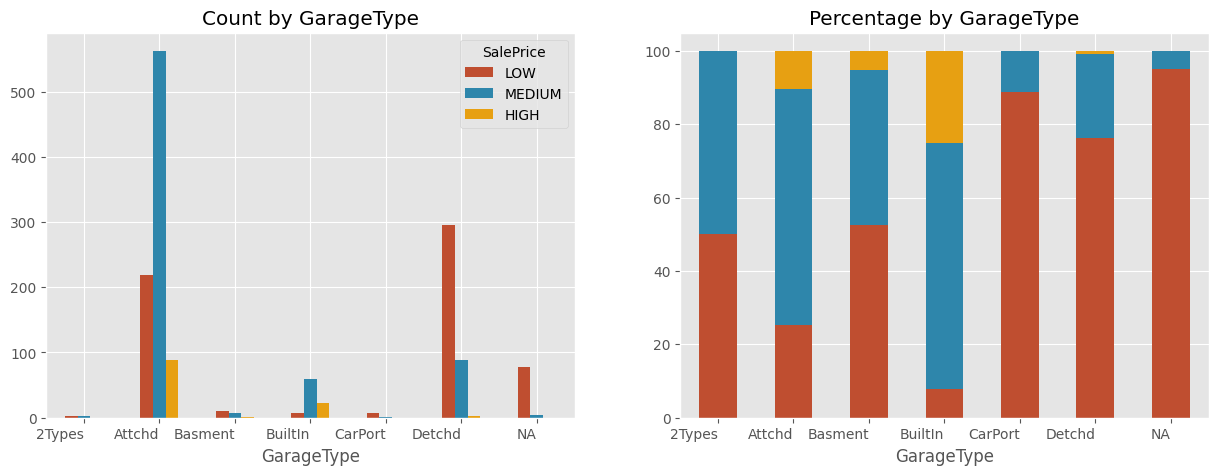

In [494]:
df['GarageType'].unique()
frequencies_and_percentages(df, TARGET_FEATURE, 'GarageType')
IG(df, TARGET_FEATURE, 'GarageType')
understand(dataf=df_copy, feature_name="GarageType", showplots=False)

##### GarageYrBlt

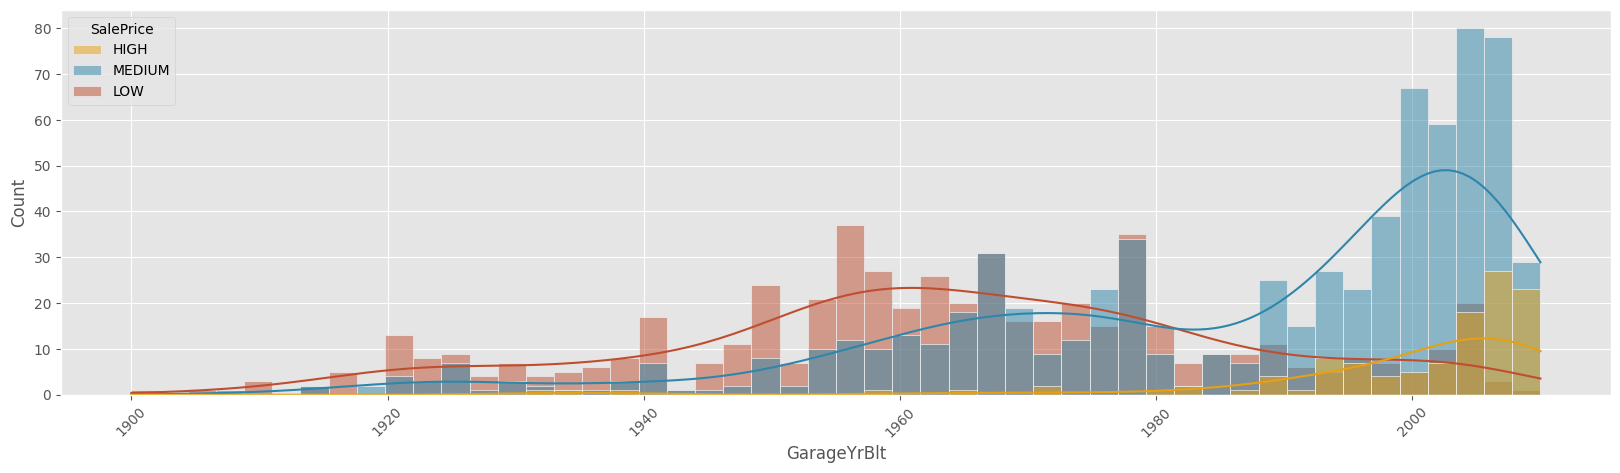

0.825667484174342 0.0
0.48636167748786086 8.70512794214511e-83


(0.48636167748786086, 8.70512794214511e-83)

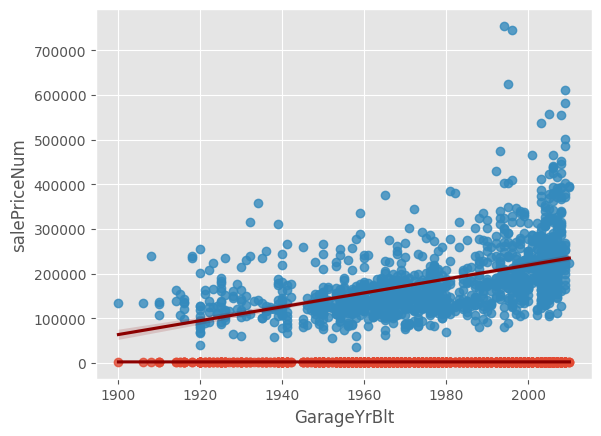

In [495]:
df_copy2 = df_copy.drop(df_copy[df_copy['GarageYrBlt'] == 'NA'].index)
df_copy2['GarageYrBlt'] = df_copy2['GarageYrBlt'].astype("int64")

histplot(df_copy2, TARGET_FEATURE, 'GarageYrBlt', figsize=(20, 5), xticks_rot=45, bins=50)
correlation(df_copy2, 'GarageYrBlt', 'YearBuilt')
correlation(df_copy2, 'GarageYrBlt', TARGET_FEATURE_CONTI)

##### GarageFinish

['RFn' 'Unf' 'Fin' 'NA']


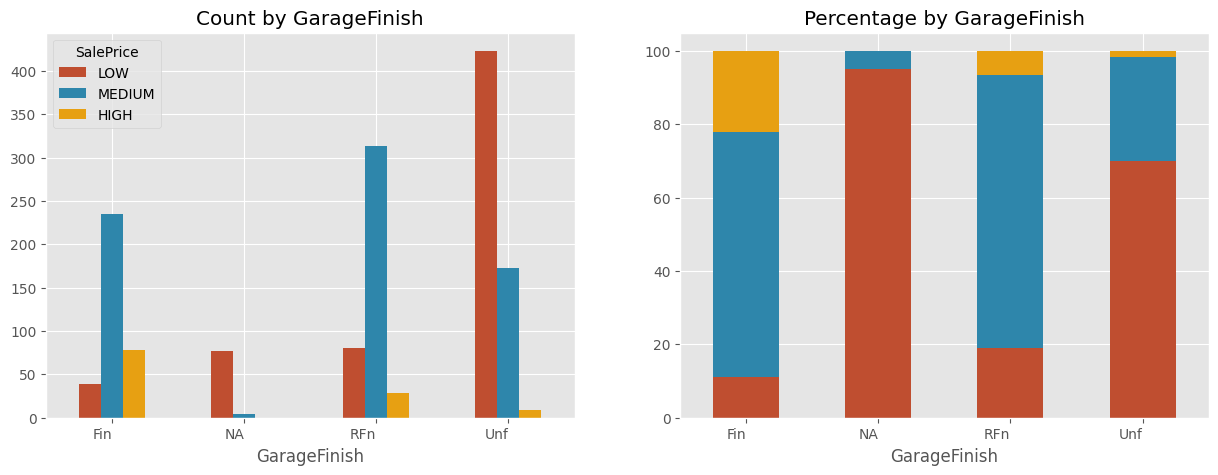

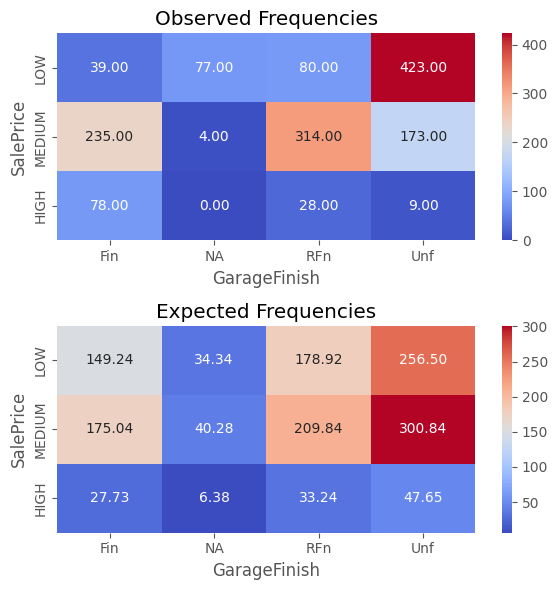

Chi-square Test - Outcome
P-Value: 2.2755608608462434e-123 [<0.05]
Cramer's V - Outcome
Coeff: 0.4480324119716242


c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.3050799574413959

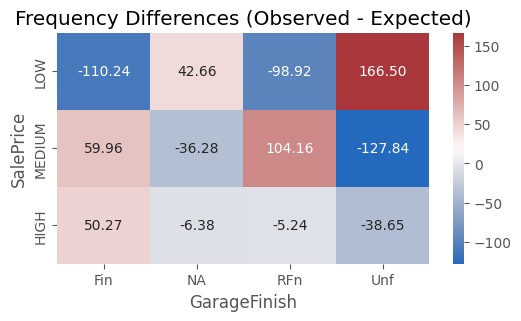

In [496]:
df_copy['GarageFinish'] = df['GarageFinish']
print(df_copy['GarageFinish'].unique())
df_copy['GarageFinish'] = df_copy['GarageFinish'].astype('category')
frequencies_and_percentages(df_copy, TARGET_FEATURE, 'GarageFinish')
stattest_quali(df_copy, 'GarageFinish')
IG(df_copy, TARGET_FEATURE, 'GarageFinish')

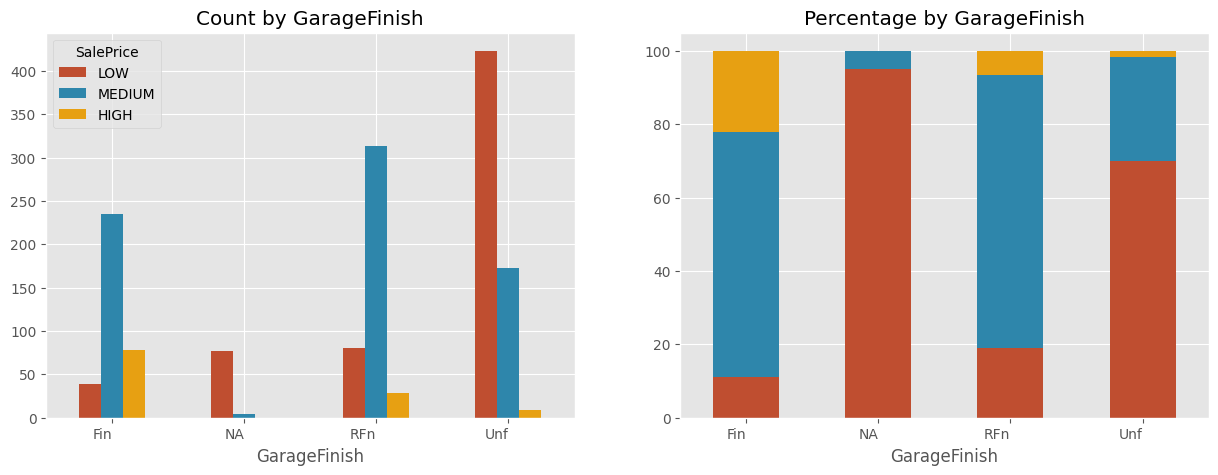

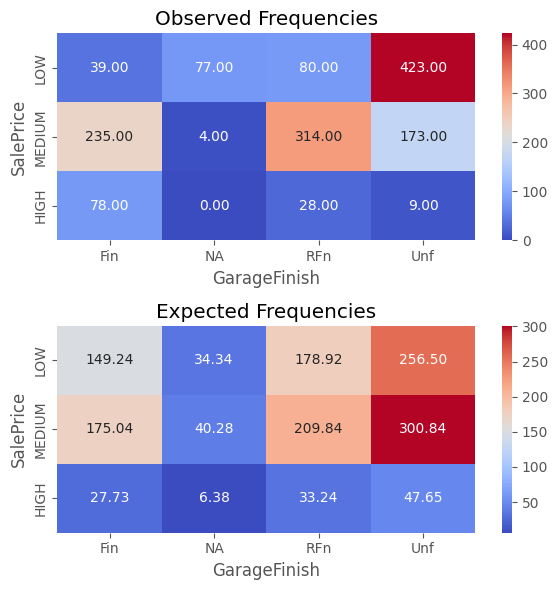

Chi-square Test - Outcome
P-Value: 2.2755608608462434e-123 [<0.05]
Cramer's V - Outcome
Coeff: 0.4480324119716242
Understanding GarageFinish:
	Missing values: 0
	Independence Test: 2.28e-123[<0.05]
	Information Gain: 0.31
	When the GarageFinish is:
		• NA, then the sale price is 95% likely to be LOW (5.55% of the times)
		• RFn, then the sale price is 70% likely to be MEDIUM (28.90% of the times)
		• Fin, then the sale price is 65% likely to be MEDIUM (24.11% of the times)
		• Unf, then the sale price is 65% likely to be LOW (41.44% of the times)




c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


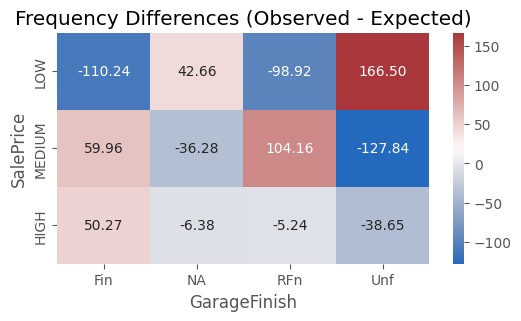

In [497]:
understand(df_copy, 'GarageFinish', 'category', showplots=True, na = 0)

##### GarageCars

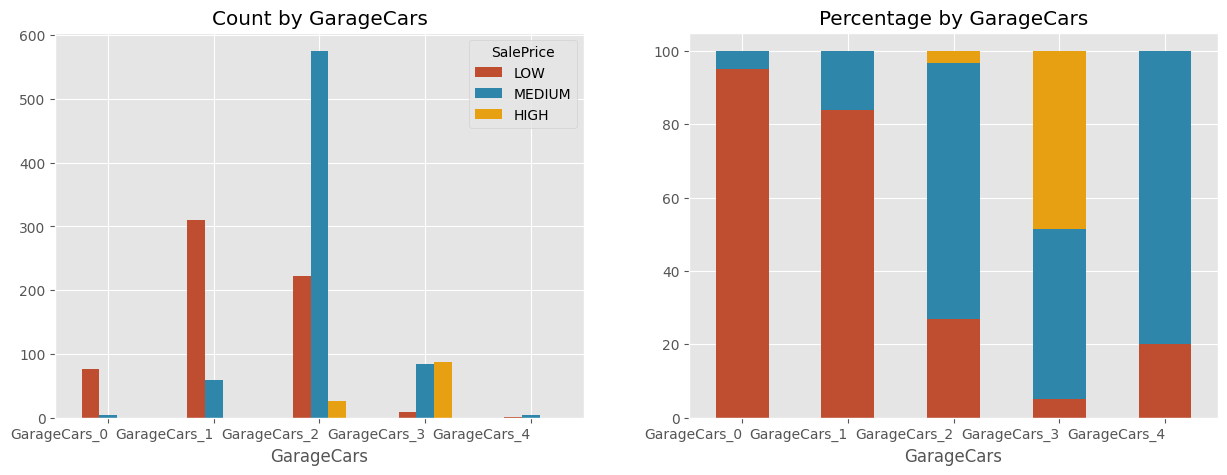

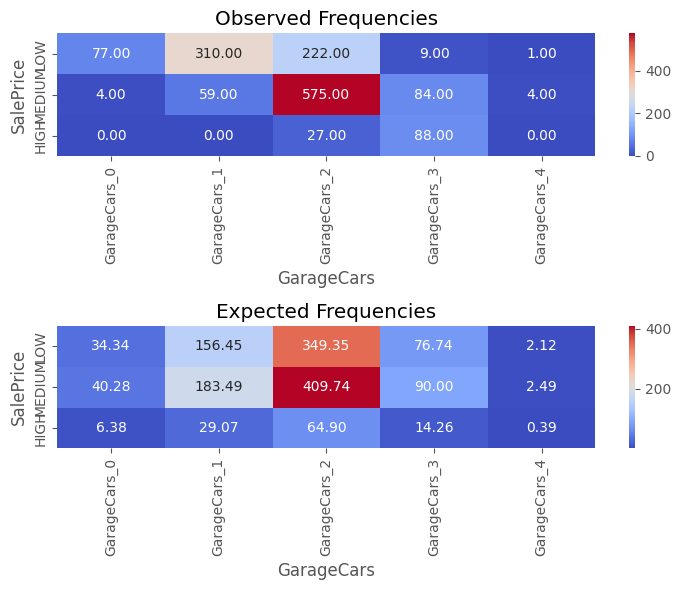

Chi-square Test - Outcome
P-Value: 1.5623976548288065e-196 [<0.05]
Cramer's V - Outcome
Coeff: 0.5658775647887696
0.3999207328264048


c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


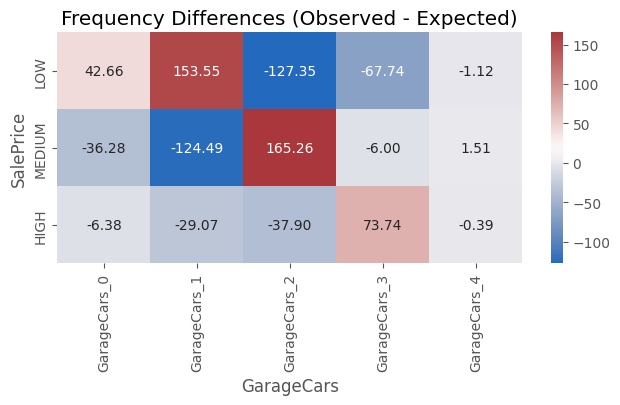

In [498]:
# understand(df_copy, 'GarageCars', 'category', showplots=True)
categoric_ordinal_plot(df_copy, 'GarageCars')

##### GarageArea

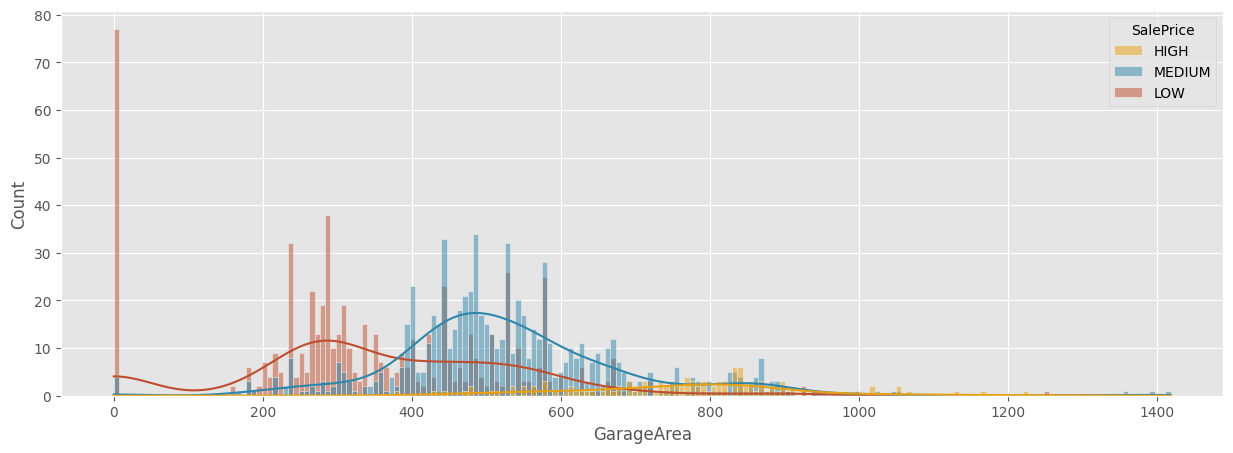

ANOVA Test - Outcome
P-Value: 0.0 [<0.05]


(0.0, '[<0.05]')

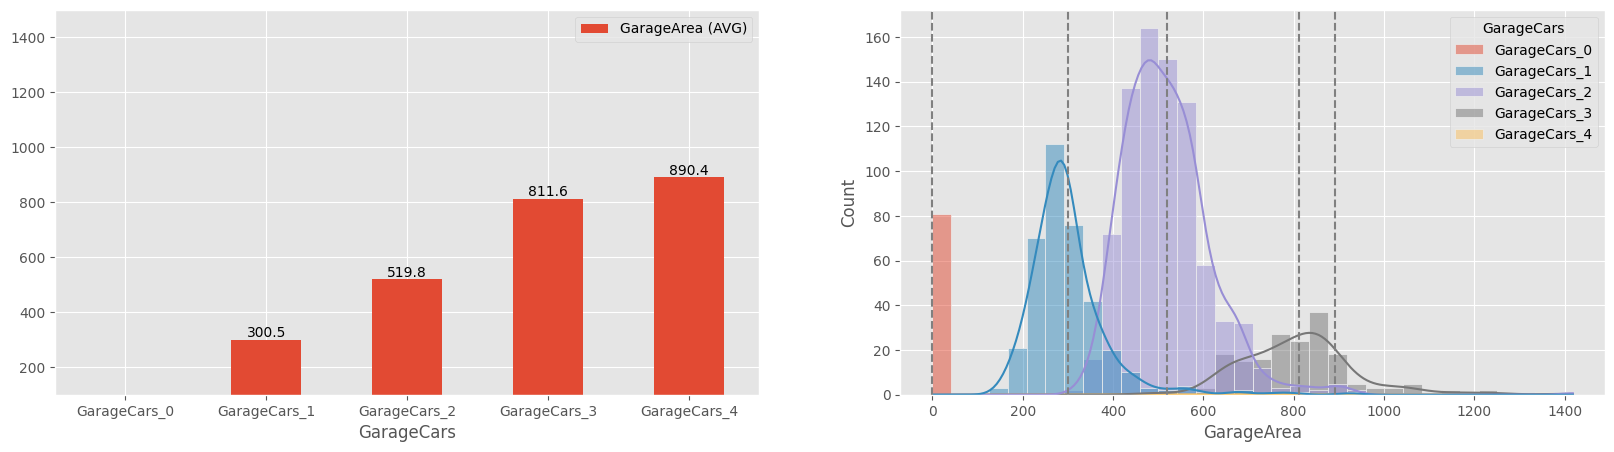

In [499]:
histplot(df_copy,TARGET_FEATURE ,'GarageArea', bins=200)
# correlation(df_copy,'GarageCars','GarageArea')
stattest_quanti(df_copy, 'GarageArea', 'GarageCars', low_limit= 100, upper_limit= 1500)

##### GarageQual

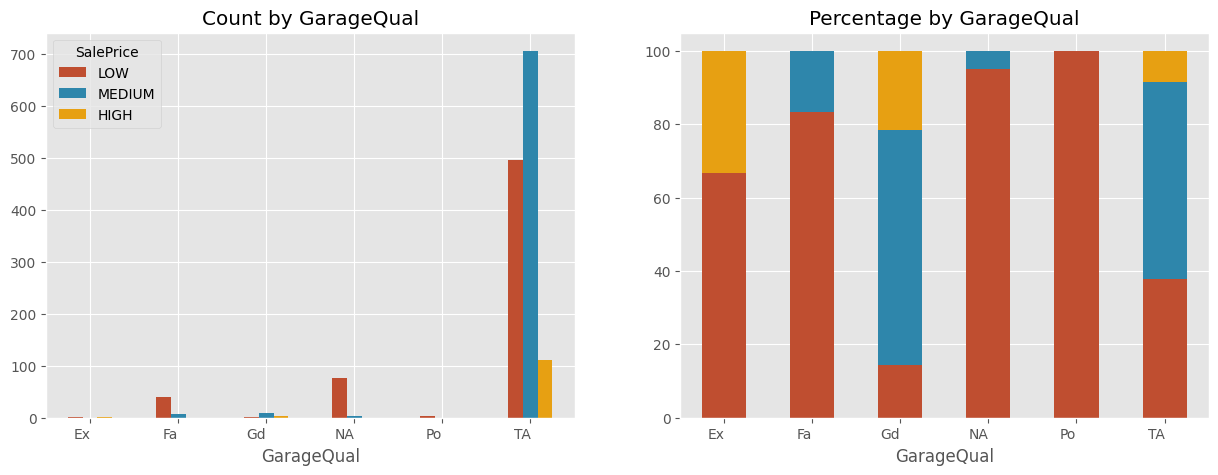

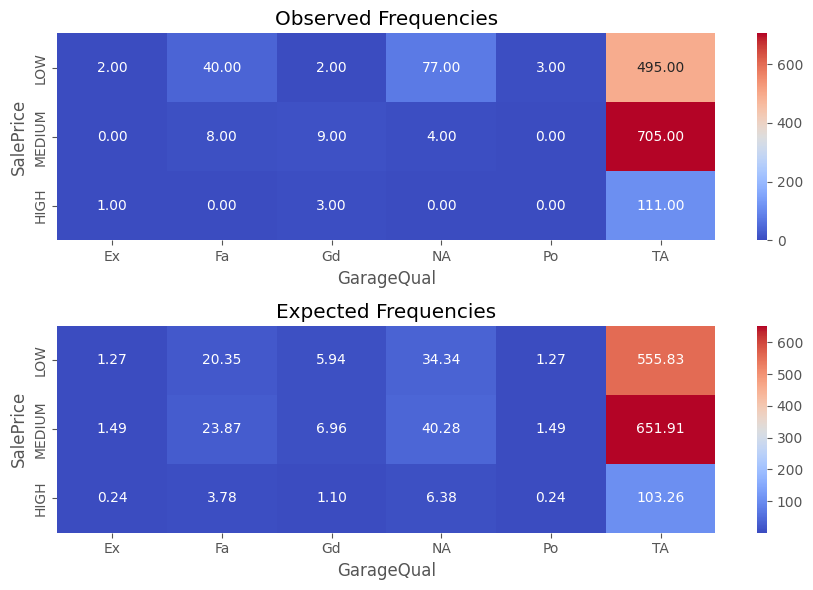

Chi-square Test - Outcome
P-Value: 1.5658170784469491e-27 [<0.05]
Cramer's V - Outcome
Coeff: 0.22802784686572622
Understanding GarageQual:
	Missing values: 0
	Independence Test: 1.57e-27[<0.05]
	Information Gain: 0.08
	When the GarageQual is:
		• Po, then the sale price is LOW (0.21% of the times)
		• NA, then the sale price is 95% likely to be LOW (5.55% of the times)
		• Fa, then the sale price is 80% likely to be LOW (3.29% of the times)
		• Ex, then the sale price is 65% likely to be LOW (0.21% of the times)
		• Gd, then the sale price is 60% likely to be MEDIUM (0.96% of the times)
		• TA, then the sale price is 50% likely to be MEDIUM (89.79% of the times)




c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


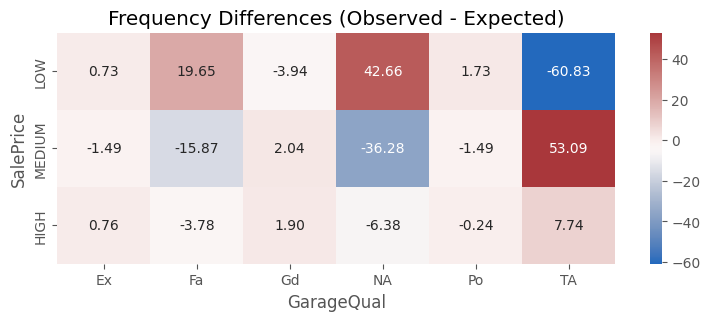

In [500]:
understand(df_copy,'GarageQual',dtype='category',showplots=True,na=0)

##### GarageCond

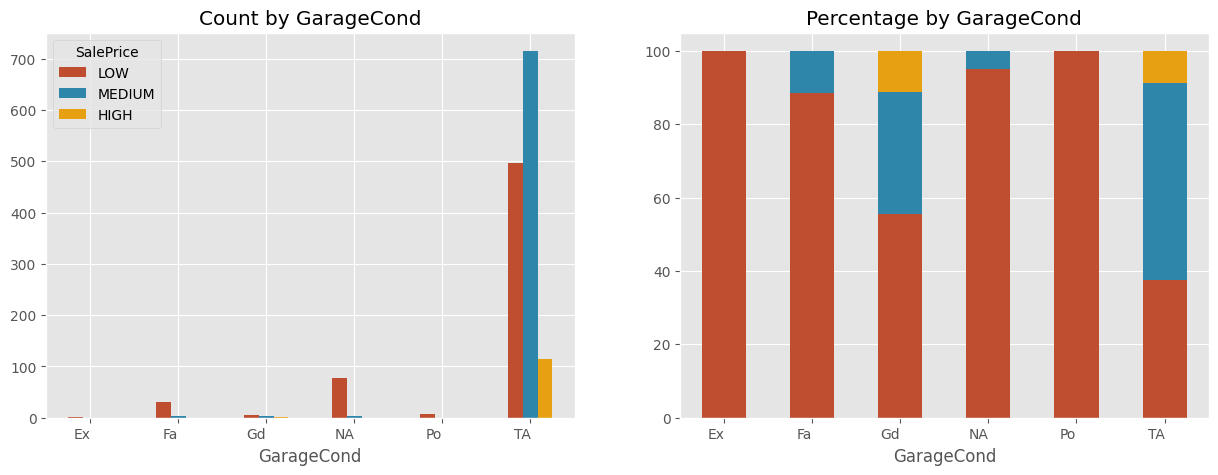

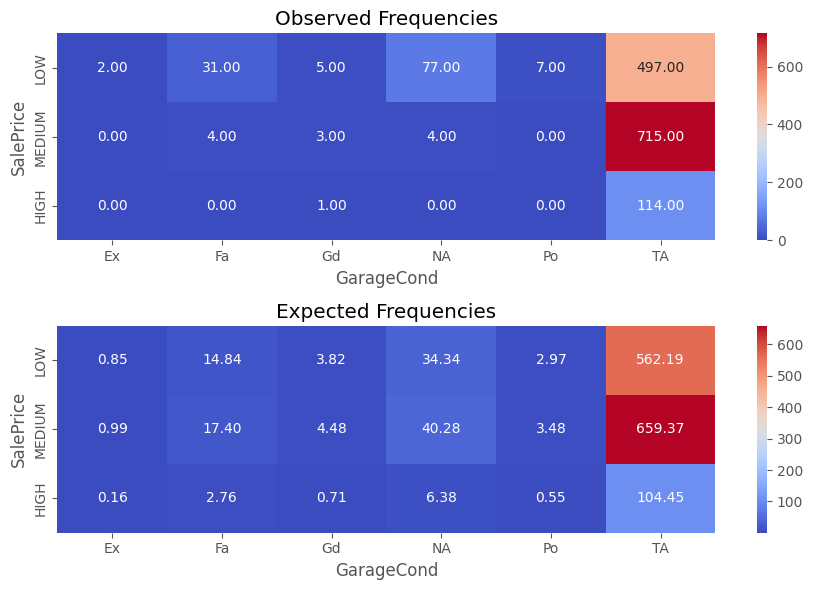

Chi-square Test - Outcome
P-Value: 5.837262851283957e-27 [<0.05]
Cramer's V - Outcome
Coeff: 0.22593259599407634
Understanding GarageCond:
	Missing values: 81
	Independence Test: 5.84e-27[<0.05]
	Information Gain: 0.08
	When the GarageCond is:
		• Ex+Po, then the sale price is LOW (0.62% of the times)
		• NA, then the sale price is 95% likely to be LOW (5.55% of the times)
		• Fa, then the sale price is 85% likely to be LOW (2.40% of the times)
		• Gd, then the sale price is 55% likely to be LOW (0.62% of the times)
		• TA, then the sale price is 50% likely to be MEDIUM (90.82% of the times)




c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


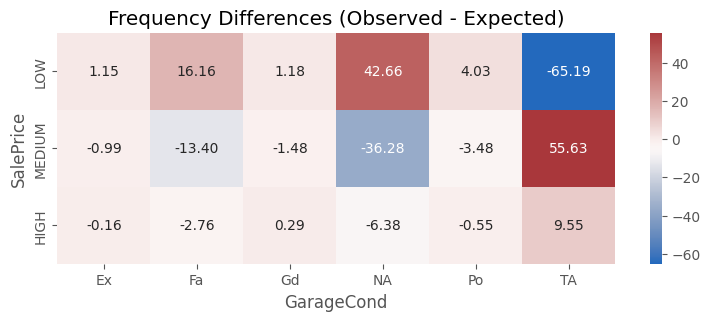

In [501]:
understand(df_copy,'GarageCond')

##### PavedDrive

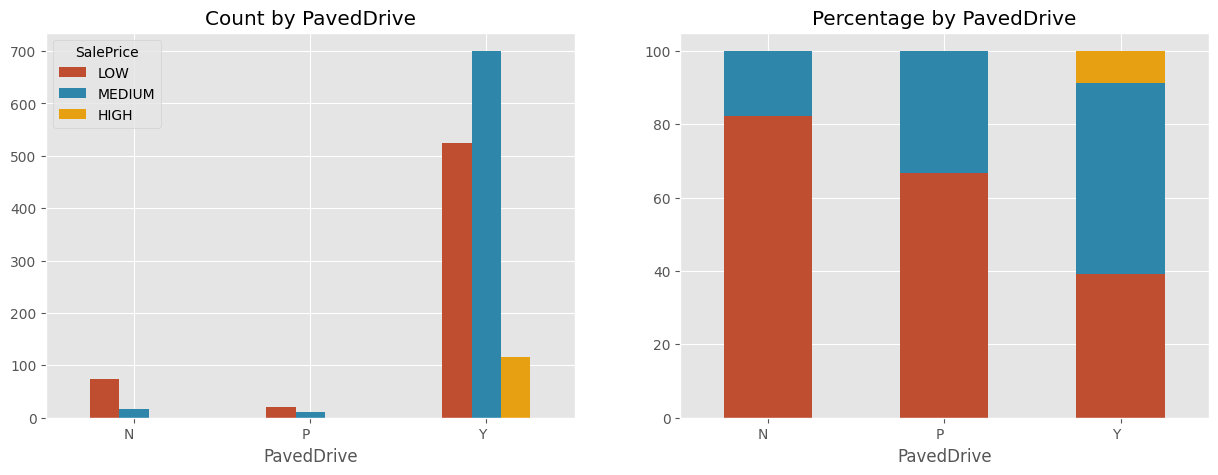

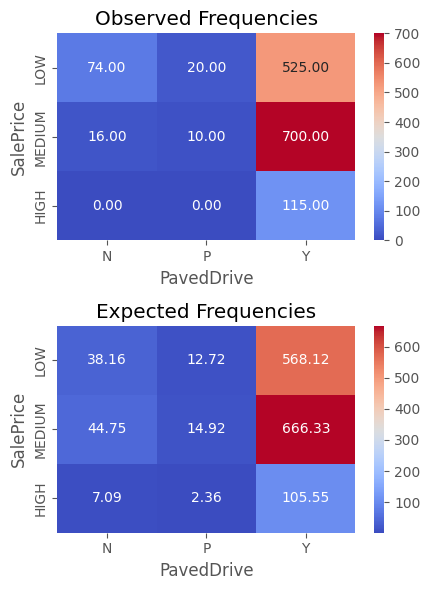

Chi-square Test - Outcome
P-Value: 4.777722451310024e-15 [<0.05]
Cramer's V - Outcome
Coeff: 0.15833436554542402
Understanding PavedDrive:
	Missing values: 0
	Independence Test: 4.78e-15[<0.05]
	Information Gain: 0.04
	When the PavedDrive is:
		• N, then the sale price is 80% likely to be LOW (6.16% of the times)
		• P, then the sale price is 65% likely to be LOW (2.05% of the times)
		• Y, then the sale price is 50% likely to be MEDIUM (91.78% of the times)




c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


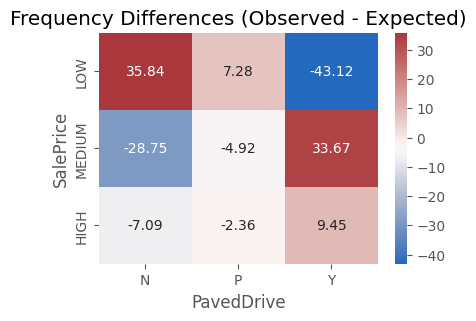

In [502]:
understand(df_copy,'PavedDrive')

##### WoodDeckSF

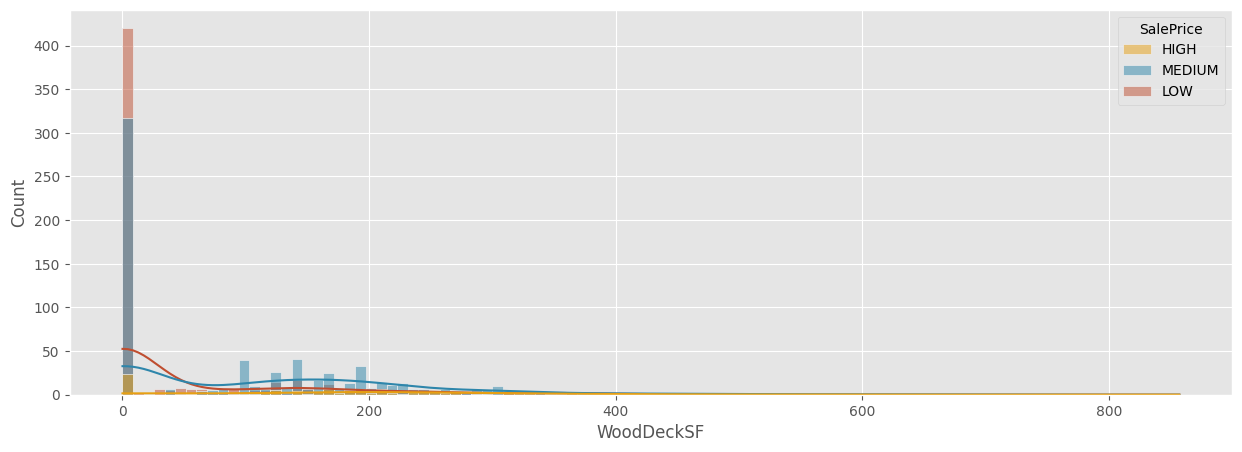

Understanding WoodDeckSF:
	Missing values: 0
	Independence Test: 1.12e-34[<0.05]
	Correlation Index: 0.32
	Correlation p_value: 3.97e-37



In [503]:
understand(df_copy, 'WoodDeckSF', dtype='int', bins=100, upper_limit=400)

##### OpenPorchSF

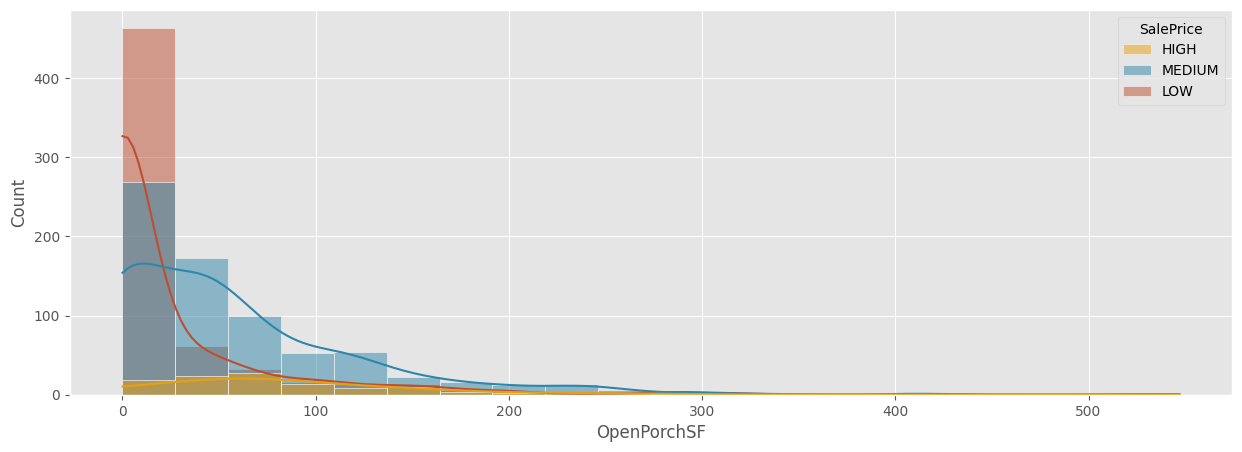

Understanding OpenPorchSF:
	Missing values: 0
	Independence Test: 3.15e-33[<0.05]
	Correlation Index: 0.32
	Correlation p_value: 3.49e-35



In [504]:
understand(df_copy, 'OpenPorchSF', dtype='int', bins=20)

##### EnclosedPorch

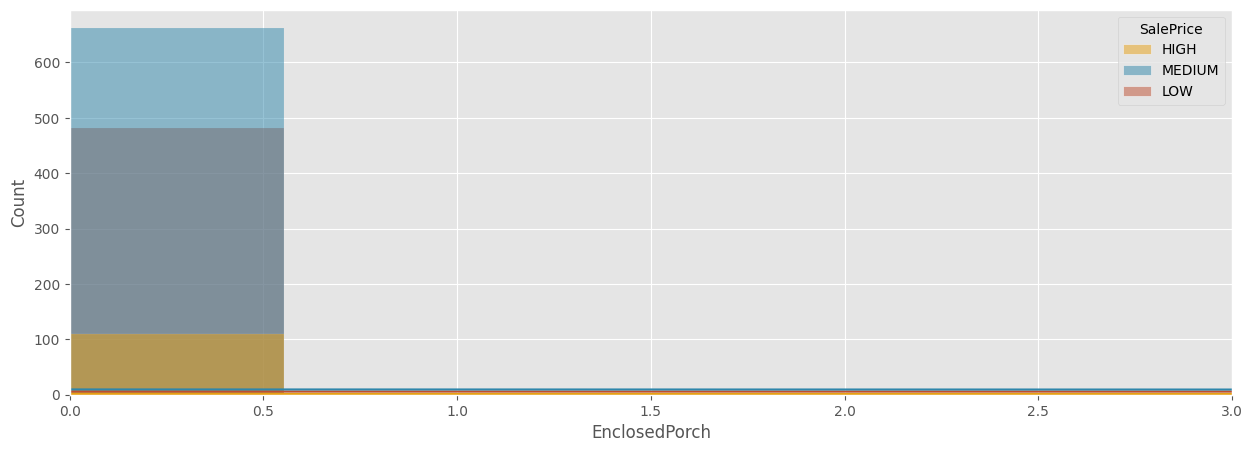

Understanding EnclosedPorch:
	Missing values: 0
	Independence Test: 5.12e-07[<0.05]
	Correlation Index: -0.13
	Correlation p_value: 8.26e-07



In [505]:
understand(df_copy, 'EnclosedPorch', dtype='int', bins=1000, xlim=(0,3))

##### 3SsnPorch

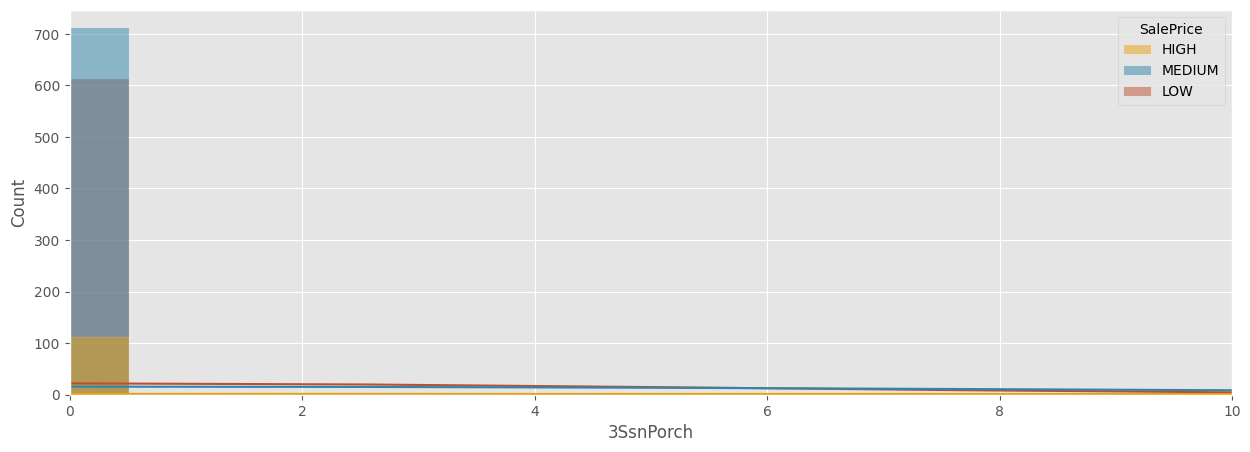

Understanding 3SsnPorch:
	Missing values: 0
	Independence Test: 2.40e-01
	Correlation Index: 0.04
	Correlation p_value: 8.86e-02



In [506]:
understand(df_copy, '3SsnPorch', dtype='int', bins=1000, xlim=(0,10))

##### ScreenPorch

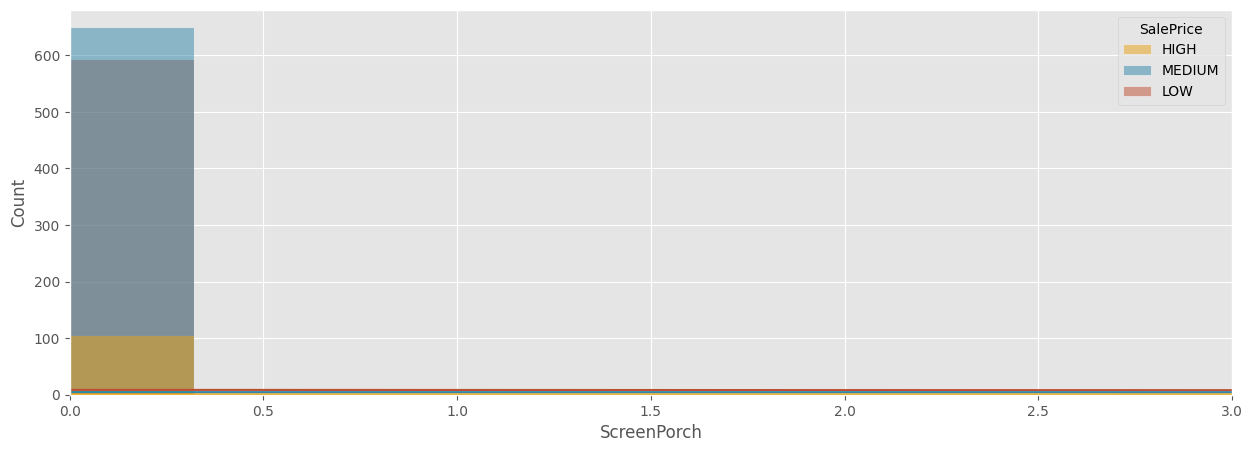

Understanding ScreenPorch:
	Missing values: 0
	Independence Test: 1.59e-06[<0.05]
	Correlation Index: 0.11
	Correlation p_value: 1.97e-05



In [507]:
understand(df_copy, 'ScreenPorch', dtype='int', bins=1500, xlim=(0,3))


##### PoolArea

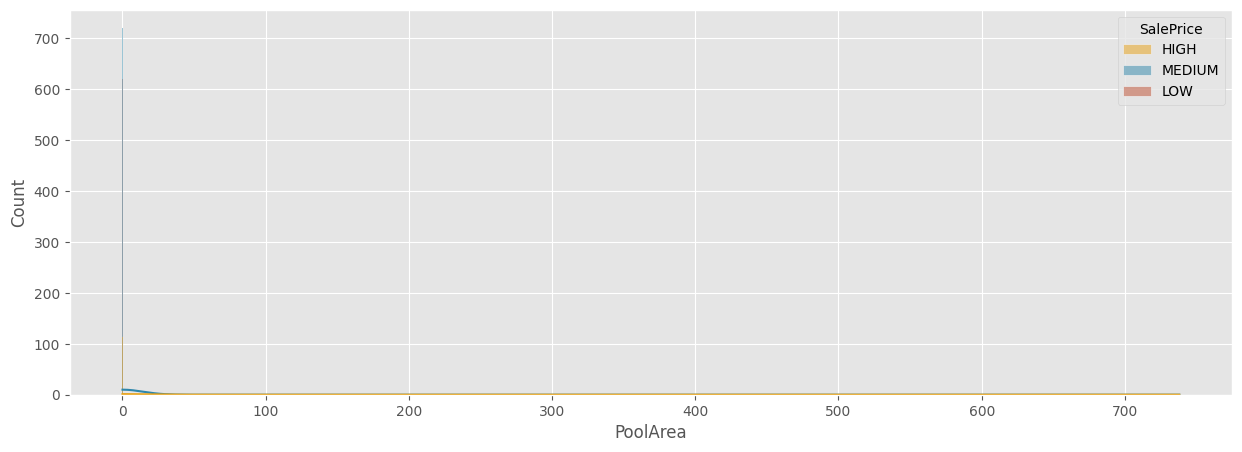

Understanding PoolArea:
	Missing values: 0
	Independence Test: 7.93e-02
	Correlation Index: 0.09
	Correlation p_value: 4.07e-04



In [508]:
understand(df_copy, 'PoolArea', dtype='int', bins=1500)

##### PoolQC

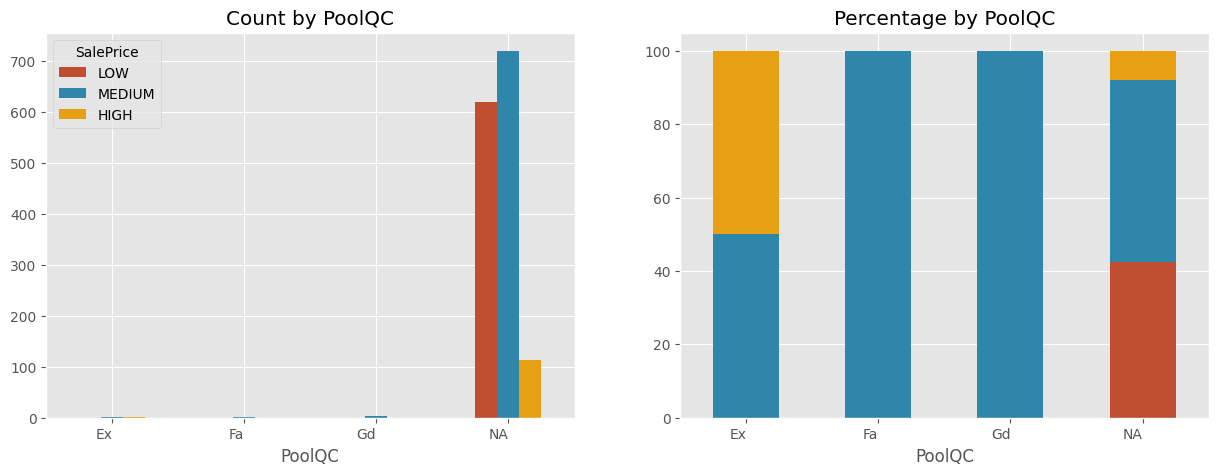

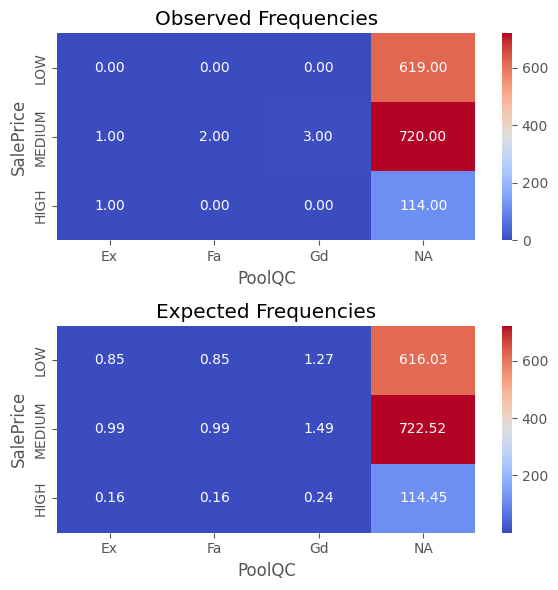

Chi-square Test - Outcome
P-Value: 0.10755220456771697 
Cramer's V - Outcome
Coeff: 0.05977489745520364
Understanding PoolQC:
	Missing values: 0
	Independence Test: 1.08e-01
	Information Gain: 0.01
	When the PoolQC is:
		• Fa+Gd, then the sale price is MEDIUM (0.34% of the times)
		• Ex, then the sale price is 50% likely to be MEDIUM (0.14% of the times)
		• NA, then the sale price is 45% likely to be MEDIUM (99.52% of the times)




c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


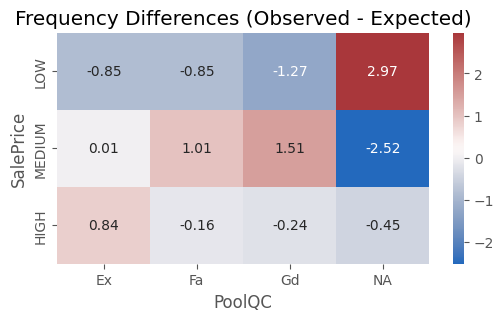

In [509]:
understand(dataf=df_copy, feature_name= 'PoolQC', na = 0)

##### Fence

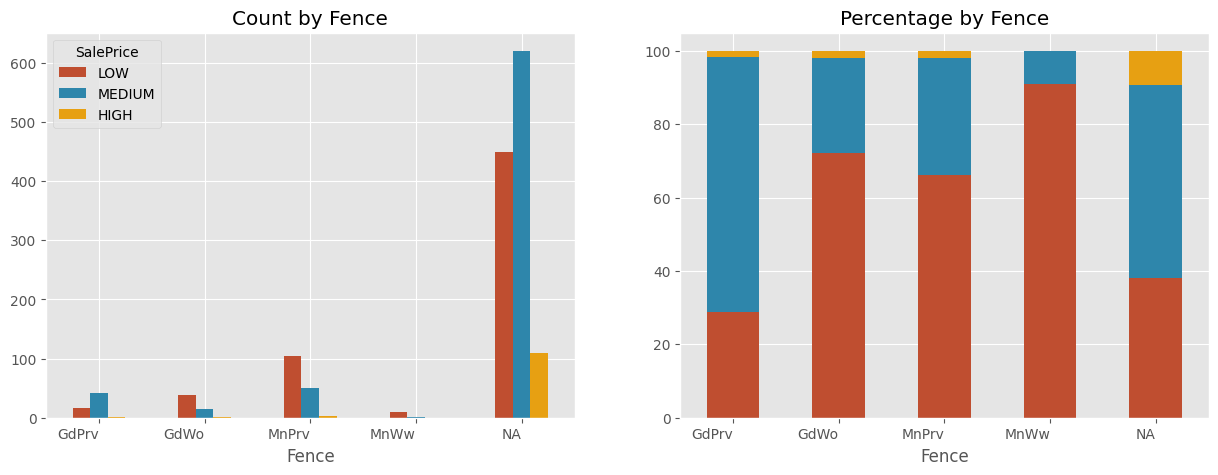

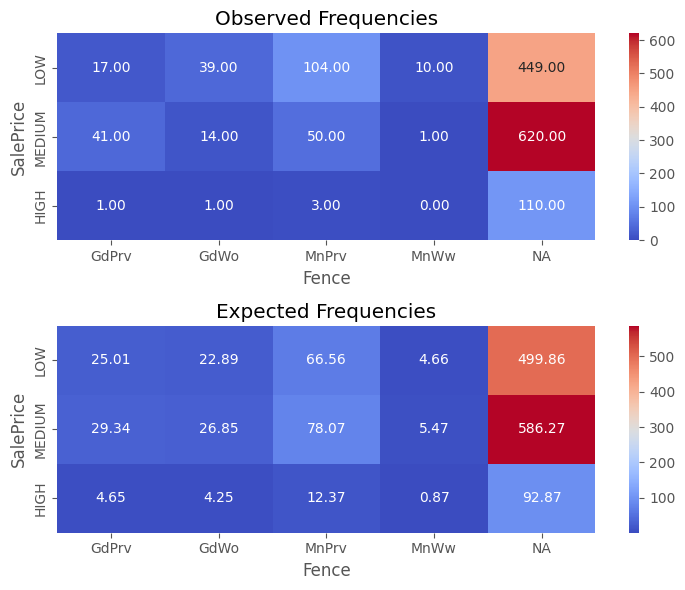

Chi-square Test - Outcome
P-Value: 6.825903732579082e-16 [<0.05]
Cramer's V - Outcome
Coeff: 0.174758863353414
Understanding Fence:
	Missing values: 0
	Independence Test: 6.83e-16[<0.05]
	Information Gain: 0.05
	When the Fence is:
		• MnWw, then the sale price is 90% likely to be LOW (0.75% of the times)
		• GdWo, then the sale price is 70% likely to be LOW (3.70% of the times)
		• GdPrv, then the sale price is 65% likely to be MEDIUM (4.04% of the times)
		• MnPrv, then the sale price is 65% likely to be LOW (10.75% of the times)
		• NA, then the sale price is 50% likely to be MEDIUM (80.75% of the times)




c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


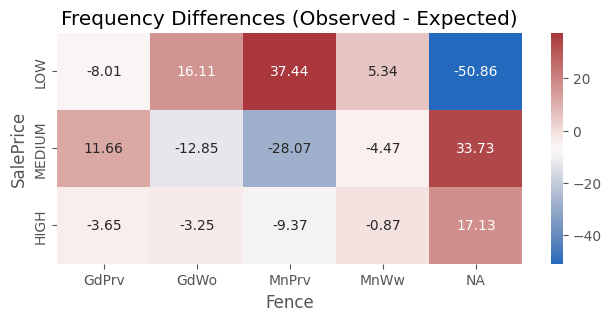

In [510]:
understand(dataf=df_copy, feature_name= 'Fence', na = 0)


##### MiscFeature

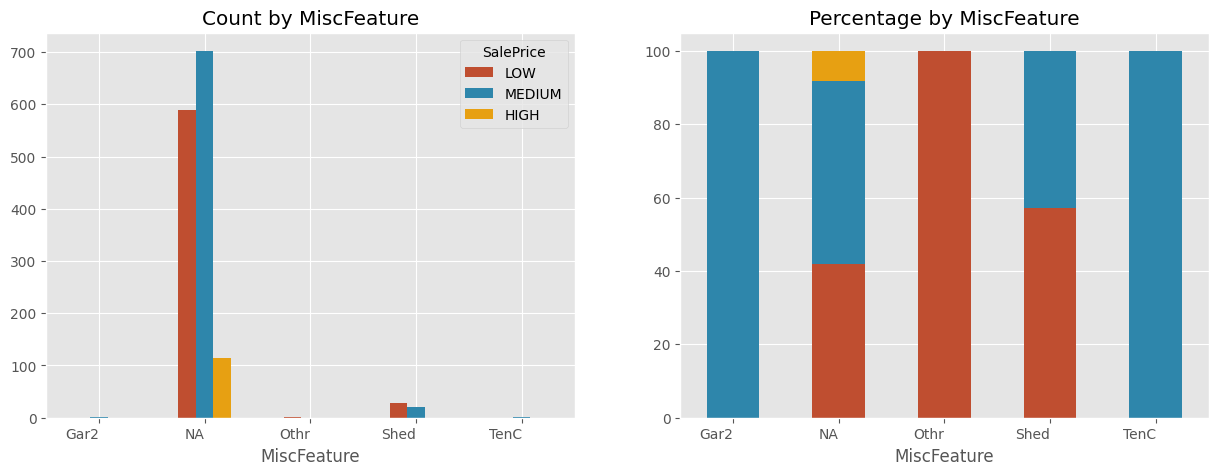

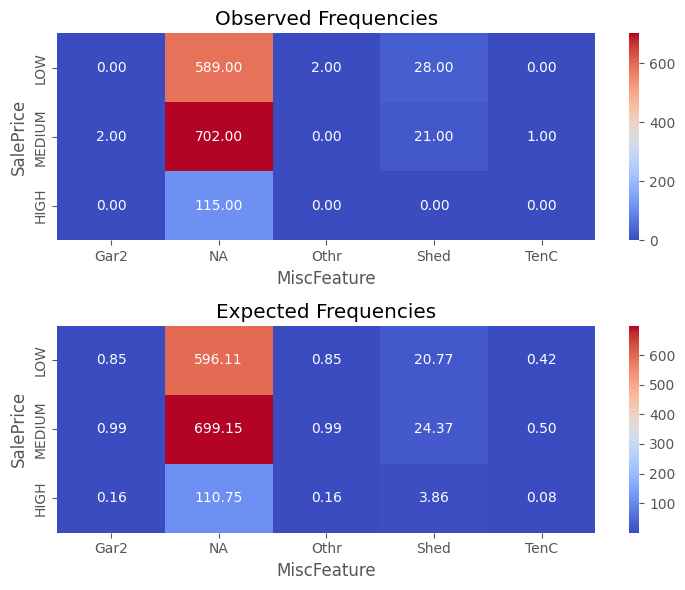

Chi-square Test - Outcome
P-Value: 0.11720562475052677 
Cramer's V - Outcome
Coeff: 0.06633119495612459
Understanding MiscFeature:
	Missing values: 0
	Independence Test: 1.17e-01
	Information Gain: 0.01
	When the MiscFeature is:
		• Othr, then the sale price is LOW (0.14% of the times)
		• Gar2+TenC, then the sale price is MEDIUM (0.21% of the times)
		• Shed, then the sale price is 55% likely to be LOW (3.36% of the times)
		• NA, then the sale price is 45% likely to be MEDIUM (96.30% of the times)




c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


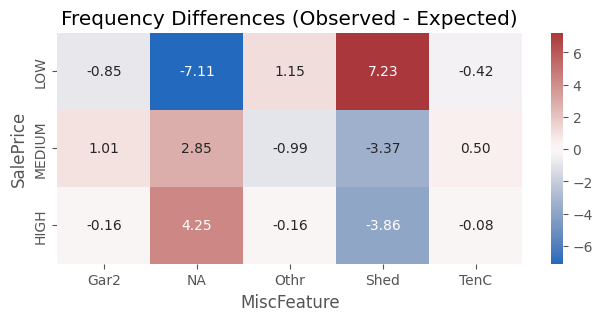

In [511]:
understand(dataf=df_copy, feature_name= 'MiscFeature', na = 0)


##### MiscVal

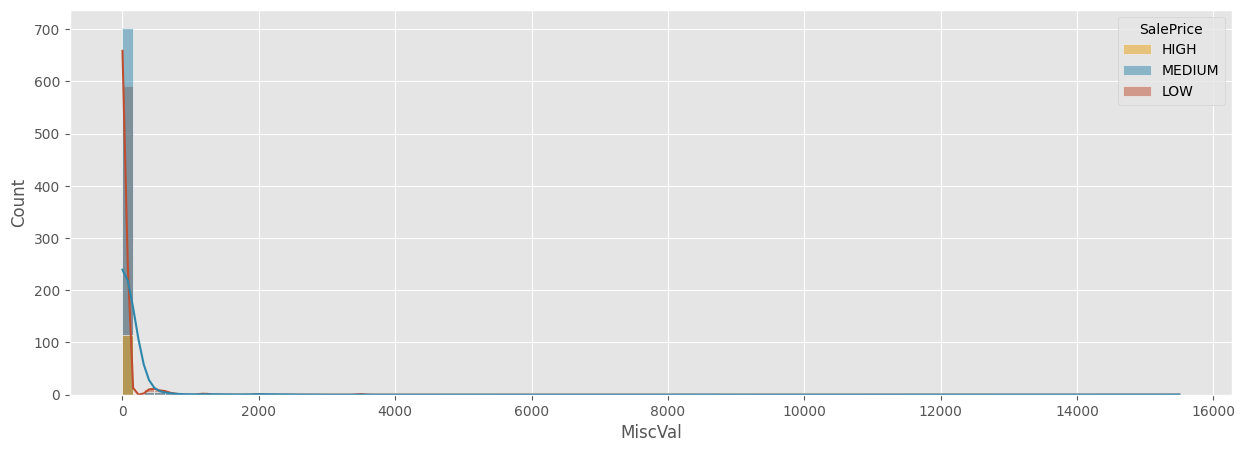

Understanding MiscVal:
	Missing values: 0
	Independence Test: 3.64e-01
	Correlation Index: -0.02
	Correlation p_value: 4.18e-01



In [512]:
understand(df_copy, 'MiscVal', dtype='int', bins=100)

##### MoSold

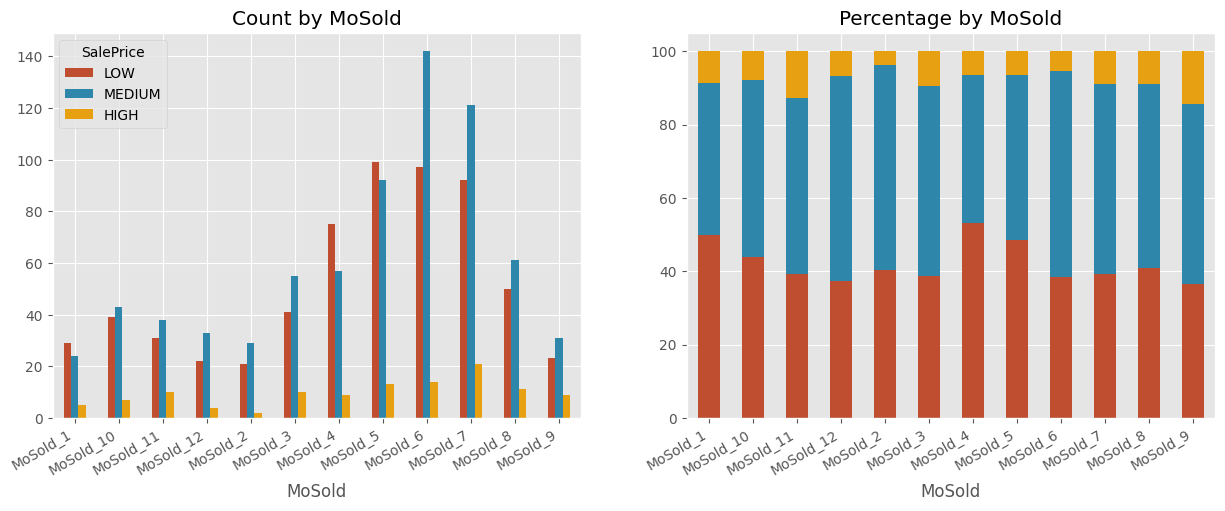

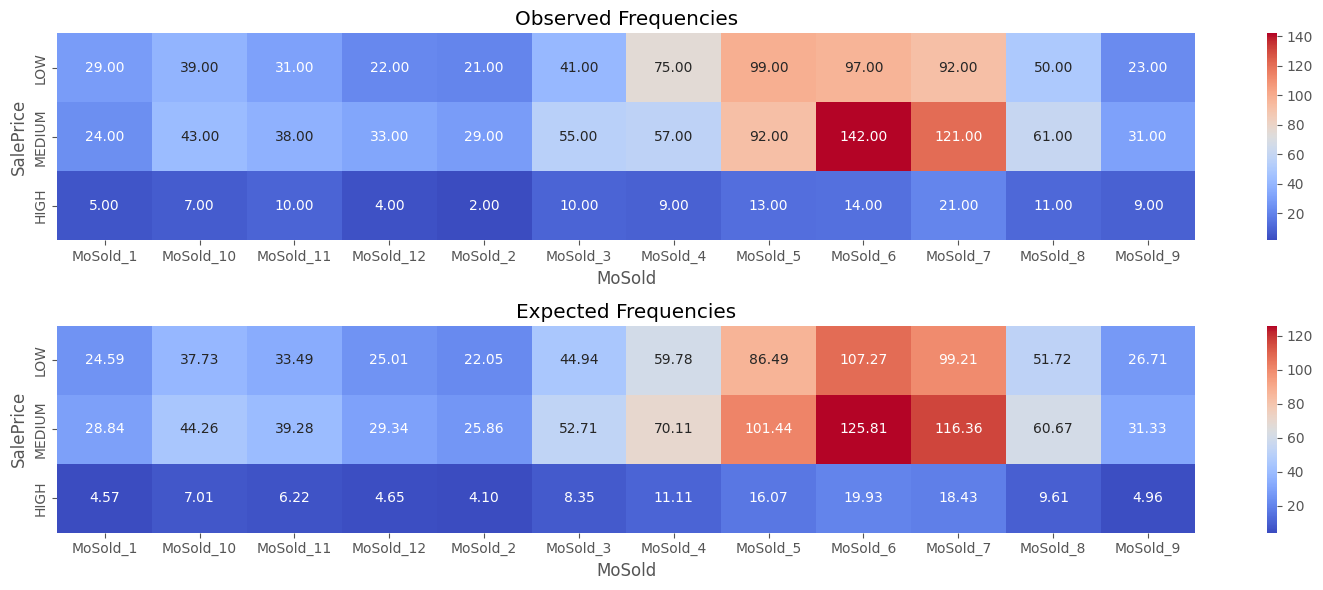

Chi-square Test - Outcome
P-Value: 0.19672812545573468 
Cramer's V - Outcome
Coeff: 0.09685398914194049
Understanding MoSold:
	Missing values: 0
	Independence Test: 1.97e-01
	Information Gain: 0.01
	When the MoSold is:
		• MoSold_12+MoSold_2+MoSold_6, then the sale price is 55% likely to be MEDIUM (24.93% of the times)
		• MoSold_1+MoSold_4, then the sale price is 50% likely to be LOW (13.63% of the times)
		• MoSold_3+MoSold_7+MoSold_8, then the sale price is 50% likely to be MEDIUM (31.64% of the times)
		• MoSold_5, then the sale price is 45% likely to be LOW (13.97% of the times)
		• MoSold_10+MoSold_11+MoSold_9, then the sale price is 45% likely to be MEDIUM (15.82% of the times)




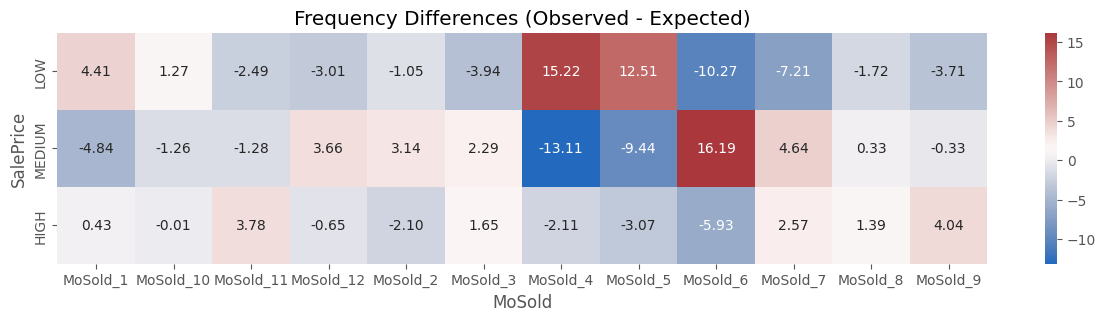

In [513]:
understand(dataf=df_copy, feature_name='MoSold', dtype='object', rotation=30)

##### YrSold

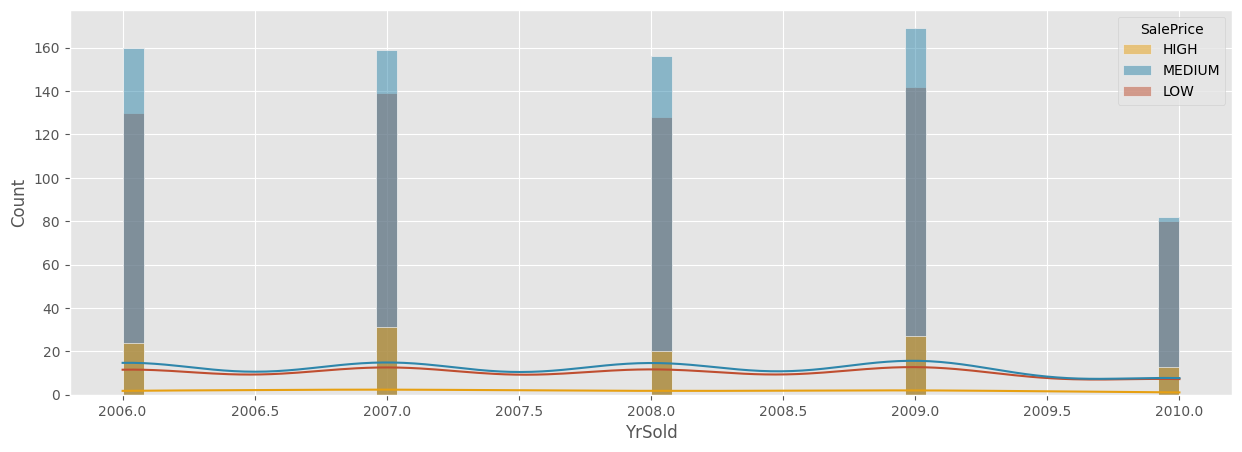

Understanding YrSold:
	Missing values: 0
	Independence Test: 7.80e-01
	Correlation Index: -0.03
	Correlation p_value: 2.69e-01



In [514]:
understand(df_copy, 'YrSold', dtype='int', upper_limit=2023, low_limit= 2000)

##### SaleType

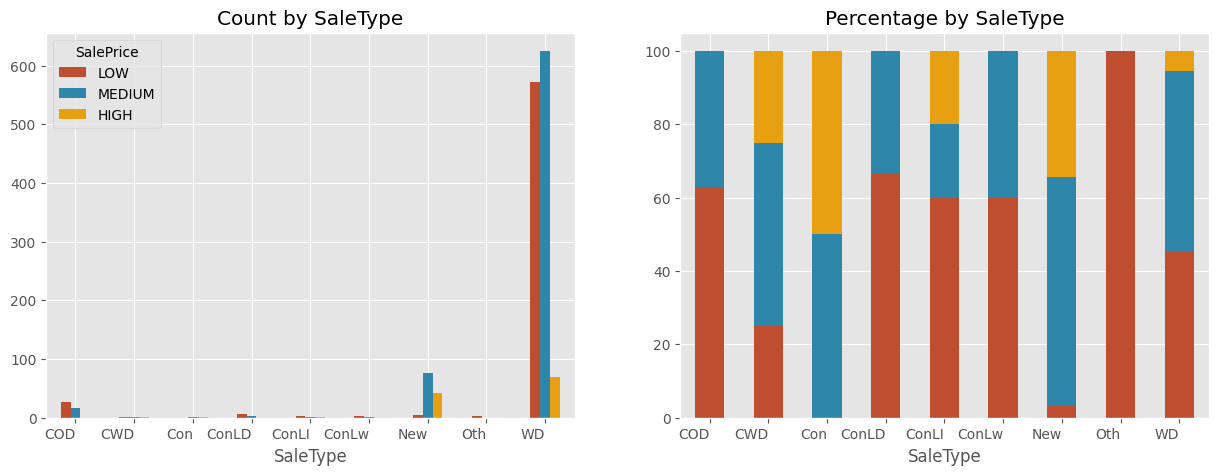

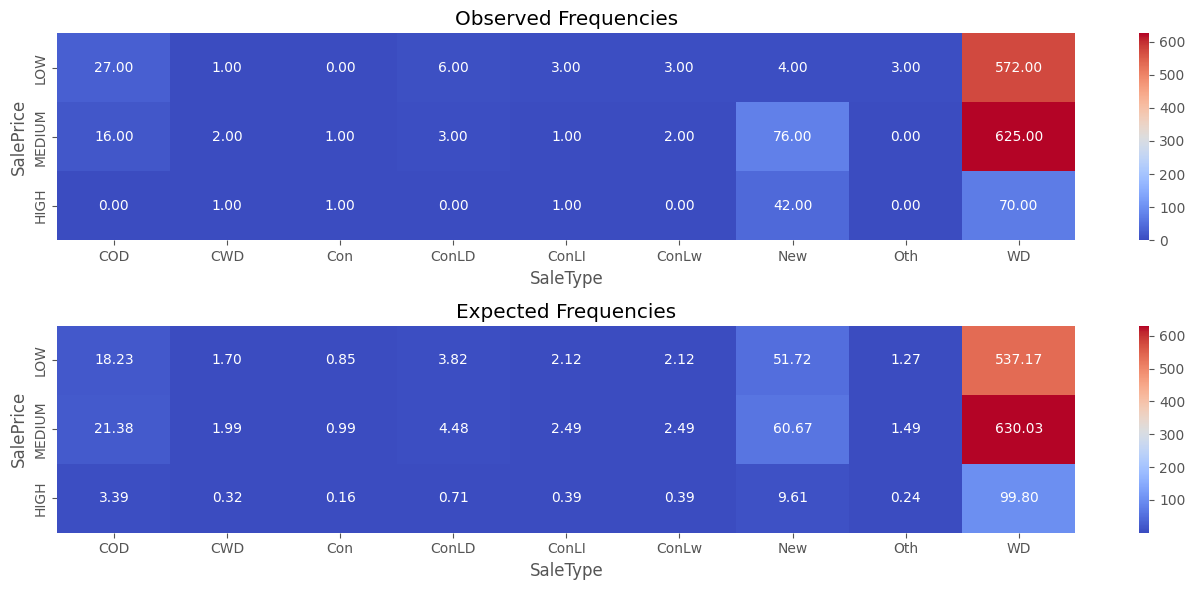

Chi-square Test - Outcome
P-Value: 1.331354726540166e-32 [<0.05]
Cramer's V - Outcome
Coeff: 0.2577111706039038
Understanding SaleType:
	Missing values: 0
	Independence Test: 1.33e-32[<0.05]
	Information Gain: 0.09
	When the SaleType is:
		• Oth, then the sale price is LOW (0.21% of the times)
		• ConLD, then the sale price is 65% likely to be LOW (0.62% of the times)
		• COD+ConLI+ConLw, then the sale price is 60% likely to be LOW (3.63% of the times)
		• New, then the sale price is 60% likely to be MEDIUM (8.36% of the times)
		• CWD+Con, then the sale price is 50% likely to be MEDIUM (0.41% of the times)
		• WD, then the sale price is 45% likely to be LOW (86.78% of the times)




c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


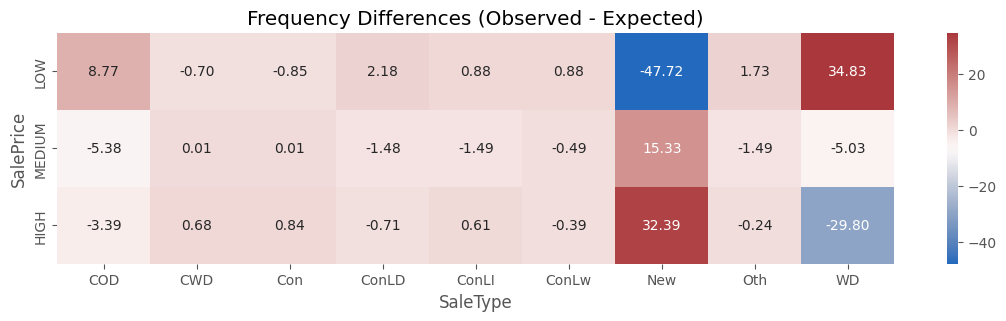

In [515]:
understand(dataf=df_copy, feature_name='SaleType')

##### SaleCondition

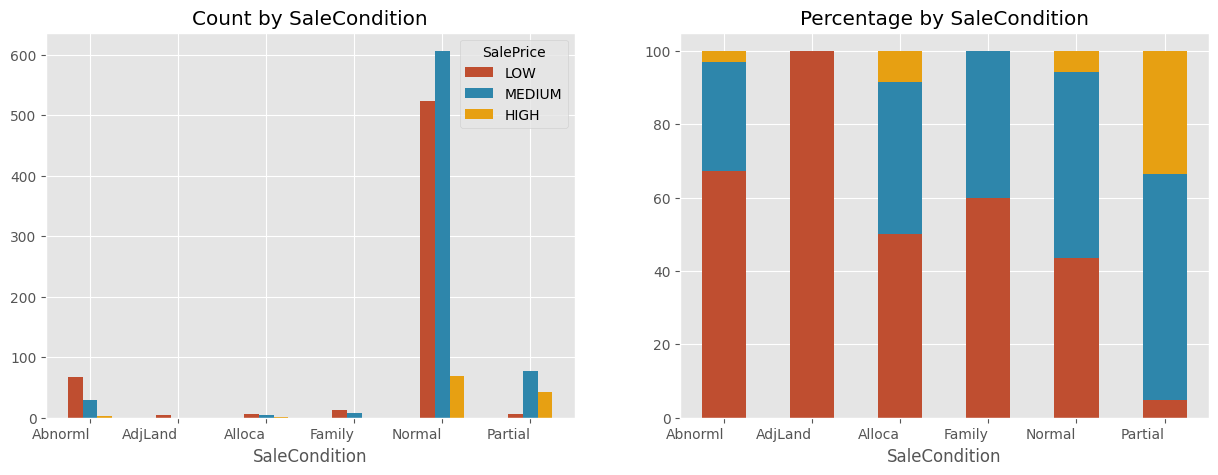

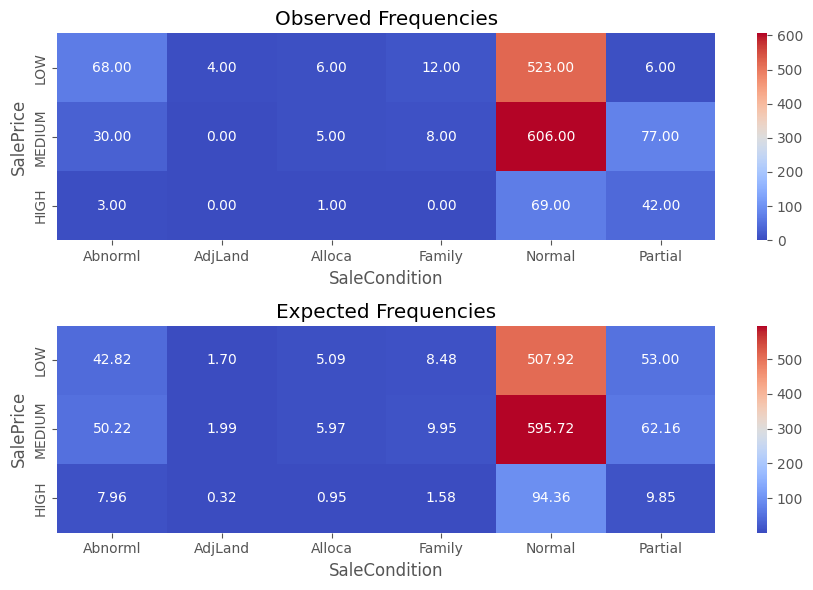

Chi-square Test - Outcome
P-Value: 4.916466420372617e-36 [<0.05]
Cramer's V - Outcome
Coeff: 0.25701128307578847
Understanding SaleCondition:
	Missing values: 0
	Independence Test: 4.92e-36[<0.05]
	Information Gain: 0.09
	When the SaleCondition is:
		• AdjLand, then the sale price is LOW (0.27% of the times)
		• Abnorml, then the sale price is 65% likely to be LOW (6.92% of the times)
		• Family, then the sale price is 60% likely to be LOW (1.37% of the times)
		• Partial, then the sale price is 60% likely to be MEDIUM (8.56% of the times)
		• Alloca, then the sale price is 50% likely to be LOW (0.82% of the times)
		• Normal, then the sale price is 50% likely to be MEDIUM (82.05% of the times)




c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


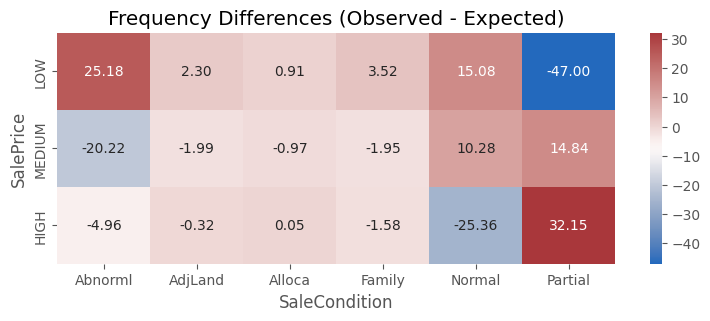

In [516]:
understand(dataf=df_copy, feature_name='SaleCondition')

##### TotalSF

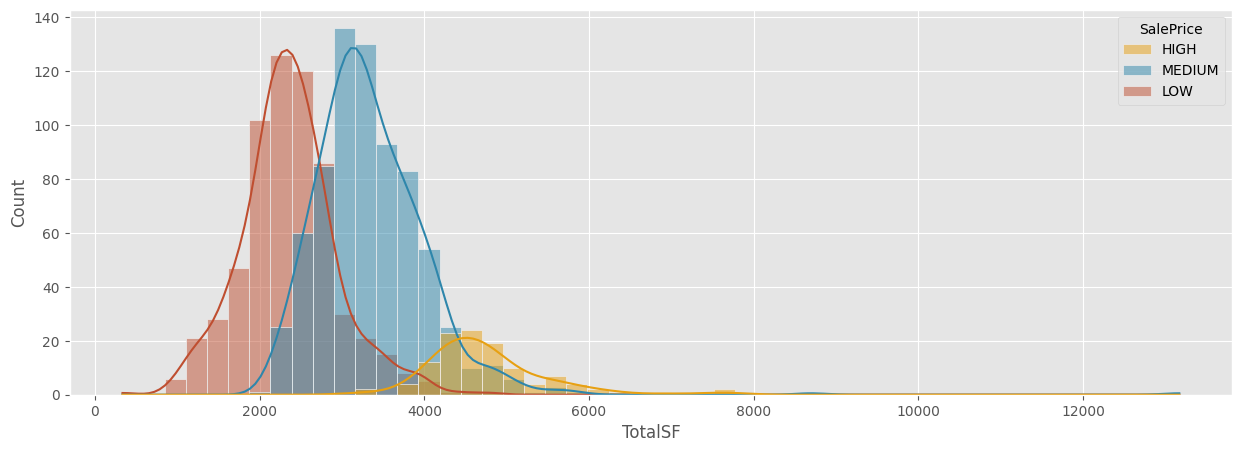

Understanding TotalSF:
	Missing values: 0
	Independence Test: 1.45e-229[<0.05]
	Correlation Index: 0.81
	Correlation p_value: 0.00e+00



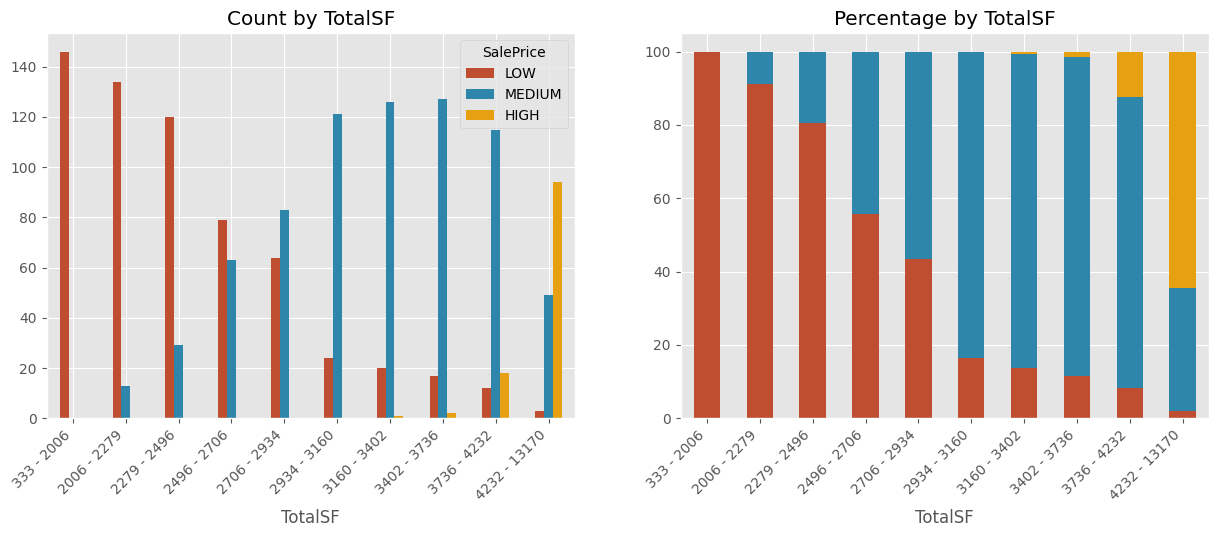

In [517]:
df_copy["TotalSF"] = total_square_feet(df_copy)

understand(dataf=df_copy, feature_name='TotalSF', dtype='int', upper_limit=8000)
frequencies_and_percentages_numeric(df=df_copy, target=TARGET_FEATURE, attribute='TotalSF', bin=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], rotation=45)

##### Good predictive features after data understanding

In [518]:
GOOD_FEATURES = ['MSSubClass', 'LotArea', 'Neighborhood', 'HouseStyle', 'OverallQual',
                'YearBuilt', 'YearRemodAdd', 'Exterior1st', 'MasVnrType', 'MasVnrArea',
                "ExterQual", "Foundation", "BsmtQual", "BsmtFinType1", "TotalBsmtSF",
                "1stFlrSF", "2ndFlrSF", "KitchenQual", "GrLivArea", "FullBath", "TotRmsAbvGrd",
                "Fireplaces", "GarageType", "GarageFinish", "GarageArea", 'TotalSF']
GOOD_FEATURES.append(TARGET_FEATURE)

#### Correlation between good predictive features

##### Understand all correlations between good features

In [519]:
def decide_clique(graph: list[list[int]] , set_nodes : list[int] ):

    for i in set_nodes:
        for j in set_nodes:
            if i != j and graph[i][j] == 0:
                return False
    
    return True

def decide_maximal_clique(graph: list[list] , set_nodes : list[int]):
    
    if not decide_clique(graph=graph, set_nodes=set_nodes):
        return False
    
    for i in range(len(graph)):
        if i not in set_nodes:
            b = True
            for j in set_nodes:
                if graph[i][j] == 0:
                    b = False
            if b :
                return False
    
    return True


def function_maximal_cliques(graph: list[list], n: int) -> list[list[int]]:
    
    if(len(graph) < n or n <= 0):
        return None 

    res = []
    
    maximal_clique = [ i for i in range(n)]

    i = n - 1
    while( maximal_clique[0] < len(graph) - n + 1):

        if i == n - 1 and decide_maximal_clique(graph=graph, set_nodes=maximal_clique):
             res.append(maximal_clique.copy())
        
        maximal_clique[i] += 1
        if maximal_clique[i] < (len(graph) - n + 1 + i):
            # Can increment all counters up to n - 1
            for j in range(i+1,n):
                maximal_clique[j] = maximal_clique[j-1] + 1
            i = n - 1 
        else:
            i -= 1   
        
    return res
        

def function_maximal_cliques_all(graph: list[list]) -> list[list[int]]:
    
    n = 5

    res = []
    while n > 0 :
        resi = function_maximal_cliques(graph=graph, n=n)

        n -= 1
        if(resi != []):
            res.append(resi)

    return res
        


def understand_correlation_all(dataf : pd.DataFrame, selected: list, threshold = 0.65, cliques = False):
    
    correlation_scores = {}


    graph = [ [ 0 for _ in range(len(selected)) ] for _ in range(len(selected))  ]
    corr_graph = graph.copy()

    for i in range(len(selected)):
        for j in range(i+1, len(selected)):
            corr = 0
            bcategoryi = is_categorical_dtype(dataf[selected[i]].dtype) or dataf[selected[i]].dtype == 'object'
            bcategoryj = is_categorical_dtype(dataf[selected[j]].dtype) or dataf[selected[j]].dtype == 'object'
            binti = is_integer_dtype(dataf[selected[i]].dtype)
            bintj = is_integer_dtype(dataf[selected[j]].dtype)

            if (bcategoryi or bcategoryj) and \
                (binti  or bintj  ):
                if bcategoryi:
                    _, _, corr  = stattest_quanti(dataf,feature_name=selected[j], target=selected[i], silent=True, cramer=True )
                else:
                    _, _, corr  = stattest_quanti(dataf,feature_name=selected[i], target=selected[j], silent=True, cramer=True )
            elif bcategoryi and bcategoryj:
                _, _, corr  = stattest_quali(dataf,feature_name=selected[j], target=selected[i], silent=True, cramer=True )
            elif binti and bintj: 
                corr, _  = correlation(dataf, n1 = selected[i], n2 = selected[j], silent=True)
            else:
                if not bcategoryi and  not binti:
                    print("ERROR -> "+selected[i]+ " type -> "+ str(dataf[selected[i]].dtype))
                if not bcategoryj and not bintj:
                    print("ERROR -> "+selected[j]+ " type -> "+ str(dataf[selected[j]].dtype))
            
            corr = abs(corr)
            if  corr >= threshold:
                graph[i][j] = 1
                graph[j][i] = 1
            corr_graph[i][j] = corr
            corr_graph[j][i] = corr
            correlation_scores[selected[i] + "<->" + selected[j]] = corr

    for fi in range(len(corr_graph)):
        corr_graph[fi][fi] = 1.0

    if cliques:
        for n in function_maximal_cliques_all(graph=graph):
            ni = len(n[0])
            print("cliques of size: "+str(ni))
            for clique in n:
                print("{", end=" ")
                for i in clique:
                    print(selected[i], end=" ")
                print("}")
    return corr_graph


#
# corr matrix/graph
#
corr_graph = understand_correlation_all(df_copy, selected=GOOD_FEATURES)

###### Feature correlation selection

Iteration 1
--------------------
Keep TotalSF and remove GrLivArea
Keep MSSubClass and remove HouseStyle
Keep TotalBsmtSF and remove 1stFlrSF
Keep TotalSF and remove GarageArea
Keep TotalSF and remove OverallQual
Keep GarageFinish and remove GarageType
Keep TotalSF and remove TotRmsAbvGrd
Keep YearBuilt and remove YearRemodAdd
Keep BsmtQual and remove BsmtFinType1
Keep ExterQual and remove KitchenQual
Keep MSSubClass and remove 2ndFlrSF
Keep BsmtQual and remove Foundation

Iteration 2
--------------------
Keep TotalSF (cannot remove TotalBsmtSF)

Iteration 3
--------------------

Iteration 4
--------------------

Iteration 5
--------------------

Iteration 6
--------------------

Iteration 7
--------------------

Iteration 8
--------------------

Iteration 9
--------------------

Iteration 10
--------------------



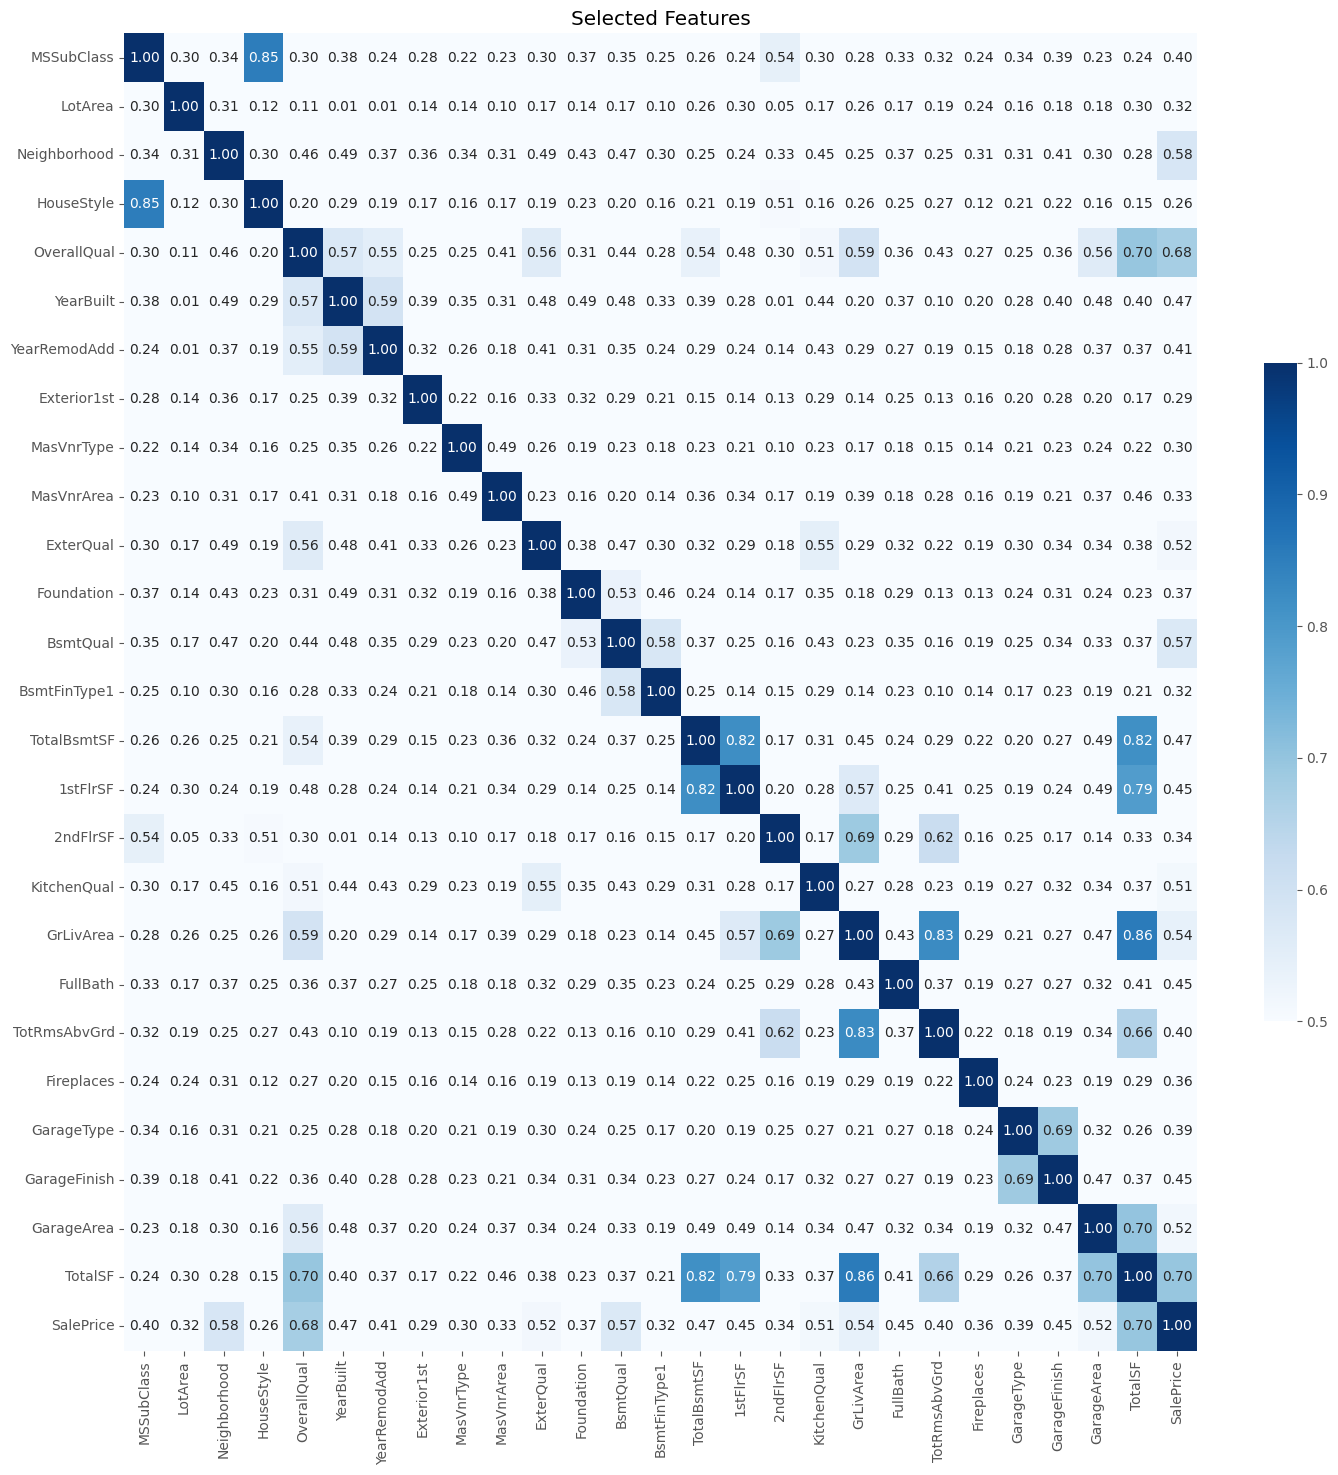

c:\Python311\Lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
C:\Users\Andrea PC\AppData\Local\Temp\ipykernel_1224\2477668851.py:145: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig_net.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=edge_cmap), label='Correlation Coefficient')


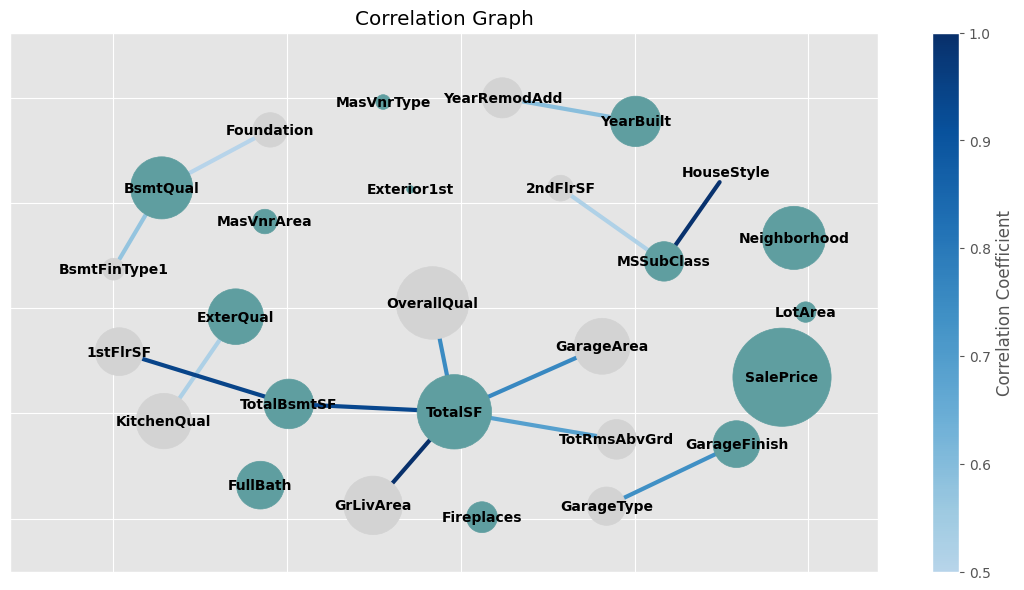

In [520]:
def feature_correlation_selection(corr_graph_full: list, threshold: float=0.5, iters: int=1, show_heatmap: bool=True):  # threashold must be > 0.0
    import copy
    corr_graph = copy.deepcopy(corr_graph_full)

    nnodes = len(corr_graph)
    target_fidx = GOOD_FEATURES.index(TARGET_FEATURE)
    
    import networkx as nx
    G = nx.DiGraph()
    G.add_nodes_from(range(nnodes))

    keep_history_nodes = []
    
    for iter_idx in range(iters):
        print("Iteration %d" % (iter_idx + 1))
        print('-' * 20)

        ignored_nodes = []
        while True:
            max_fi = -1
            max_fj = -1
            max_corr = 0
            for fi in range(nnodes):
                for fj in range(fi+1, nnodes):
                    if fi == target_fidx or fj == target_fidx or (fi in ignored_nodes and fj in ignored_nodes):
                        continue
                    if corr_graph[fi][fj] > max_corr:
                        max_fi = fi
                        max_fj = fj
                        max_corr = corr_graph[fi][fj]

            if max_corr < threshold:
                break
            
            #print(max_corr)
            to_keep = max_fi
            to_remove = max_fj
            if corr_graph[max_fj][target_fidx] > corr_graph[max_fi][target_fidx]:
                to_keep = max_fj
                to_remove = max_fi
            
            #print("CORR:", corr_graph[to_keep][target_fidx], corr_graph[to_remove][target_fidx])

            ignored_nodes.append(to_keep)
            keep_history_nodes.append(to_keep)

            to_keep_name = GOOD_FEATURES[to_keep]
            to_remove_name = GOOD_FEATURES[to_remove]

            if to_remove in ignored_nodes:
                G.add_edge(to_keep, to_remove, weight=max_corr)
                G.add_edge(to_remove, to_keep)
                print("Keep %s (cannot remove %s)" % (to_keep_name, to_remove_name))
            else:
                for k in range(nnodes):
                    corr_graph[to_remove][k] = 0.0
                    corr_graph[k][to_remove] = 0.0
                ignored_nodes.append(to_remove)
                G.add_edge(to_keep, to_remove, weight=max_corr)

                if to_remove in keep_history_nodes: print("Keep %s (cannot remove %s)" % (to_keep_name, to_remove_name))
                else: print("Keep %s and remove %s" % (to_keep_name, to_remove_name))
        print()

    corr_graph = corr_graph_full

    def remap_fullrange(value: float, threshold: float, new_lower=0.0, new_upper=1.0):
        return new_lower + (value - threshold) * (new_upper - new_lower) / (new_upper - threshold)

    #
    # plot corr heatmap
    #
    if show_heatmap:
        fig_size = min(20, 0.55 * nnodes)
        fig, ax = plt.subplots(figsize=(fig_size, fig_size))  
        corr_graph_df = pd.DataFrame(corr_graph, index=GOOD_FEATURES, columns=GOOD_FEATURES)
        sb.heatmap(corr_graph_df, annot=True, cmap='Blues', fmt='.2f', vmin=threshold, cbar_kws={"shrink": 0.5}, ax=ax)
        ax.set_title('Selected Features')    
        ax.set_title('Selected Features')
        fig.tight_layout()
        plt.show()

    #
    # draw corr graph (G)
    #

    fig_net = plt.figure(figsize=(14, 7))
    ax_net = plt.subplot(111)
    ax_net.margins(0.1)  
    ax_net.set_title('Correlation Graph')
    #ax_net.set_facecolor("white")


    #
    # graph layout
    #
    gdf = pd.DataFrame(index=G.nodes(), columns=G.nodes())
    for row, data in nx.shortest_path_length(G):
        for col, dist in data.items():
            gdf.loc[row,col] = dist

    gdf = gdf.fillna(gdf.max().max())
    pos = nx.kamada_kawai_layout(G, dist=gdf.to_dict())

    #
    # draw nodes
    #
    node_sizes = []
    node_colors = []
    node_labels_dict = {}
    for fi in range(nnodes):
        node_sizes.append(5000 * remap_fullrange(corr_graph[fi][target_fidx], threshold, new_lower=0.3))
        node_colors.append('cadetblue' if G.out_degree(fi) > 0 or G.in_degree(fi) == 0 else 'lightgray')
        node_labels_dict[fi] = GOOD_FEATURES[fi]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, ax=ax_net)

    #
    # draw edge weight labels
    #
    #edge_labels = nx.get_edge_attributes(G, "weight")
    #for k in edge_labels.keys():
    #    edge_labels[k] = float(f'{edge_labels[k]:.2f}')
    #nx.draw_networkx_edge_labels(G, pos, edge_labels, verticalalignment='bottom')

    #
    # draw edges
    #
    edges_list, edge_weights = zip(*nx.get_edge_attributes(G,'weight').items())
    edge_weights = list(edge_weights)
    for i in range(len(edge_weights)):
        edge_weights[i] = remap_fullrange(edge_weights[i], threshold)
    edge_weights = tuple(edge_weights)

    import matplotlib.colors as colors
    def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
        new_cmap = colors.LinearSegmentedColormap.from_list(
            'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
            cmap(np.linspace(minval, maxval, n)))
        return new_cmap

    import matplotlib as mpl
    edge_cmap = truncate_colormap(plt.cm.Blues, 0.3, 1.0)

    norm = mpl.colors.Normalize(vmin=0.5, vmax=1.0)
    fig_net.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=edge_cmap), label='Correlation Coefficient')
    nx.draw_networkx_edges(G, pos, edgelist=edges_list, edge_color=edge_weights, width=3, edge_cmap=edge_cmap, arrowsize=20, arrowstyle='-', ax=ax_net)

    #
    # draw node labels
    #
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif", font_weight='bold', labels=node_labels_dict, ax=ax_net)


feature_correlation_selection(corr_graph, iters=10, show_heatmap=True)

### Data Preparation

##### Checking for inconsistencies among good features

In [521]:
def inconsistencies(df):
    print("Incons. for Garage:")
    print(f'If no garage, then no garageFinish {len(df[(df["GarageType"] == "NA") & (df["GarageFinish"] != "NA")])}')
    print(f'If no garage, then no garageArea {len(df[(df["GarageType"] == "NA") & (df["GarageArea"] != 0)])}')
    print()
    print("Incons. for Basment:")
    print(f'BsmtFinType1 <=> bsmtQual {len(df[((df["BsmtQual"] == "NA") & (df["BsmtFinType1"] != "NA")) | ((df["BsmtFinType1"] == "NA") & (df["BsmtQual"] != "NA"))])}')
    print(f'TotalBsmtSf <=> bsmtQual {len(df[((df["BsmtQual"] == "NA") & (df["TotalBsmtSF"] != 0)) | ((df["TotalBsmtSF"] == 0) & (df["BsmtQual"] != "NA"))])}')
    print(f'BsmtFinType1 <=> TotalBsmtSF {len(df[((df["BsmtFinType1"] == "NA") & (df["TotalBsmtSF"] != 0)) | ((df["TotalBsmtSF"] == 0) & (df["BsmtFinType1"] != "NA"))])}')
    print()
    print("Incons. for floors:")
    print(f'Sum of 1st and 2nd floor is consistent: {len(df[df["GrLivArea"] < df["1stFlrSF"]+df["2ndFlrSF"]])}')
    print(f'1st floor <= 0: {len(df[df["1stFlrSF"] <= 0])}')
    print()
    print("Incons. for Housestyle:")
    house_style_df = df[(df["HouseStyle"] == "1Story") & (df["2ndFlrSF"] > 0 )]
    print(f'{house_style_df.loc[:, ["Id","HouseStyle","2ndFlrSF", "1stFlrSF","salePriceNum", "SalePrice","GrLivArea"]]}')
    print()
    print("Incons. for Rooms:")
    print(f'At least a room: {len(df[(df["TotRmsAbvGrd"] == 0)])}')
    print()
    print("Incons. for MasVnrType:")
    df_mas = df.loc[:,["Id", "MasVnrType", "MasVnrArea", "SalePrice"]]
    df_mas["MasVnrArea"] = df_mas["MasVnrArea"].replace("NA", 0)
    df_mas["MasVnrArea"] = df_mas["MasVnrArea"].astype("int")
    #3 diversi vanno droppati e i due con 1 in MasVnrType vanno settati a 0 
    print(f'No MasVnr then Area must be 0: {(df_mas[(df_mas["MasVnrType"] == "None") & (df_mas["MasVnrArea"] != 0)])}')
    #to be changed to None!
    print(f'NA MasVnr: {(df_mas[(df_mas["MasVnrType"] == "NA") & (df_mas["MasVnrArea"] != 0)])}')
    print()
    for i in df.columns:
        if is_integer_dtype(df[i].dtype):
            if(len(df[df[i]<0]) > 0):
                print(f"Values < 0 for {i}")


inconsistencies(df)

Incons. for Garage:
If no garage, then no garageFinish 0
If no garage, then no garageArea 0

Incons. for Basment:
BsmtFinType1 <=> bsmtQual 0
TotalBsmtSf <=> bsmtQual 0
BsmtFinType1 <=> TotalBsmtSF 0

Incons. for floors:
Sum of 1st and 2nd floor is consistent: 0
1st floor <= 0: 0

Incons. for Housestyle:
        Id HouseStyle  2ndFlrSF  1stFlrSF  salePriceNum SalePrice  GrLivArea
164    165     1Story       467      1149        152000    MEDIUM       1616
1270  1271     1Story       192      1332        260000    MEDIUM       1524

Incons. for Rooms:
At least a room: 0

Incons. for MasVnrType:
No MasVnr then Area must be 0:         Id MasVnrType  MasVnrArea SalePrice
624    625       None         288    MEDIUM
773    774       None           1       LOW
1230  1231       None           1    MEDIUM
1300  1301       None         344    MEDIUM
1334  1335       None         312       LOW
NA MasVnr: Empty DataFrame
Columns: [Id, MasVnrType, MasVnrArea, SalePrice]
Index: []



##### Data Cleaning and Reduction of good features

In [522]:
GOOD_FEATURES_TYPE_MAP = \
    {"MSSubClass": ["ordinal integer"],
    "Neighborhood": ["category"],
    "HouseStyle": ["category"],
    "OverallQual": ["int64"],
    "YearBuilt": ["int64"],
    "YearRemodAdd": ["int64"],
    "Exterior1st":["category"],
    "MasVnrType":["category"],
    "MasVnrArea":["int64"],
    "ExterQual":["ordinal category", ["Po", "Fa","TA","Gd","Ex"]],
    "Foundation":["category"],
    "BsmtQual":["ordinal category", ["NA","Po","Fa","TA","Gd","Ex"]],
    "BsmtFinType1":["ordinal category", ["NA","Unf","LwQ","Rec","BLQ","ALQ","GLQ"]],
    "TotalBsmtSF":["int64"],
    "1stFlrSF":["int64"],
    "2ndFlrSF":["int64"],
    "GrLivArea":["int64"],
    "FullBath":["int64"],
    "KitchenQual":["ordinal category", ["Po","Fa","TA","Gd","Ex"]],
    "TotRmsAbvGrd":["int64"],
    "Fireplaces":["int64"],
    "GarageType":["category"],
    "GarageFinish":["ordinal category",["NA","Unf","RFn","Fin"]],
    "GarageArea":["int64"],
    "LotArea": ['int64'],
    "SalePrice":["category"]}

INTEGER_ATTRIBUTES = []

for key in GOOD_FEATURES_TYPE_MAP.keys():
    if GOOD_FEATURES_TYPE_MAP[key][0] == 'int64':
        INTEGER_ATTRIBUTES.append(key)
INTEGER_ATTRIBUTES += ['LotFrontage', 'BsmtFinSF1', "BsmtFinSF2", 'BsmtUnfSF', "LowQualFinSF",
                       "BsmtFullBath", "BsmtHalfBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr",
                       "GarageYrBlt", "GarageCars", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch",
                       "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal", "MoSold",  "YrSold" ]


def data_cleaning_reduction(df: pd.DataFrame, selected_att : dict):
    df = df.copy(deep=True)
    #feature selection (era in data reduction, per facilita lo teniamo qua)
    df = df.loc[:, selected_att.keys()]

    #missing values there are no null values only NA
    #df["attributo"].fillna("valore", inplace = True)

    na_values = {"MasVnrArea": ["NA", 0], "MasVnrType": ["NA", "None"], "GarageYrBlt":["NA", 0], "2ndFlrSF":["NA", 0], "LotFrontage":["NA", 0]}
    for attribute in na_values.keys():
        if attribute in df.columns:
            df[attribute] = df[attribute].replace(na_values[attribute][0], na_values[attribute][1]) 
    
    #casting
    for i in selected_att.keys():
        if i not in df.columns:
            pass
        if selected_att[i][0] == "ordinal category":
            df[i] = df[i].astype("category")
            df[i] = df[i].cat.set_categories(selected_att[i][1], ordered=True)
        elif selected_att[i][0] == "ordinal integer":
            df[i]=df[i].astype(CategoricalDtype(ordered=True))
        else:
            df[i] = df[i].astype(selected_att[i][0])
    
    #noisy data
    if "HouseStyle" in df.columns and "2ndFlrSF" in df.columns:
        df.loc[(df["HouseStyle"] == "1Story") & (df["2ndFlrSF"] > 0 ), "HouseStyle"] = "2Story"
    if "MasVnrType" in df.columns and "MasVnrArea" in df.columns:
        df.loc[(df["MasVnrType"] == "None") & (df["MasVnrArea"] <= 5 ), "MasVnrArea"] = 0
        df_mastype = df[(df["MasVnrType"] == "None") & (df["MasVnrArea"] > 5 )]
        for index, row in df_mastype.iterrows():
            df.at[index, "MasVnrType"] = get_common_category(df, category=row["SalePrice"], attribute="MasVnrType", exclude = ["None", "NA"])
    return df
    

df_cleaned = data_cleaning_reduction(df, selected_att=GOOD_FEATURES_TYPE_MAP)

#### Data Transformation of good features

In [523]:
GOOD_FEATURES_AGGREGATED_VALUES = {
        # "HouseStyle": {
        #                 "1Story" : "other",
        #                 "1.5Unf" : "other",
        #                 "2.5Fin" : "other",
        #                 "2.5Unf" : "other",
        #                 "Sfoyer" : "other",
        #                 "SLvl" : "other"
        #                 },
        "OverallQual": {
                        1 : 4,
                        2 : 4,
                        3 : 4,
                        10 : 9,
                        },
        # "Exterior1st": {
        #                 "AsbShng" : "other",
        #                 "AsphShn" : "other",
        #                 "BrkComm" : "other",
        #                 "BrkFace" : "other",
        #                 "CBlock" : "other",
        #                 "CemntBd" : "other",
        #                 "HdBoard" : "other",
        #                 "ImStucc" : "other",                                    
        #                 "AsbShng" : "other",
        #                 "MetalSd" : "other",
        #                 "Other" : "other",
        #                 "Plywood" : "other",
        #                 "PreCast" : "other",
        #                 "Stone" : "other",
        #                 "Stucco" : "other",
        #                 "Stone" : "other",
        #                 "Wd Sdng" : "other",
        #                 "WdShing" : "other"

        #                 },
        # "MasVnrType": {
        #                 "BrkCmn" : "other",
        #                 "BrkFace" : "other"
        #                 },
        # "ExterQual": {
        #                 "Fa" : "TA",
        #                 "Po" : "TA",
        #             },
        "Foundation": {
                        "wood" : "other",
                        "slab" : "other",
                        "stone" : "other",
                        "BrkTil" : "CBlock"
                    },
        # "BsmtQual": {
        #                 "NA" : "other",
        #                 "Fa" : "other",
        #                 "TA" : "other",
        #                 "Po" : "other"
        #             },
        # "BsmtFinType1": {
        #                 "ALQ" : "other",
        #                 "BLQ" : "other",
        #                 "Rec" : "other",
        #                 "LwQ" : "other",
        #                 "NA" : "other",
        #             },
        # "KitchenQual": {
        #                 "Fa" : "TA",
        #                 "Po" : "TA",
        #             },
        # "GarageType": {
        #                 "2Types" : "other",
        #                 "CarPort" : "other",
        #                 "Basment" : "other",
        #             },
        }

def data_transformation(global_df : pd.DataFrame, df : pd.DataFrame, aggregate_values, scale = True, aggr=True, fcr=True):
    df = df.copy(deep=True)
    #Aggregation
    if aggr:
        for attribute in aggregate_values.keys():
            for val in aggregate_values[attribute].keys():
                df[attribute] = df[attribute].replace(val, aggregate_values[attribute][val])

    #Feature creation
    if fcr:
        df["TotalSF"] = total_square_feet(global_df)

    #Normalization
    if scale:
        type = ["float64", "int" ,"int64", "float"]
        cols = df.select_dtypes(include = type).columns
        scaler = StandardScaler()
        df[cols] = scaler.fit_transform(df[cols])
    return df

df_transformed = data_transformation(df, df_cleaned, GOOD_FEATURES_AGGREGATED_VALUES)

#### Feature selection with wrapper approach

In [524]:
def bootstrapping_evaluation(df : pd.DataFrame, model, n_iterations, silent: bool=False, metric = 'accuracy'):
    n_size = df.shape[0] // 2
    values = df.values
    #Lets run Bootstrap
    stats = list()
    for i in range(n_iterations):

        #prepare train & test sets
        train = resample(df.index, n_samples = n_size) #Sampling with replacement..whichever is not used in training data will be used in test data
        train_x = []
        train_y = []
        attributes = df.columns.values.tolist()
        attributes.remove('SalePrice')
        for ind in train:
            row = df.iloc[ind]
            train_y.append(row['SalePrice'])
            row = row[attributes]
            train_x.append(row.values)
        
        test = np.array([x for x in df.index if x not in train]) #picking rest of the data not considered in training sample
        test_x = []
        test_y = []
        for ind in test:
            row = df.iloc[ind]
            test_y.append(row['SalePrice'])
            row = row[attributes]
            test_x.append(row.values)
        #fit model
        model.fit(train_x, train_y) #model.fit(X_train,y_train) i.e model.fit(train set, train label as it is a classifier)
        
        #evaluate model
        predictions = model.predict(test_x) #model.predict(X_test)
        if(metric == 'accuracy'):
            score = accuracy_score(test_y, predictions) #accuracy_score(y_test, y_pred)
        elif metric == 'balanced accuracy':
            score = balanced_accuracy_score(test_y, predictions)
            
        #caution, overall accuracy score can mislead when classes are imbalanced
        
        if not silent: print(score)
        stats.append(score)
    
    return stats

class DatasetScoreSampler:

    def compute_score_sample(self, dataf: pd.DataFrame) -> list:
        pass
    def compute_score_mean(self, dataf: pd.DataFrame) -> float:
        pass

class KFoldDatasetScoreSampler(DatasetScoreSampler):

    def __init__(self, k: int=5, metrics = ['balanced_accuracy'], niterations: int=20, model = ('DT', DecisionTreeClassifier())) -> None:
        self.k = k
        self.metrics = metrics
        self.niterations = niterations
        self.model_name = model[0]
        self.model = model[1]
    
    def compute_score_sample(self, dataf: pd.DataFrame) -> list:
        k_fold = KFold(shuffle=True,n_splits = self.k)
        score_sample = []
        
        for _ in range(self.niterations):
            score=0
            for i, (train_index, test_index) in enumerate(k_fold.split(dataf)):
                #print(f"Fold {i}:")
                #print(f"  Train: index={train_index}")
                #print(f"  Test:  index={test_index}")

                train_dataf = dataf.iloc[train_index]
                test_dataf = dataf.iloc[test_index]
                #print("Size before resample: " + str(len(train_dataf)))
                #print(train_dataf.columns)
                #print(train_dataf.head())
                train_dataf_resampled = train_dataf # resample(train_dataf) TODO: fix it!
                #print("Size after resample: " + str(len(train_dataf_resampled)))
                # print(train_dataf.columns)
                X_train = train_dataf_resampled.drop(columns=[TARGET_FEATURE])
                X_test  = test_dataf.drop(columns=[TARGET_FEATURE])
                y_train = train_dataf_resampled[TARGET_FEATURE]
                y_test  = test_dataf[TARGET_FEATURE]
                

                self.model.fit(X_train, y_train)
                y_pred = self.model.predict(X_test)
                
                metric_score = 0
                for metric in self.metrics:
                    if metric == 'balanced_accuracy':
                        metric_score += balanced_accuracy_score(y_true=y_test, y_pred=y_pred)  # balance accuracy as measure
                    if metric == 'accuracy':
                        metric_score += accuracy_score(y_true=y_test, y_pred=y_pred) # balance accuracy as measure
                    if metric == 'f1_score':
                        metric_score += f1_score(y_true=y_test, y_pred=y_pred) # balance accuracy as measure
                    if metric == 'precision':
                        metric_score += precision_score(y_true=y_test, y_pred=y_pred) # balance accuracy as measure
                    if metric == 'recall':
                        metric_score += recall_score(y_true=y_test, y_pred=y_pred) # balance accuracy as measure

                score += metric_score / len(self.metrics)
            score_sample.append(score / self.k)
            
            #score_sample.append(mean(iter_score_sample))
        
        return score_sample

    def compute_score_mean(self, dataf: pd.DataFrame) -> float:
        return mean(self.compute_score_sample(dataf))

    def compute_score_stats(self, dataf: pd.DataFrame) -> float:
        sample = self.compute_score_sample(dataf)
        return mean(sample), min(sample), max(sample)
    
    @property
    def model(self):
        return self._model
    
    @model.setter
    def model(self, model):
        self._model = model


class FeatureSelectionValidator:

    def __init__(self,global_df: pd.DataFrame, staged_dataf: pd.DataFrame,
                 datasetScoreSampler: DatasetScoreSampler, silent: bool=False) -> None:
        self.no_dummies_no_scale_df = staged_dataf
        self.set_dataf(staged_dataf)
        self.silent = silent
        self.global_df = global_df
        self.datasetScoreSampler = datasetScoreSampler
        self.model_name = self.datasetScoreSampler.model_name
        self.staged_score_sample = self.datasetScoreSampler.compute_score_sample(self.staged_dataf)
        self.print(f"Model name {self.model_name}\nStaged dataframe score (avg): %f" % mean(self.staged_score_sample), "\n")

    
    def set_dataf(self, staged_dataf: pd.DataFrame, resample = False):
        cat_attributes = list(staged_dataf.select_dtypes(include = ['category', 'object']).columns)
        cat_attributes.remove(TARGET_FEATURE)
        self.staged_dataf = pd.get_dummies(staged_dataf,columns=cat_attributes)
        type = ["float64", "int" ,"int64", "float"]
        cols_to_scale = staged_dataf.select_dtypes(include = type).columns
        scaler = StandardScaler()
        self.staged_dataf[cols_to_scale] = scaler.fit_transform(self.staged_dataf[cols_to_scale])
        self.staged_dataf = pd.get_dummies(staged_dataf,columns=cat_attributes)
        

    def validate_forward(self, candidate_features: list[str]) -> list:
        
        include_features = []
        candidate_features = self.compute_corr_with_target(candidate_features, order='desc') 

        working_staged_dataf = self.staged_dataf.copy(deep=True)
        working_staged_score_sample = self.staged_score_sample

        for candidate_feature, corr in candidate_features:
            if candidate_feature == TARGET_FEATURE or candidate_feature == TARGET_FEATURE_CONTI: continue

            # candidate data frame (construction + score sample)
            candidate_dataf = working_staged_dataf.copy(deep=True)
            candidate_dataf[candidate_feature] = self.global_df[candidate_feature]
            candidate_feature_dtype = str(candidate_dataf[candidate_feature].dtype)
            
            # TODO: add assert for candidate_feature
            if candidate_feature not in  INTEGER_ATTRIBUTES :
                candidate_dataf = pd.get_dummies(candidate_dataf, columns=[candidate_feature])
            
            elif 'int' in candidate_feature_dtype or 'float' in candidate_feature_dtype or candidate_feature in  INTEGER_ATTRIBUTES :
                if candidate_feature_dtype == 'object':
                    candidate_dataf[candidate_feature] = candidate_dataf[candidate_feature].replace(to_replace='NA', value=0)
                    candidate_dataf[candidate_feature] = candidate_dataf[candidate_feature].astype("int")
                # normalize in case of numeric dtype
                scaler = StandardScaler()
                candidate_dataf[[candidate_feature]] = scaler.fit_transform(candidate_dataf[[candidate_feature]])
            
            else: raise RuntimeError('Invalid dtype for candidate feature.')
            
            candidate_score_sample = self.datasetScoreSampler.compute_score_sample(candidate_dataf)
            
            # perform t-test for the means
            _, pvalue = stats.ttest_ind(candidate_score_sample, working_staged_score_sample, equal_var=False, alternative='greater')
            outcome: bool = pvalue < 0.05

            if outcome:  # evidence to an increase in performance
                include_features.append(candidate_feature)
                working_staged_dataf = candidate_dataf
                working_staged_score_sample = candidate_score_sample

            self.print("%s selection - Validation outcome:" % candidate_feature)
            self.print("\t- %s candidate" % ('include' if outcome else 'discard'))
            self.print("\t- pvalue: %f" % pvalue, "\n")
        
        final_score_mean = self.datasetScoreSampler.compute_score_mean(working_staged_dataf)
        self.print(f"Model name {self.model_name}\nFinal dataframe score (avg): %f" % final_score_mean, "\n")
        # self.print("Final dataset cols:", str(working_staged_dataf.columns.tolist()))
        
        return include_features

    def validate_forward_pvalue(self, candidate_features: list[str]) -> list:
        
        include_features = []
        candidate_features = candidate_features.copy()

        working_staged_dataf = self.staged_dataf.copy(deep=True)
        working_staged_score_sample = self.staged_score_sample

        while len(candidate_features) > 0:
            min_pvalue = 0.0
            min_candidate_feature = None
            min_candidate_score_sample = []

            for candidate_feature in candidate_features:
                if candidate_feature == TARGET_FEATURE or candidate_feature == TARGET_FEATURE_CONTI: continue
                
                # candidate data frame (construction + score sample)
                candidate_dataf = working_staged_dataf.copy(deep=True)
                candidate_dataf[candidate_feature] = self.global_df[candidate_feature]
                candidate_feature_dtype = str(candidate_dataf[candidate_feature].dtype)
                
                # TODO: add assert for candidate_feature
                if candidate_feature not in  INTEGER_ATTRIBUTES :
                    candidate_dataf = pd.get_dummies(candidate_dataf, columns=[candidate_feature])
                
                elif 'int' in candidate_feature_dtype or 'float' in candidate_feature_dtype or candidate_feature in  INTEGER_ATTRIBUTES :
                    if candidate_feature_dtype == 'object':
                        candidate_dataf[candidate_feature] = candidate_dataf[candidate_feature].replace(to_replace='NA', value=0)
                        candidate_dataf[candidate_feature] = candidate_dataf[candidate_feature].astype("int")
                    # normalize in case of numeric dtype
                    scaler = StandardScaler()
                    candidate_dataf[[candidate_feature]] = scaler.fit_transform(candidate_dataf[[candidate_feature]])
                
                else: raise RuntimeError('Invalid dtype for candidate feature.')
                
                candidate_score_sample = self.datasetScoreSampler.compute_score_sample(candidate_dataf)
                
                # perform t-test for the means
                #_, pvalue = stats.ttest_ind(candidate_score_sample, working_staged_score_sample, equal_var=False, alternative='greater')
                #if pvalue < min_pvalue:
                pvalue = mean(candidate_score_sample) - mean(working_staged_score_sample)
                if pvalue > min_pvalue:
                    min_pvalue = pvalue
                    min_candidate_feature = candidate_feature
                    min_candidate_score_sample = candidate_score_sample.copy()

            if min_pvalue == 0.0:
                break
            candidate_feature = min_candidate_feature
            outcome: bool = min_pvalue > 0  #min_pvalue < 0.05

            if outcome:  # evidence to an increase in performance
                include_features.append(candidate_feature)

                candidate_dataf = working_staged_dataf.copy(deep=True)
                candidate_dataf[min_candidate_feature] = self.global_df[min_candidate_feature]
                if candidate_feature not in  INTEGER_ATTRIBUTES :
                    candidate_dataf = pd.get_dummies(candidate_dataf, columns=[candidate_feature])
                
                elif 'int' in candidate_feature_dtype or 'float' in candidate_feature_dtype or candidate_feature in  INTEGER_ATTRIBUTES :
                    if candidate_feature_dtype == 'object':
                        candidate_dataf[candidate_feature] = candidate_dataf[candidate_feature].replace(to_replace='NA', value=0)
                        candidate_dataf[candidate_feature] = candidate_dataf[candidate_feature].astype("int")
                    # normalize in case of numeric dtype
                    scaler = StandardScaler()
                    candidate_dataf[[candidate_feature]] = scaler.fit_transform(candidate_dataf[[candidate_feature]])
                
                else: raise RuntimeError('Invalid dtype for candidate feature.')
                
                working_staged_dataf = candidate_dataf
                working_staged_score_sample = min_candidate_score_sample

            self.print("%s selection - Validation outcome:" % candidate_feature)
            self.print("\t- %s candidate" % ('include' if outcome else 'discard'))
            self.print("\t- pvalue: %f" % min_pvalue, "\n")
            self.print("\t- current score: %f" % mean(working_staged_score_sample))

            candidate_features.remove(candidate_feature)
        
        final_score_mean = self.datasetScoreSampler.compute_score_mean(working_staged_dataf)
        self.print(f"Model name {self.model_name}\nFinal dataframe score (avg): %f" % final_score_mean, "\n")
        # self.print("Final dataset cols:", str(working_staged_dataf.columns.tolist()))
        
        return include_features


    def validate_backward(self, candidate_features: list[str], p_value_parm = 0.12) -> (list, list):

        keep_features = []
        drop_features = []
        candidate_features = self.compute_corr_with_target(candidate_features, order='asc') 

        working_staged_dataf = self.staged_dataf.copy(deep=True)
        working_staged_score_sample = self.staged_score_sample
        working_pvalue = 1.0

        for candidate_feature, corr in candidate_features:
            if candidate_feature == TARGET_FEATURE or candidate_feature == TARGET_FEATURE_CONTI: continue

            # candidate data frame (construction + score sample)
            candidate_dataf = working_staged_dataf
            cols_to_drop = []
            for col in candidate_dataf.columns:
                if col.startswith(candidate_feature): cols_to_drop.append(col)
            candidate_dataf = candidate_dataf.drop(columns=cols_to_drop)

            candidate_score_sample = self.datasetScoreSampler.compute_score_sample(candidate_dataf)
            
            # perform t-test for the means
            print("CAND:", candidate_score_sample)
            print("WORK:", working_staged_score_sample)
            _, pvalue = stats.ttest_ind(candidate_score_sample, working_staged_score_sample, equal_var=False, alternative='less')
            outcome: bool = pvalue < p_value_parm #and pvalue < working_pvalue
            print("PVALUE:", pvalue, "\n")

            # _, pvalue = stats.ttest_ind(candidate_score_sample, self.staged_score_sample, equal_var=False, alternative='greater')
            # outcome: bool = pvalue > 0.05
            
            if not outcome:  # no evidence to a decrease in performance
                drop_features.append(candidate_feature)
                working_staged_dataf = candidate_dataf
                working_staged_score_sample = candidate_score_sample
                working_pvalue = pvalue
            else:
                keep_features.append(candidate_feature)
            
            self.print("%s selection - Validation outcome:" % candidate_feature)
            self.print("\t- %s candidate" % ('keep' if outcome else 'drop'))
            self.print("\t- pvalue: %f" % pvalue, "\n")


        final_score_mean = self.datasetScoreSampler.compute_score_mean(working_staged_dataf)
        self.print("Model name {self.model_name}\nFinal dataframe score (avg): %f" % final_score_mean, "\n")
        
        return (drop_features, keep_features)


    def print(self, *msg: str):
        if not self.silent: print(' '.join(msg))
    

    def compute_corr_with_target(self, features: list[str], order: str='asc') -> list[float]:
        if TARGET_FEATURE not in features:
            features.append(TARGET_FEATURE)
        corr_graph = understand_correlation_all(dataf=self.global_df, selected=features, threshold=0.0)
        corr_with_target = corr_graph[features.index(TARGET_FEATURE)]
        corr_with_target = corr_with_target[:-1]
        features.remove(TARGET_FEATURE)

        features_corrmap = {}
        for f in features:
            features_corrmap[f] = corr_with_target[features.index(f)]
        reverse_order = order != 'asc'
        return sorted(features_corrmap.items(), key=lambda x:x[1], reverse=reverse_order)



def feature_selection_wrapper(global_df :  pd.DataFrame, df : pd.DataFrame, evaluation_model,  
                            selected_att : list, discarded_features : list, parameter_eval=5 , evaluation_approach = 'kFold',
                            metrics = ['balanced_accuracy'], niterations=5, silent: bool=True)->list:

    # validate selected/discarded features
    #
    # 
    if evaluation_approach == 'kFold':    
        scoreSampler = KFoldDatasetScoreSampler(k=parameter_eval, metrics=metrics, model=evaluation_model, niterations=niterations)
    
    fsv = FeatureSelectionValidator(global_df , df, scoreSampler, silent=silent)

    (to_remove, to_keep) = fsv.validate_backward(selected_att)
    print("Features to keep: " + str(to_keep))
    print("Features to remove: " + str(to_remove))

    df_transformed_noscale_wvb = df[to_keep + [TARGET_FEATURE]]
    fsv.set_dataf(df_transformed_noscale_wvb)

    to_add = fsv.validate_forward(discarded_features)
    print("To add: "+str(to_add))

    return (to_keep, to_add)

#TODO Choose RFS
#evaluation_model('FRST', RandomForestClassifier(criterion='entropy', random_state=SEED))
evaluation_model = ('DT', DecisionTreeClassifier(criterion='entropy', random_state=SEED))
df_transformed_noscale = data_transformation(df , df_cleaned, aggregate_values=GOOD_FEATURES_AGGREGATED_VALUES, scale=False)
staged_features = list(GOOD_FEATURES)
unstaged_features = []
for f in df.columns.tolist():
    if f not in staged_features: unstaged_features.append(f)

s = 0
n = len(unstaged_features) - 1

# use silent=True to hide the output
# to_keep, to_add = feature_selection_wrapper(df, df_transformed_noscale, evaluation_model=evaluation_model,
#                          selected_att=staged_features, discarded_features=unstaged_features[s:n],
#                          parameter_eval=5, evaluation_approach='kFold', metrics=['accuracy'], niterations=10, silent=False)


## CONSTANT KEEP - output after feature_selection_wrapper
GOOD_FEATURES_TO_KEEP = ['HouseStyle', 'MSSubClass', 'FullBath', 'BsmtFinType1', 'YearBuilt', 'KitchenQual', 'Neighborhood', 'TotalSF']
FEATURES_TO_ADD = ['GarageYrBlt']
FINAL_FEATURES = GOOD_FEATURES_TO_KEEP + FEATURES_TO_ADD

#### Data Preparation of final dataset with GOOD_FEATURES_TO_KEEP and FEATURES_TO_ADD

In [525]:
NEW_FEATURES_TYPE_MAP = { "GarageYrBlt" : ["int64"] }
NEW_FEATURES_AGGREGATED_VALUES = {}


def inconsistencies_new_features(df):
    print("Incons. for GarageYrBlt:")
    print(f'If no garage, then no garageFinish {len(df[(df["GarageYrBlt"] == "NA") & (df["GarageFinish"] != "NA")])}')
    print(f'If no garage, then no GarageType {len(df[(df["GarageYrBlt"] == "NA") & (df["GarageType"] != "NA")])}')
    print(f'If no garage, then no garageArea {len(df[(df["GarageYrBlt"] == "NA") & (df["GarageArea"] != 0)])}')


def data_cleaning_reduction_new_features(df: pd.DataFrame, selected_att : dict):
    df = df.copy(deep=True)
    #feature selection (era in data reduction, per facilita lo teniamo qua)
    df = df.loc[:, selected_att.keys()]

    #missing values there are no null values only NA
    #df["attributo"].fillna("valore", inplace = True)

    na_values = {"GarageYrBlt": ["NA", 0]}
    for attribute in na_values.keys():
        df[attribute] = df[attribute].replace(na_values[attribute][0], na_values[attribute][1]) 
    
    #casting
    for i in selected_att.keys():
        if selected_att[i][0] == "ordinal category":
            df[i] = df[i].astype("category")
            df[i] = df[i].cat.set_categories(selected_att[i][1], ordered=True)
        elif selected_att[i][0] == "ordinal integer":
            df[i]=df[i].astype(CategoricalDtype(ordered=True))
        else:
            df[i] = df[i].astype(selected_att[i][0])
            
    return df


def data_transformation_new_features(df : pd.DataFrame, aggregate_values, scale = True):
    df = df.copy(deep=True)

    #Normalization
    if scale:
        type = ["float64", "int" ,"int64", "float"]
        cols = df.select_dtypes(include = type).columns
        scaler = StandardScaler()
        df[cols] = scaler.fit_transform(df[cols])
        
    #Aggregation
    for attribute in aggregate_values.keys():
        for val in aggregate_values[attribute].keys():
            df[attribute] = df[attribute].replace(val, aggregate_values[attribute][val])
    
    return df


def data_quality_cleaning_reduction_transformation_new_features(df, scale=True):
    inconsistencies_new_features(df)
    df_cleaned_new = data_cleaning_reduction_new_features(df, selected_att=NEW_FEATURES_TYPE_MAP)
    df_transformed_new = data_transformation_new_features(df_cleaned_new, NEW_FEATURES_AGGREGATED_VALUES, scale=scale)
    return df_transformed_new

df_new_features_noscale = data_quality_cleaning_reduction_transformation_new_features(df, scale=False)
df_final_noscale = pd.concat([df_transformed_noscale[GOOD_FEATURES_TO_KEEP + [TARGET_FEATURE]], df_new_features_noscale], axis=1)

df_new_features = data_quality_cleaning_reduction_transformation_new_features(df, scale=True)
df_final = pd.concat([df_transformed[GOOD_FEATURES_TO_KEEP + [TARGET_FEATURE]], df_new_features_noscale], axis=1)

Incons. for GarageYrBlt:
If no garage, then no garageFinish 0
If no garage, then no GarageType 0
If no garage, then no garageArea 0
Incons. for GarageYrBlt:
If no garage, then no garageFinish 0
If no garage, then no GarageType 0
If no garage, then no garageArea 0


#### Outliers Analysis

In [526]:
import collections
import scipy as sp
from sklearn.linear_model import LinearRegression

class OutlierAnalyzer:
    # margin={'LOW': 0.015, 'MEDIUM': 0.01, 'HIGH': 0.05}
    def __init__(self, dataf: pd.DataFrame, margin={'LOW': 0.01, 'MEDIUM': 0.01, 'HIGH': 0.01}, reg_margin=1.0e-18, silent: bool=False) -> None:
        self.dataf = dataf
        self.margin = margin
        self.reg_margin = reg_margin
        self.IQR_margin = 0.01
        self.ncat_threshold = 25
        self.silent = silent

    def analyze(self, feature: str, skewed=False) -> list:
        num_values, _ = self.__get_num_values(feature)
        cat_values, _ = self.__get_cat_values(feature)

        num_values_unique = set(num_values)
        if len(num_values_unique) <= self.ncat_threshold:
            cat_values += num_values
            num_values = []
        
        if len(num_values) > 0:
            lower_q = np.quantile(num_values, self.margin)
            upper_q = np.quantile(num_values, 1.0 - self.margin)

            Q1 = np.quantile(num_values, 0.25)  # TODO: in case of skewed distr.
            Q3 = np.quantile(num_values, 0.75)
            IQR = Q3 - Q1
            lower_q = Q1 - 1.5*IQR
            upper_q = Q3 + 1.5*IQR

            outliers = []
            for val in num_values:
                if val < lower_q or val > upper_q: outliers.append(val)
            print("Numerical outliers of %s:" % feature, outliers)

        if len(cat_values) > 0:
            print("CAT VALS: ", cat_values)
            freqs = collections.Counter(cat_values)
            outliers = []
            for val, freq in freqs.items():
                freq = freq / len(cat_values)
                if freq < self.margin or freq > 1.0 - self.margin: outliers.append(val)
            print("Categorical outliers of %s:" % feature, outliers)
        return outliers
    
    def analyze_corr(self, feature: str, remove: bool=False, show_scplot: bool=False) -> list:
        num_values, target_values = self.__get_num_values(feature)
        num_values_unique = set(num_values)

        outliers = set()
        outliers_x = set()
        outliers_y = set()
        
        num_outliers = []
        target_values_cat = target_values.copy()
        if len(num_values) > 0 and len(num_values_unique) > self.ncat_threshold:
            
            num_values_map = {'LOW': [], 'MEDIUM': [], 'HIGH': []}
            for i in range(len(target_values)):
                if   target_values[i] <= 150000: num_values_map['LOW'].append(num_values[i]); target_values_cat[i] = 'LOW'
                elif target_values[i] <  300000: num_values_map['MEDIUM'].append(num_values[i]); target_values_cat[i] = 'MEDIUM'
                else: num_values_map['HIGH'].append(num_values[i]); target_values_cat[i] = 'HIGH'
            
            for t_val in num_values_map.keys():
                local_num_values = num_values_map[t_val]
                if len(local_num_values) == 0: continue
                
                Q1 = np.quantile(local_num_values, self.IQR_margin)  # TODO: in case of skewed distr.
                Q3 = np.quantile(local_num_values, 1.0 - self.IQR_margin)
                IQR = Q3 - Q1
                lower_q = Q1 - 1.5*IQR
                upper_q = Q3 + 1.5*IQR

                local_num_outliers = []
                for val in local_num_values:
                    if val < lower_q or val > upper_q:
                        num_outliers.append((val, t_val))
                        local_num_outliers.append((val, t_val))
                if not self.silent: print("Numerical outliers of %s-%s:" % (feature, t_val), local_num_outliers)
        
        outliers = []
        cat_values, cat_target_values = self.__get_cat_values(feature)

        if len(num_values) > 0 and len(num_values) <= self.ncat_threshold:
            cat_values += num_values
            cat_target_values += target_values
        
        if len(cat_values) > 0:
            crosstab = pd.crosstab(cat_values, cat_target_values)
            
            for rowIndex, row in crosstab.iterrows():
                for columnIndex, value in row.items():
                    #print("ROW", crosstab.loc[rowIndex])
                    total = crosstab.loc[rowIndex].sum()
                    freq = value / total
                    margin = self.margin[columnIndex]
                    if freq > 0.0 and (freq < margin or freq > 1.0 - margin):
                        outliers.append((rowIndex, columnIndex))
        if not self.silent: print("Categorical-Corr outliers of %s:" % feature, outliers)

        outliers = list(num_outliers) + outliers

        if show_scplot:
            points_x = []
            points_y = []

            outliers_x = []
            outliers_y = []
            for i in range(len(num_values)):
                if (num_values[i], target_values_cat[i]) in outliers:
                    outliers_x.append(num_values[i])
                    outliers_y.append(target_values[i])
                else:
                    points_x.append(num_values[i])
                    points_y.append(target_values[i])
            
            plt.scatter(points_x, points_y, color='black')
            plt.scatter(outliers_x, outliers_y, color='red')
            plt.show()

        if remove: self.__remove_corr_outliers(feature, outliers)
        return outliers

    def analyze_borders(self, remove: bool=False, margin: float=0.01) -> list:
        
        target_conti_values = self.dataf[TARGET_FEATURE_CONTI].tolist()
        target_conti_low_values = []
        target_conti_med_values = []
        target_conti_hig_values = []

        for v in target_conti_values:
            if v <= 150000: target_conti_low_values.append(v)
            elif v < 300000: target_conti_med_values.append(v)
            else: target_conti_hig_values.append(v)
        
        q_low = np.quantile(target_conti_low_values, 1.0 - margin)
        q_med_low = np.quantile(target_conti_med_values, margin)
        q_med_hig = np.quantile(target_conti_med_values, 1.0 - margin)
        q_hig = np.quantile(target_conti_hig_values, margin)

        from random import random
        outliers_indices = { 'LtoM': [], 'MtoL': [], 'MtoH': [], 'HtoM': [], 'NO': [] }
        for i in range(len(target_conti_values)):
            tv = target_conti_values[i]
            #if random() < 0.0:
            #    q_med_low: outliers_indices['MtoL'].append(i)
            #    continue
            if tv in target_conti_low_values and tv > q_low: outliers_indices['LtoM'].append(i)
            elif tv in target_conti_med_values and tv < q_med_low: outliers_indices['MtoL'].append(i)
            elif tv in target_conti_med_values and tv > q_med_hig: outliers_indices['MtoH'].append(i)
            elif tv in target_conti_hig_values and tv < q_hig: outliers_indices['HtoM'].append(i)
            else: outliers_indices['NO'].append(i)
        
        print("Border outliers:", outliers_indices)

        if remove:
            #self.dataf = self.dataf.drop(outliers_indices, axis=0)
            self.dataf['SPout'] = 'NO'
            for catval, indices in outliers_indices.items():
                if catval != 'NO':
                    for i in indices: self.dataf.at[i, 'SPout'] = 'YES' #catval


    def __get_num_values(self, feature: str) -> list:
        feature_values = self.dataf[feature].tolist()
        target_values = self.dataf[TARGET_FEATURE_CONTI].tolist()
        f_values = []
        t_values = []
        for i in range(len(self.dataf.index)):
            fval = feature_values[i]
            try:
                f_values.append(int(fval))
                t_values.append(target_values[i])
            except ValueError:
                pass
        return f_values, t_values
    
    def __get_cat_values(self, feature: str) -> list:
        feature_values = self.dataf[feature].tolist()
        target_values = self.dataf[TARGET_FEATURE].tolist()
        f_values = []
        t_values = []
        for i in range(len(self.dataf.index)):
            fval = feature_values[i]
            if not str(fval).isnumeric():
                f_values.append(str(fval))
                t_values.append(target_values[i])
        return f_values, t_values

    def __remove_corr_outliers(self, feature: str, outliers: list[tuple]):
        
        outliers_indices_map = {}
        for f_value, t_value in outliers:

            target_feature = TARGET_FEATURE_CONTI if str(t_value).isnumeric() else TARGET_FEATURE
            outlier_indices = self.dataf[ (self.dataf[feature] == f_value) & (self.dataf[target_feature] == t_value) ].index.tolist()
            
            if t_value == 'LOW' or t_value == 'MEDIUM':
                #self.dataf.loc[ (self.dataf[feature] == f_value) & (self.dataf[target_feature] == t_value), target_feature ] = 'HIGH'
                self.dataf = self.dataf.drop( outlier_indices )

def outliers_analysis(dataf: pd.DataFrame, remove: bool=False) -> pd.DataFrame:
    #
    # remove outliers from dataf
    #
    df_with_outliers = dataf
    df_with_outliers[TARGET_FEATURE_CONTI] = df[TARGET_FEATURE_CONTI]  # TODO: remove TARGET_FEATURE_CONTI (move to fit and validation)!

    outlierAnalyzer = OutlierAnalyzer(df_with_outliers, silent=True)
    noutliers = 0
    for feature in FINAL_FEATURES:
        if feature == TARGET_FEATURE or feature == TARGET_FEATURE_CONTI:
            continue
        outliers = outlierAnalyzer.analyze_corr(feature, remove=remove)
        noutliers += len(outliers)
        print("Outliers size of %s:" % feature, len(outliers))

    print("Total outliers:", noutliers)

    df_with_outliers = outlierAnalyzer.dataf
    df_with_outliers = df_with_outliers.drop(TARGET_FEATURE_CONTI, axis=1)
    df_with_outliers = df_with_outliers[FINAL_FEATURES + [TARGET_FEATURE]]

    return df_with_outliers.index


outliers_analysis(df_final_noscale, remove=False)

Outliers size of HouseStyle: 1
Outliers size of MSSubClass: 0
Outliers size of FullBath: 0
Outliers size of BsmtFinType1: 1
Outliers size of YearBuilt: 0
Outliers size of KitchenQual: 1
Outliers size of Neighborhood: 3
Outliers size of TotalSF: 1
Outliers size of GarageYrBlt: 4
Total outliers: 11


RangeIndex(start=0, stop=1460, step=1)

### Modelling

##### Initializing training and test sets

In [527]:
def split_train_test(df_final: pd.DataFrame):
    X_train_idx, X_test_idx, y_train_idx, y_test_idx = train_test_split(
        df_final.index, df_final[TARGET_FEATURE].index, test_size=0.3, random_state=SEED)
    return X_train_idx, X_test_idx

# split training and test set
train_idx, test_idx = split_train_test(df_final)

# remove outliers (training set only)
df_final_no_outliers_idx = outliers_analysis(df_final_noscale, remove=True)  # it returns a copy
actual_train_idx = []
for i in train_idx:
    if i in df_final_no_outliers_idx:
        actual_train_idx.append(i)

# compute dummies for categorical features
cat_attributes = list(df_final.select_dtypes(include = ['category', 'object']).columns)
cat_attributes.remove(TARGET_FEATURE)
df_final_dummies = pd.get_dummies(df_final, columns = cat_attributes)

# create train set
X_train = df_final_dummies.drop(TARGET_FEATURE, axis=1)
y_train = df_final_dummies[TARGET_FEATURE]

X_train = X_train.loc[actual_train_idx]
y_train = y_train.loc[actual_train_idx]

# create test set
X_test = df_final_dummies.drop(TARGET_FEATURE, axis=1)
y_test = df_final_dummies[TARGET_FEATURE]

X_test = X_test.loc[test_idx]
y_test = y_test.loc[test_idx]

Outliers size of HouseStyle: 1
Outliers size of MSSubClass: 0
Outliers size of FullBath: 0
Outliers size of BsmtFinType1: 1
Outliers size of YearBuilt: 0
Outliers size of KitchenQual: 1
Outliers size of Neighborhood: 3
Outliers size of TotalSF: 1
Outliers size of GarageYrBlt: 4
Total outliers: 11


##### Creating models

In [528]:
mymodels = []
mymodels.append(('DT_EN',  DecisionTreeClassifier(criterion='entropy', random_state=SEED)))
mymodels.append(('DT_GI', DecisionTreeClassifier(criterion='gini', random_state=SEED)))
mymodels.append(('FRST', RandomForestClassifier(criterion='entropy', random_state=SEED)))
mymodels.append(('FRST_BL', RandomForestClassifier(criterion='entropy', random_state=SEED, class_weight={"HIGH":10, "LOW":1, "MEDIUM":30})))
mymodels.append(('ADAB', AdaBoostClassifier( random_state=SEED)))
mymodels.append(('GRDB', GradientBoostingClassifier(criterion='squared_error', random_state=SEED)))
mymodels.append(('GNB', GaussianNB())) 
#mymodels.append(('NN', MLPClassifier(hidden_layer_sizes=(50, 10, ), max_iter=500, verbose=False,  random_state=SEED)))

##### Fit and Validation of models

In [529]:
data_train = X_train.copy()
data_train[TARGET_FEATURE] = y_train
for name, model in mymodels:
    scorer = KFoldDatasetScoreSampler(k=5, metrics=['accuracy'], niterations=20, model=(name, model))
    print("Model name: " + name + ", score: " + str(scorer.compute_score_mean(dataf=data_train)))

"""
Model name: DT_EN, score: 0.7823052129333536
Model name: DT_GI, score: 0.7868882290239074
Model name: FRST, score: 0.8432904421095376
Model name: FRST_BL, score: 0.8380506065681945
Model name: ADAB, score: 0.7351822242525761
Model name: GRDB, score: 0.833307953910969
Model name: GNB, score: 0.6303362773463276
Model name: NN, score: 0.799215522054718
"""

Model name: DT_EN, score: 0.8047375767727527
Model name: DT_GI, score: 0.7977386934673367
Model name: FRST, score: 0.8477351403482056
Model name: FRST_BL, score: 0.8448121922745039
Model name: ADAB, score: 0.7400766458555403
Model name: GRDB, score: 0.8434863712501903
Model name: GNB, score: 0.6313407948835085


'\nModel name: DT_EN, score: 0.7823052129333536\nModel name: DT_GI, score: 0.7868882290239074\nModel name: FRST, score: 0.8432904421095376\nModel name: FRST_BL, score: 0.8380506065681945\nModel name: ADAB, score: 0.7351822242525761\nModel name: GRDB, score: 0.833307953910969\nModel name: GNB, score: 0.6303362773463276\nModel name: NN, score: 0.799215522054718\n'

### Testing and evaluation

In [530]:
final_model_DT =  DecisionTreeClassifier(criterion='entropy', random_state=SEED)
final_model_RFS = RandomForestClassifier(criterion='entropy', random_state=SEED)
final_model_RFS_BL = RandomForestClassifier(criterion='entropy', random_state=1020, class_weight={"HIGH":10, "LOW":1, "MEDIUM":30})

models_choosed = {
    'DT': final_model_DT,
    'RFS': final_model_RFS,
    'RFS_BL': final_model_RFS_BL
}

models_choosed_pred = {}

## train and test
for model_name, model in models_choosed.items():
    
    model.fit(X=X_train,y=y_train)
    y_pred = model.predict(X=X_test)
    models_choosed_pred[model_name] = y_pred
    
    print(f"Classification report {model_name}")
    print(classification_report(y_test, y_pred))

Classification report DT
              precision    recall  f1-score   support

        HIGH       0.68      0.46      0.55        41
         LOW       0.85      0.85      0.85       189
      MEDIUM       0.78      0.83      0.81       208

    accuracy                           0.81       438
   macro avg       0.77      0.72      0.74       438
weighted avg       0.80      0.81      0.80       438

Classification report RFS
              precision    recall  f1-score   support

        HIGH       0.87      0.66      0.75        41
         LOW       0.89      0.92      0.90       189
      MEDIUM       0.86      0.88      0.87       208

    accuracy                           0.87       438
   macro avg       0.87      0.82      0.84       438
weighted avg       0.87      0.87      0.87       438

Classification report RFS_BL
              precision    recall  f1-score   support

        HIGH       0.89      0.76      0.82        41
         LOW       0.88      0.91      0.90      

##### Confusion matrix

Classification report DT


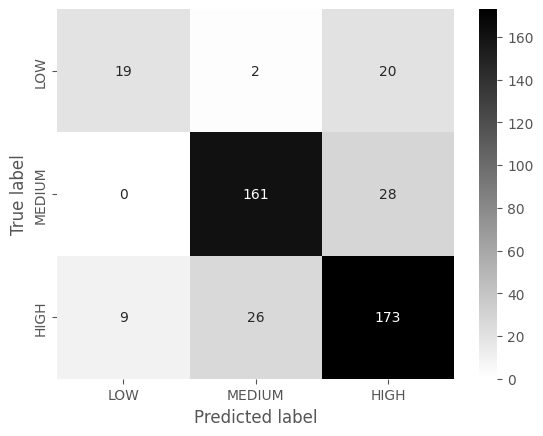

Classification report RFS


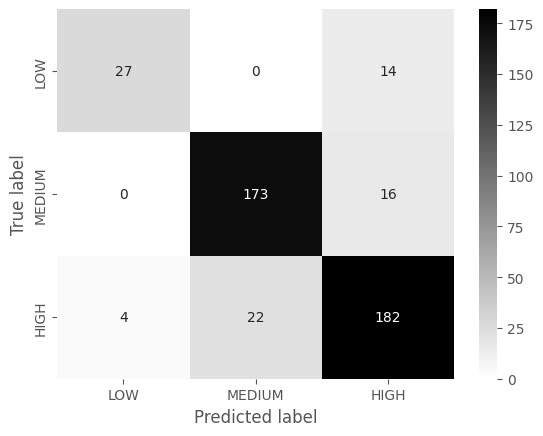

Classification report RFS_BL


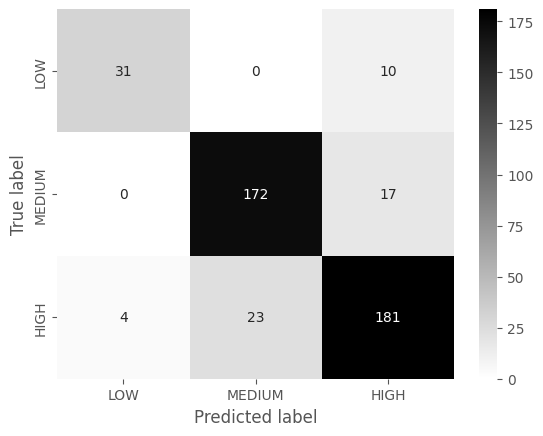

In [531]:
def make_confusion_matrix(cf, categories='auto', cbar=True, cmap='Blues', title=None):
    group_counts = [f'{value}\n' for value in cf.flatten()]

    box_labels = [f'{v1}'.strip() for v1 in group_counts]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    sb.heatmap(cf, annot=box_labels, fmt='', cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if title:
        plt.title(title)
    
    plt.show()


for model_name, model in models_choosed.items():
    print(f"Classification report {model_name}")
    make_confusion_matrix(confusion_matrix(y_test, models_choosed_pred[model_name]), categories=TARGET_FEATURE_VALUES, cmap='binary')

##### ROC Curve

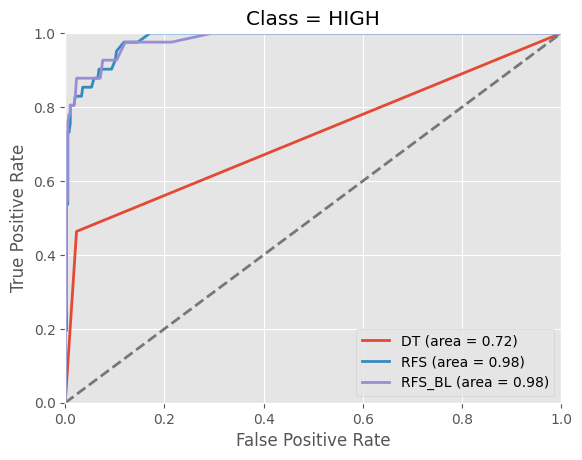

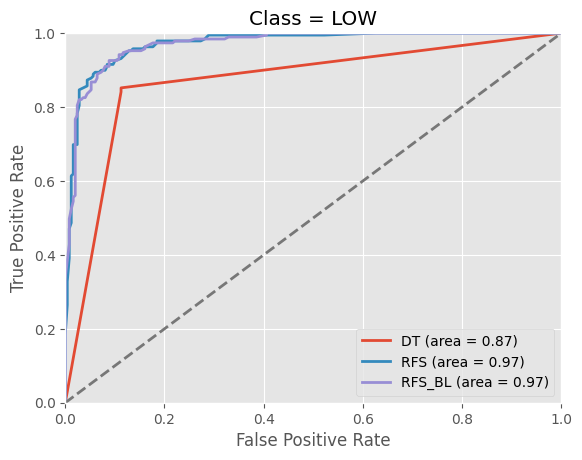

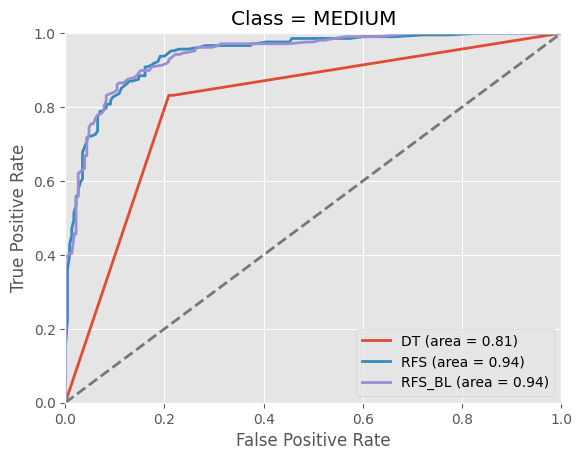

In [532]:
data_test = X_test.copy()
data_test[TARGET_FEATURE] = y_test
one_hot_encoding = np.array(pd.get_dummies(data_test, columns = ['SalePrice'])[['SalePrice_HIGH','SalePrice_LOW', 'SalePrice_MEDIUM']])

fpr = []
tpr = []
roc_auc = dict()

CLASSES = ['HIGH', 'LOW', 'MEDIUM']

for i in range(len(CLASSES)):
    plt.figure()

    for name, model in models_choosed.items():
        probabilities = model.predict_proba(X=X_test)
        fpr, tpr , _ = roc_curve(one_hot_encoding[:, i], probabilities[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=name + f' (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Class = ' + str(CLASSES[i]))
    plt.legend(loc='lower right')

    plt.show()  

### Deployment

In [533]:
selected_att = {"MSSubClass": ["ordinal integer"],
                "Neighborhood": ["category"],
                "HouseStyle": ["category"],
                "OverallQual": ["ordinal integer"],
                "YearBuilt": ["int64"],
                "BsmtFinType1":["ordinal category", ["NA","Unf","LwQ","Rec","BLQ","ALQ","GLQ"]],
                "FullBath":["int64"],
                "KitchenQual":["ordinal category", ["Po","Fa","TA","Gd","Ex"]],
                "TotalSF": ["int64"],
                "GarageArea": ["int64"],
                "GrLivArea": ["int64"],
                "CentralAir": ["category"],
                "MasVnrArea": ["int64"],
                "OverallQual": ["int64"],
                "MSZoning": ["category"],
                "PavedDrive": ["category"],
                "GarageCond": ["category"],
                "GarageCars": ["category"],
                "GarageFinish": ["category"],
                "KitchenQual": ["category"],
                "Utilities": ["category"],
                "ScreenPorch": ["int64"],
                "Electrical": ["category"],
                "LandSlope": ["category"],
                "SalePrice":["category"]}


aggregate_values = {}

#SELECTED_FEATURES = ['TotalSF', 'OverallQual', 'Neighborhood', 'ScreenPorch', 'HouseStyle', 'Electrical', 'LandSlope']


SELECTED_FEATURES = ['TotalSF', 'GarageArea', 'GrLivArea', 'CentralAir', 'MasVnrArea', 'OverallQual', 'MSZoning', 'PavedDrive', 'GarageCond', 'GarageCars',
                     'GarageFinish', 'KitchenQual', 'Utilities', 'MSSubClass', 'LotArea', 'Condition1', 'HouseStyle', 'OverallCond',
                     'BsmtQual', 'SaleType',
                     'Fireplaces', 'Functional']
"""
aggregate_values = {
                    "HouseStyle": {
                                    "1Story" : "other",
                                    "1.5Unf" : "other",
                                    "2.5Fin" : "other",
                                    "2.5Unf" : "other",
                                    "Sfoyer" : "other",
                                    "SLvl" : "other"
                                    },
                    "OverallQual": {
                                    1 : 4,
                                    2 : 4,
                                    3 : 4,
                                    10 : 9,
                                    },
                    "BsmtFinType1": {
                                    "ALQ" : "other",
                                    "BLQ" : "other",
                                    "Rec" : "other",
                                    "LwQ" : "other",
                                    "NA" : "other",
                                },
                    "KitchenQual": {
                                    "Fa" : "TA",
                                    "Po" : "TA",
                                },
                    }"""

'\naggregate_values = {\n                    "HouseStyle": {\n                                    "1Story" : "other",\n                                    "1.5Unf" : "other",\n                                    "2.5Fin" : "other",\n                                    "2.5Unf" : "other",\n                                    "Sfoyer" : "other",\n                                    "SLvl" : "other"\n                                    },\n                    "OverallQual": {\n                                    1 : 4,\n                                    2 : 4,\n                                    3 : 4,\n                                    10 : 9,\n                                    },\n                    "BsmtFinType1": {\n                                    "ALQ" : "other",\n                                    "BLQ" : "other",\n                                    "Rec" : "other",\n                                    "LwQ" : "other",\n                                    "NA" : "other

In [534]:
def prepare_dataset(dataf: pd.DataFrame, global_df:pd.DataFrame=None, for_training: bool=True, training_features: list=None) -> pd.DataFrame:
    
    #
    # feature creation (fcr) only
    dataf = data_transformation(global_df, dataf, aggregate_values, scale=False, aggr=False, fcr=True)

    #
    # feature selection
    dataf = dataf[SELECTED_FEATURES + [TARGET_FEATURE]]

    #
    # data cleaning
    #dataf = data_cleaning_reduction(dataf, selected_att=selected_att)

    #
    # remove outliers from training_df
    no_outliers_indices = dataf.index
    if for_training:
        df_with_outliers = dataf
        outlierAnalyzer = OutlierAnalyzer(df_with_outliers, silent=True)

        dataf[TARGET_FEATURE_CONTI] = global_df[TARGET_FEATURE_CONTI]
        #for feature in dataf.columns.tolist():
        #    if feature == TARGET_FEATURE or feature == TARGET_FEATURE_CONTI: continue
            #outliers = outlierAnalyzer.analyze_corr(feature, remove=True)
        outliers = outlierAnalyzer.analyze_borders(remove=True, margin=0.2)
        
        no_outliers_indices = outlierAnalyzer.dataf.index
        dataf = dataf.drop(TARGET_FEATURE_CONTI, axis=1)
        print("No outlier rows: %d" % len(no_outliers_indices))
        print("Border rows: %d" % (1460 - len(no_outliers_indices)))
    
    #
    # data transformation (scaling and aggregation only)
    dataf = data_transformation(global_df, dataf, aggregate_values, scale=True, aggr=True, fcr=False)

    #
    # compute dummies
    cat_attributes = list(dataf.select_dtypes(include = ['category', 'object']).columns)
    if TARGET_FEATURE in cat_attributes: cat_attributes.remove(TARGET_FEATURE)
    dataf = pd.get_dummies(dataf, columns=cat_attributes)

    #
    # remove outlier rows
    #
    dataf = dataf.loc[no_outliers_indices]

    #print("\n\n\n\nDATAFRAME_FINAL\n", dataf.head())

    return dataf


def train_model(training_df: pd.DataFrame, global_df:pd.DataFrame, train_idx: np.ndarray, model): # training_df must be untouched (no dummies, no scale)
    
    training_df = prepare_dataset(training_df, global_df, for_training=False)

    #
    # train the model on the training set
    actual_train_idx = []
    for i in train_idx:
        if i in training_df.index: actual_train_idx.append(i)
    
    X_train = training_df.drop(TARGET_FEATURE, axis=1)
    y_train = training_df[TARGET_FEATURE]

    X_train = X_train.loc[actual_train_idx]
    y_train = y_train.loc[actual_train_idx]
    
    print("Training attrs:", X_train.columns.tolist())
    print("Training length:", len(X_train))

    model.fit(X=X_train.to_numpy(), y=y_train.to_numpy())

    return model


def classify(test_df: pd.DataFrame, global_df: pd.DataFrame, test_idx: np.ndarray, model):
    
    test_df = prepare_dataset(test_df, global_df, for_training=False)

    actual_test_idx = []
    for i in test_idx:
        if i in test_df.index: actual_test_idx.append(i)

    X_test = test_df.drop(TARGET_FEATURE, axis=1)
    y_test = test_df[TARGET_FEATURE]

    X_test = X_test.loc[actual_test_idx].to_numpy()
    y_test = y_test.loc[actual_test_idx].to_numpy()

    print("Testing length:", len(X_test))

    y_pred = model.predict(X=X_test)

    return y_test, y_pred

Training attrs: ['TotalSF', 'GarageArea', 'GrLivArea', 'OverallQual', 'GarageCars', 'MSSubClass', 'LotArea', 'OverallCond', 'Fireplaces', 'CentralAir_N', 'CentralAir_Y', 'MasVnrArea_0', 'MasVnrArea_1', 'MasVnrArea_100', 'MasVnrArea_101', 'MasVnrArea_102', 'MasVnrArea_1031', 'MasVnrArea_104', 'MasVnrArea_1047', 'MasVnrArea_105', 'MasVnrArea_106', 'MasVnrArea_108', 'MasVnrArea_109', 'MasVnrArea_11', 'MasVnrArea_110', 'MasVnrArea_1115', 'MasVnrArea_112', 'MasVnrArea_1129', 'MasVnrArea_113', 'MasVnrArea_114', 'MasVnrArea_115', 'MasVnrArea_116', 'MasVnrArea_117', 'MasVnrArea_1170', 'MasVnrArea_119', 'MasVnrArea_120', 'MasVnrArea_122', 'MasVnrArea_123', 'MasVnrArea_125', 'MasVnrArea_126', 'MasVnrArea_127', 'MasVnrArea_128', 'MasVnrArea_130', 'MasVnrArea_132', 'MasVnrArea_135', 'MasVnrArea_136', 'MasVnrArea_137', 'MasVnrArea_1378', 'MasVnrArea_138', 'MasVnrArea_14', 'MasVnrArea_140', 'MasVnrArea_142', 'MasVnrArea_143', 'MasVnrArea_144', 'MasVnrArea_145', 'MasVnrArea_146', 'MasVnrArea_147', 'M

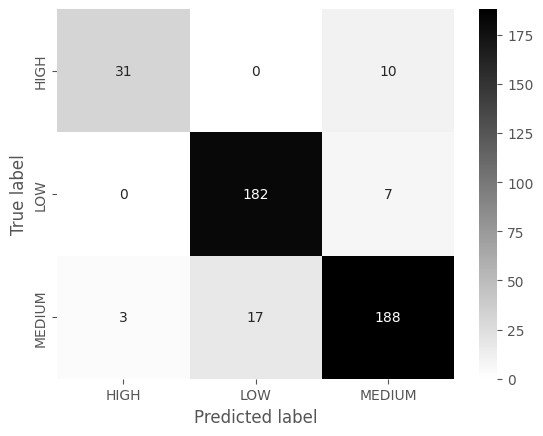

In [535]:
#
# simulation of a brand new training set and test set
#
#####################################################
global_df = df  # dataset given in input
df_copy = global_df.copy(deep=True)
features = global_df.columns.tolist()
features.remove(TARGET_FEATURE)
features.remove(TARGET_FEATURE_CONTI)

train_idx, test_idx = split_train_test(global_df[features + [TARGET_FEATURE]])
#####################################################

# simulation of an execution
model = RandomForestClassifier(criterion='entropy', random_state=SEED)

model = train_model(df_copy, global_df, train_idx, model)
y_test, y_pred = classify(df_copy, global_df, test_idx, model)

print(classification_report(y_test, y_pred))
make_confusion_matrix(confusion_matrix(y_test, y_pred), categories= ['HIGH', 'LOW', 'MEDIUM'] , cmap='binary')